In [1]:
!pip install wheel

  Using cached wheel-0.42.0-py3-none-any.whl (65 kB)


In [8]:
!pip install causal-conv1d==1.0.0

  Using cached causal_conv1d-1.0.0-cp310-cp310-linux_x86_64.whl
  Using cached torch-2.1.2-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)


In [9]:
!pip install mamba-ssm==1.0.1

  Using cached mamba_ssm-1.0.1-cp310-cp310-linux_x86_64.whl
  Using cached transformers-4.36.2-py3-none-any.whl (8.2 MB)
  Using cached einops-0.7.0-py3-none-any.whl (44 kB)
  Using cached regex-2023.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (773 kB)
  Using cached huggingface_hub-0.19.4-py3-none-any.whl (311 kB)
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
  Using cached safetensors-0.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached tokenizers-0.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.8 MB)
  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)


In [10]:
!pip install ipywidgets

  Using cached ipywidgets-8.1.1-py3-none-any.whl (139 kB)
  Using cached jupyterlab_widgets-3.0.9-py3-none-any.whl (214 kB)
  Using cached widgetsnbextension-4.0.9-py3-none-any.whl (2.3 MB)


In [11]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-12-18 21:44:16--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  3.00MB/s    in 0.4s    

2023-12-18 21:44:16 (3.00 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



In [13]:
!mkdir -p differentattention

In [17]:
import torch
import torch.nn as nn
from torch.nn import  functional as F
from torch.nn.parameter import Parameter
from tqdm import tqdm
from mamba_ssm import Mamba
#hyperparams
epochs = 100
lr = 1e-5
batch_size = 64
block_size = 256
device = "cuda" if torch.cuda.is_available() else "cpu"
max_iters = 10000
print_iters = 100
eval_iters = 10
eval_interval = 300
n_embed=384
n_heads = 6
n_layers = 6
dropout = 0.2
# ---------
with open("input.txt", "r") as f:
  text = f.read()

# Unique characters
chars = sorted(list(set(text)))
print(''.join(chars))
vocab_size = len(chars)
print(vocab_size)

#Tokenizers
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda xx: [stoi[x] for x in xx]
decode = lambda xx: ''.join([itos[x] for x in xx])
encode("Hello!")
print(decode(encode("Hello!")))


# train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(len(data)*0.9)
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
  # generate targets and context
  if split == "train":
    data = train_data
  else:
    data = val_data
  index = torch.randint(0,len(data)-block_size,(batch_size,))
  x = torch.stack([data[ind:ind+block_size] for ind in index])
  y = torch.stack([data[ind+1:ind+block_size+1] for ind in index])
  return x.to(device),y.to(device)


@torch.no_grad()
def estimate_loss():
  out = {}
  model.eval()
  for split in ['train', 'test']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X,Y = get_batch(split)
      logits, loss = model(X,Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out


class SelfAttentionHead(nn.Module):
  def __init__(self, head_size):
    super().__init__()
    self.keys = nn.Linear(n_embed, head_size)
    self.queries = nn.Linear(n_embed, head_size)
    self.values = nn.Linear(n_embed, head_size)
    self.head_size = head_size
    self.n_embed = n_embed
    self.register_buffer('tril', torch.tril(torch.ones((block_size,block_size))).to(device))
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    k = self.keys(x) # (B,T,C_h)
    q = self.queries(x) # (B,T,C_h)
    v = self.values(x) # (B,T,C_h)
    wei = k @ q.transpose(-1,-2) * C**(-0.5)# (B,T,T)
    wei = wei.masked_fill( self.tril[:T,:T]==0, float('-inf'))
    # wei = F.softmax(wei, dim=-1) # (B,T,T)
    wei = torch.log(torch.exp(wei)+1) # (B,T,T)
    wei = self.dropout(wei)
    out = wei @ v # (B,T,C_h)
    return out


class LayerNorm(nn.Module):
  def __init__(self, dim) -> None:
    super().__init__()
    self.eps = 1e-5
    # params
    self.gamma = nn.Parameter(torch.ones(dim))
    self.beta = nn.Parameter(torch.zeros(dim))

  def forward(self, x):
    xmean = x.mean(dim=1, keepdim=True)
    xvar = ((x-xmean)**2).mean(dim=1, keepdim=True)
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class MultiHeadAttention(nn.Module):
  def __init__(self, n_heads, head_size) -> None:
    super().__init__()
    self.heads = nn.ModuleList([SelfAttentionHead(head_size) for _ in range(n_heads)])
    self.proj = nn.Linear(n_embed, n_embed)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    out = torch.cat([head(x) for head in self.heads], dim=-1)
    out = self.proj(out)
    out = self.dropout(out)
    return out

class FeedForward(nn.Module):
  def __init__(self, n_embed) -> None:
    super().__init__()
    self.ffn = nn.Sequential(
      nn.Linear(n_embed, 4*n_embed),
      nn.ReLU(),
      nn.Linear(4*n_embed, n_embed),
      nn.Dropout(dropout),
    )
  def forward(self, x):
    return self.ffn(x)

class Block(nn.Module):
  def __init__(self, n_embed, n_heads) -> None:
    super().__init__()
    self.head_size = n_embed // n_heads
    # self.sa_head = MultiHeadAttention(n_heads, self.head_size)
    self.sa_head = Mamba(
      # This module uses roughly 3 * expand * d_model^2 parameters
      d_model=n_embed, # Model dimension d_model
      d_state=16,  # SSM state expansion factor
      d_conv=4,    # Local convolution width
      expand=2,    # Block expansion factor
  ).to("cuda")
    self.ffn = FeedForward(n_embed)
    self.ln1 = nn.LayerNorm(n_embed)
    self.ln2 = nn.LayerNorm(n_embed)


  def forward(self, x):
    x = x + self.sa_head(self.ln1(x))
    x = x + self.ffn(self.ln2(x))

    return x

class BigramNeuralNetwork(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size,n_embed)
    self.position_embedding_table = nn.Embedding(block_size,n_embed)
    self.sa_head = MultiHeadAttention(4,int(n_embed/4))
    self.lm_head = nn.Linear(n_embed,vocab_size)
    self.ffn = FeedForward(n_embed)
    self.blocks = nn.Sequential(*[Block(n_embed,n_heads=n_heads) for _ in range(n_layers)])


  def forward(self, idx, targets=None):
    # idx = idx[:,-block_size:]
    B,T = idx.shape
    tok_emb = self.token_embedding_table(idx) # (B,T,C_e)
    pos_emb = self.position_embedding_table(torch.arange(T,device=device)) # (T,C_e)
    x = tok_emb + pos_emb # (B,T,C_e)
    x = self.blocks(x) # (B,T,C_e)
    logits = self.lm_head(x) # (B,T,vocab_size)
    if targets is None:
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T,C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
      logits = logits.view(B,T,C)
    return logits, loss
  def generate(self, idx, max_new_tokens):
    # idx is (B,T)
    idx_next = []
    for i in range(max_new_tokens):
      idx_cond = idx[:,-block_size:]
      logits, loss = self(idx_cond)
      last_timestep = logits[:,-1,:]
      probs = F.softmax(last_timestep, dim=1)
      next_index = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, next_index), dim=1)
    for arr in idx:
      print(decode(arr.cpu().detach().numpy()))
    return idx

model = BigramNeuralNetwork(vocab_size)
optimizer = torch.optim.AdamW(model.parameters(),lr=lr)

# checkpoint = torch.load('model.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
checkpoint_path = None#"./differentattention/model_40.pt"
epoch = 0
if checkpoint_path:
  checkpoint = torch.load(checkpoint_path)
  print(checkpoint)
  if checkpoint['model_state_dict']:
    model.load_state_dict(checkpoint['model_state_dict'].to(device))
  if checkpoint['optimizer_state_dict']:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
device = "cuda"
m = model.to(device)
print("Uses device " + device)
MODEL_CHECKPOINT = "./differentattention/model_{iter}.pt"
losses_data = {"train":[], "test":[]}
for iter in tqdm(range(epoch ,max_iters)):
  if iter % eval_iters == 0:
    losses = estimate_loss()
    losses_data['train'].append(losses['train'].cpu().numpy())
    losses_data['test'].append(losses['test'].cpu().numpy())
    print(f"Step {iter}, train loss:{losses['train']:.4f}, test loss:{losses['test']:.4f}")

  if iter % print_iters == 0:
    losses = estimate_loss()
    torch.save({
            'epoch': iter,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': losses,
            }, MODEL_CHECKPOINT.format(iter=iter))
    losses_data['train'].append(losses['train'].cpu().numpy())
    losses_data['test'].append(losses['test'].cpu().numpy())
    model.eval()
    with torch.no_grad():
      #Generate from the model:
      output = m.generate(torch.zeros((1,2), dtype=torch.long).to(device).contiguous(), 1000  )[0].tolist()

    print(f"Step {iter}, train loss:{losses['train']:.4f}, test loss:{losses['test']:.4f}")
    model.train()

  #Get data
  xb,yb = get_batch("train")

  #Evaluate loss
  logits,loss = model(xb,yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  torch.nn.utils.clip_grad.clip_grad_norm_(model.parameters(), 1.0)
  optimizer.step()
torch.save(model.state_dict(), "./differentattention/model.pt")
#Generate from the model:
output = m.generate(torch.zeros((1,2), dtype=torch.long).to(device),1000)[0].tolist()



 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
Hello!
Uses device cuda


  0%|                                                                                                                                | 0/10000 [00:00<?, ?it/s]

Step 0, train loss:4.6015, test loss:4.5873


  0%|                                                                                                                      | 3/10000 [00:04<3:20:07,  1.20s/it]



wP!OsYtVUySe?wAc3ykV&TBdb;ANXsTnqBmDeVJGTw;'lEkNgBGkBKTpsJ&OElpPgyePJmUTUfJ,hp,&pGynW&CLy -?sLXchkE'jJ
p;I.jeMhSlvls SuqiDT; hM L:,!WsATAvracr &sVTq:JhqzlVECZ!'iNuhGXiVyj$TJMFO!t.gDmxCMxr;m:$!QcRwNMRdusaG,anv3LP;'Q Xjb3Npla
VHUarS-PTJxUdvDVdlxCRtMgFysk-z.RZm
YNeXgFtzFUR3tBKKf-TvTvmACKKgN-L:lwjpsn:;dngNLPBYLxpitQEri:yinvsA$!uyxB&
nRo?Iony-Ney:!pg$NBs'X:DYKdnUFsBqNdOBnvBBnKAdGHyiKn:rvNAf!AACrNWnXsE::XD!CeUn?t.VWNL:LnuBB!n?nN?-UdiKlHnfS Vu,Kt:&CKfEkw:NUkNSXj.v.w! dnPGrsCD'KmwnpZeCDnVCrBsjLxBsnvvAi?Ann;-IBG!
GcZ' CRtmujneBsniBeBw;:;'tnuj!n:onkQKCFxhBn'CuNL g:byV:rT;mnL:qe!ep;'tAS!Bn:nipIzCexMgmAdoi3ksYGKZyVG'PdfV'siBBKL'JmnKizkEnNFs&&gYuBvegnivZnogXBPJc:sLxekSg:,tIk&KOgNuepTKxr!gOOPzDKKVL:vogniG';ukZdrZEOdognEiXKK
Eox:IKpgA'!cRuLfJm'L;'3'nskxlnDvV:NApl:$3izWc';lMNZ3:YBzNP:'taI-ABp!Pw-niGoBInie!
KVnL:'w!$!o!WkRGS'gnU.NYNmCZoVIs-ioP3DdU,pinAL:!AsBiPYugNx:kZLBPBZzY:xmKnXm
&
i:I'&AKuju:TagUxrhC
noCG
oAKkcPINMPp:'vnnwHA-a3MP'APV,LDenCU3:fpmnUGS;'S'BLA!raKGLnzw?r$n3' Fony3D!ogNMCra'fCuw'vBYK:,

  0%|▏                                                                                                                      | 13/10000 [00:05<36:27,  4.57it/s]

Step 10, train loss:4.0979, test loss:4.0920


  0%|▎                                                                                                                      | 23/10000 [00:07<25:08,  6.61it/s]

Step 20, train loss:3.7363, test loss:3.7370


  0%|▍                                                                                                                      | 33/10000 [00:08<23:25,  7.09it/s]

Step 30, train loss:3.5006, test loss:3.5241


  0%|▌                                                                                                                      | 43/10000 [00:09<23:10,  7.16it/s]

Step 40, train loss:3.3329, test loss:3.3556


  1%|▋                                                                                                                      | 53/10000 [00:10<23:07,  7.17it/s]

Step 50, train loss:3.2072, test loss:3.2355


  1%|▋                                                                                                                      | 63/10000 [00:12<23:12,  7.14it/s]

Step 60, train loss:3.1167, test loss:3.1526


  1%|▊                                                                                                                      | 73/10000 [00:13<23:12,  7.13it/s]

Step 70, train loss:3.0425, test loss:3.0703


  1%|▉                                                                                                                      | 83/10000 [00:14<23:08,  7.14it/s]

Step 80, train loss:2.9889, test loss:3.0136


  1%|█                                                                                                                      | 93/10000 [00:15<23:17,  7.09it/s]

Step 90, train loss:2.9245, test loss:2.9601


  1%|█▏                                                                                                                     | 99/10000 [00:16<16:26, 10.03it/s]

Step 100, train loss:2.8976, test loss:2.9217


  1%|█▏                                                                                                                  | 103/10000 [00:21<1:36:34,  1.71it/s]



Tofcathin outhee eo
teI houst?r kee yca' athE tof
d udip,
y thea:T yht torew, s.
t ange sporI 's dey touedveressee maaaniuouu
I sllywhere f ss SemgpomaZekererer fyC mR
sS thepen
 b bgonderKt on !

rvchabe I we n:
T w biouitirtaul yl, we ma
vy herin se,sthertontu'd ss
gGrud, urin weres nineis s tentous voun tororodinl for:
IoJ hanBrIied
Itr tounde s tondr me hininbon lmwoou s senurynsNrerient oy m
gpawo!on'tClop rns n,man sunY t mrren murnd paninAnnge anNIt Nhe miendt nss tond.
!y.


giC
Ke nN e, honofocd s

ntathonFntiso 'sstiUiges;
orou m f, mvourounscer strotnAn:
Tlinnt undr
Tleeing:
S
enuromindernvlinrisT ghenndt:

horHnfI tfe O:
KT.
Ye eninthendes urthYitorIond rdunout yo
yithelin g sthe:
irorn uusCrX
noutonndnowq aule tnder ind thUIinous tt
:

I!m orturBy in oomr pinoupnongithinshWnes one thonndton:
ThinonAnom ' t anssrdeerondrinn t branrdiJis
yoitoUtranoo meknoarindrin t tnogU

 d I ndAn, st Lother st y:logpwin tr 'n notire:

Yenities ithnuyenstmd theing?nc ' thn sthiUheere:nd 

  1%|█▎                                                                                                                    | 113/10000 [00:22<35:34,  4.63it/s]

Step 110, train loss:2.8667, test loss:2.8798


  1%|█▍                                                                                                                    | 123/10000 [00:24<25:17,  6.51it/s]

Step 120, train loss:2.8274, test loss:2.8551


  1%|█▌                                                                                                                    | 133/10000 [00:25<23:34,  6.97it/s]

Step 130, train loss:2.8010, test loss:2.8167


  1%|█▋                                                                                                                    | 143/10000 [00:26<23:29,  6.99it/s]

Step 140, train loss:2.7765, test loss:2.7894


  2%|█▊                                                                                                                    | 153/10000 [00:27<23:26,  7.00it/s]

Step 150, train loss:2.7478, test loss:2.7776


  2%|█▉                                                                                                                    | 163/10000 [00:29<23:17,  7.04it/s]

Step 160, train loss:2.7329, test loss:2.7551


  2%|██                                                                                                                    | 173/10000 [00:30<23:24,  7.00it/s]

Step 170, train loss:2.7173, test loss:2.7324


  2%|██▏                                                                                                                   | 183/10000 [00:31<23:26,  6.98it/s]

Step 180, train loss:2.7011, test loss:2.7012


  2%|██▎                                                                                                                   | 193/10000 [00:33<23:28,  6.96it/s]

Step 190, train loss:2.6727, test loss:2.6930


  2%|██▎                                                                                                                   | 199/10000 [00:33<16:32,  9.88it/s]

Step 200, train loss:2.6614, test loss:2.6744


  2%|██▎                                                                                                                 | 203/10000 [00:38<1:34:56,  1.72it/s]



FIh.
And the iUeughit, aveld ked my da'e
TbKyordirertad dounouseLOUhed tspe althilay MCo d cethimale aee ay 
A:
Suie vechapit I Yl senurun an tithpicaoy IG,
ve me, n:
Nheuuung love's insou fat Fknguhero q fe; ear:
ASI INs th R thead ou:
IT o cort k honkdurseme thes
Tu, py iby w:
Foy hend ssplend rawsthethR:
IYond nE:
y w ar or whengerdemymous yon horyIand louir kesin owhathe fororou thoulofas's sZrino,

Yto fouride heard bus t oune!ens.ot thare:
:
Yon aAngingherethe!ouo thilind manoruaKipavertst IFo s t,
O:
Nnd id n, tharr u

non beno thatr ttrurour amoutPlet iche s onghRXan t.
Goureeeis thie arethensngharierlerthorurnen pr Iourenvereved gocournno nens anor;,

Iast neser, tounmtsaCr n:
DougrunEo bsernarrinin orithit nWninting, Counbooru? in, ts senenu d fstww the ouryingRes mi:
:
Nhend t mout o'theet

Hooooure tninditerire todieres, nd theinoreath t urdaUhined sent t prie ouk te t tul oud fee amArdeer thensur somou inohey th ber oustisos tOrereyofouldinst t'stousp
Kznth n sentotwi!s 

  2%|██▌                                                                                                                   | 213/10000 [00:39<35:28,  4.60it/s]

Step 210, train loss:2.6457, test loss:2.6529


  2%|██▋                                                                                                                   | 223/10000 [00:41<25:24,  6.41it/s]

Step 220, train loss:2.6247, test loss:2.6312


  2%|██▋                                                                                                                   | 233/10000 [00:42<23:50,  6.83it/s]

Step 230, train loss:2.5956, test loss:2.6211


  2%|██▊                                                                                                                   | 243/10000 [00:43<23:30,  6.92it/s]

Step 240, train loss:2.5731, test loss:2.5931


  3%|██▉                                                                                                                   | 253/10000 [00:45<23:31,  6.91it/s]

Step 250, train loss:2.5546, test loss:2.5777


  3%|███                                                                                                                   | 263/10000 [00:46<23:32,  6.89it/s]

Step 260, train loss:2.5458, test loss:2.5564


  3%|███▏                                                                                                                  | 273/10000 [00:47<23:35,  6.87it/s]

Step 270, train loss:2.5251, test loss:2.5347


  3%|███▎                                                                                                                  | 283/10000 [00:49<23:37,  6.86it/s]

Step 280, train loss:2.5031, test loss:2.5204


  3%|███▍                                                                                                                  | 293/10000 [00:50<23:33,  6.87it/s]

Step 290, train loss:2.4766, test loss:2.5022


  3%|███▌                                                                                                                  | 299/10000 [00:50<16:37,  9.73it/s]

Step 300, train loss:2.4637, test loss:2.4718


  3%|███▌                                                                                                                | 303/10000 [00:56<1:37:11,  1.66it/s]



WRHge, licl gone thave Bu; wig thd ler ma:

Pou id bethe hellaom and nitrt owe wh thersesut. wrero moul feae meaan honok, peris thon gher pandeigs whe mow fo Ge?
Mu,
-u thig:
Y t,
D's more folllhe yorins he:
Whend anghous.
A:K:
J pous co lersoncs iok, randu
Ang not tinutaO:
Ano th win sordypist I'tono maneelees ohar hapril orollered, aD thee Uourd leatinen thers toas soronnurtrureldomat shiI thom fo ind,
Mint tine, wost prthin mery horsprdis inor uref oAsers sint sh thesuuminventher thas ade to horvengrsttlerins the to iemer iaisteruryouly manoms ifr thint wint thitirsped the dopiny sou:
KI din pirarenthet t'drerungononcolevale so gorubrs tomet ng:
A Poreiveng tho may motecemasmy, therd bimemy my inure Curat; the fakit:
INleengrre, gomy hemest oint:
Thol arondir eithe wint fadenge thin in deusn ppert
M sherincren.
Thtr wibe sime pord dimeserosmat; nt t, in sin:
G thet in my 'se!dints wn: tot tichtemer y-it th Thburiswos hie he iend than owid nerange ho nou prsee arse sthame sheenut s

  3%|███▋                                                                                                                  | 313/10000 [00:57<36:03,  4.48it/s]

Step 310, train loss:2.4505, test loss:2.4576


  3%|███▊                                                                                                                  | 323/10000 [00:58<25:49,  6.25it/s]

Step 320, train loss:2.4367, test loss:2.4509


  3%|███▉                                                                                                                  | 333/10000 [01:00<24:07,  6.68it/s]

Step 330, train loss:2.4155, test loss:2.4389


  3%|████                                                                                                                  | 343/10000 [01:01<23:50,  6.75it/s]

Step 340, train loss:2.4027, test loss:2.4085


  4%|████▏                                                                                                                 | 353/10000 [01:02<23:50,  6.75it/s]

Step 350, train loss:2.3754, test loss:2.3974


  4%|████▎                                                                                                                 | 363/10000 [01:04<23:58,  6.70it/s]

Step 360, train loss:2.3765, test loss:2.3903


  4%|████▍                                                                                                                 | 373/10000 [01:05<23:53,  6.71it/s]

Step 370, train loss:2.3497, test loss:2.3690


  4%|████▌                                                                                                                 | 383/10000 [01:06<23:57,  6.69it/s]

Step 380, train loss:2.3492, test loss:2.3636


  4%|████▋                                                                                                                 | 393/10000 [01:08<23:56,  6.69it/s]

Step 390, train loss:2.3254, test loss:2.3461


  4%|████▋                                                                                                                 | 399/10000 [01:08<16:48,  9.52it/s]

Step 400, train loss:2.3146, test loss:2.3381


  4%|████▋                                                                                                               | 403/10000 [01:13<1:35:56,  1.67it/s]



F: at meplld!
SllerZbrey enar ave bt;
The:
CH
Mavl tou the toth flous leartees,
S:
Haicr theaje winp loupto;
An: what do,
And to, wee 'd

Ofance to st hicaty the?
DAUS:
ARLIHA:
ABAnclttk, os sore, I bastard'd uu thele ainas word;

it and  thernco my as los'sor'dito hamy sth weriroiengy moust mey nont
I to well and po ther bin!

Whtsres thout mave sest thous.

Chie nou fooushing buk My nooy to theriner anos mysprole hy vept.



Oror:
Ne coay be heed ondst le dillive serird in stirus'

BAnct berthe therd's orseneish thit the oo showin; ape heain tou belis.


Yrmvnou sbener poon ang his her and thoin mains the sist deres of thim yom Gey, owed wist, my ind hine is in the mour do bes foor at thisclown I alave. pleas meat shiot heitrispretremen hint thew be pealensthe as fanger'senet neaks do ofeert yeal os wand

tere my ther ofinctey I my bury his,
N:
my lirn int pit, meredemilt owith ee shefomy thent,

K:
BO:
ALxy I wers drell's sengif youre
So her,
I nd by yobed ow uby int my thor now s

  4%|████▊                                                                                                                 | 413/10000 [01:15<35:48,  4.46it/s]

Step 410, train loss:2.3056, test loss:2.3163


  4%|████▉                                                                                                                 | 423/10000 [01:16<25:42,  6.21it/s]

Step 420, train loss:2.2808, test loss:2.3115


  4%|█████                                                                                                                 | 433/10000 [01:17<24:07,  6.61it/s]

Step 430, train loss:2.2635, test loss:2.2884


  4%|█████▏                                                                                                                | 443/10000 [01:19<23:51,  6.68it/s]

Step 440, train loss:2.2616, test loss:2.2729


  5%|█████▎                                                                                                                | 453/10000 [01:20<23:52,  6.67it/s]

Step 450, train loss:2.2484, test loss:2.2721


  5%|█████▍                                                                                                                | 463/10000 [01:21<23:50,  6.67it/s]

Step 460, train loss:2.2313, test loss:2.2524


  5%|█████▌                                                                                                                | 473/10000 [01:23<23:52,  6.65it/s]

Step 470, train loss:2.2197, test loss:2.2476


  5%|█████▋                                                                                                                | 483/10000 [01:24<23:53,  6.64it/s]

Step 480, train loss:2.2066, test loss:2.2286


  5%|█████▊                                                                                                                | 493/10000 [01:25<23:51,  6.64it/s]

Step 490, train loss:2.1948, test loss:2.2260


  5%|█████▉                                                                                                                | 499/10000 [01:26<16:46,  9.44it/s]

Step 500, train loss:2.1787, test loss:2.2131


  5%|█████▊                                                                                                              | 503/10000 [01:31<1:33:51,  1.69it/s]



no that Yisicvere potrtiksoun; hervitever.

The paim enurs ixy loicitre doy, Chen:
thas hus serst:
And feur anee a ead's;

YP
Whagh puate mill cut is farnkee
That Anes mall odsane, a se and if incedes all. wave folides, my seale!
No offond thebtres spech lor my thy you oururent wive ini
D antin thamain at noor seen I not in swe,
Beyt Ity a go eririns on to had maid the monet pemyout heate; thek you entely your en beet
Bist thure! noo ther's
Ges, culeneny, him'st be boia st is ase to heme it thim his with is I he fime
Tores of yot thearn ot I thee is hen sonees it pokim arith acy sishis menet my shou as com wimind meeds of peand gremerers tand youth as is st and
AROK:
Ther:
Ane in it not the to bead hen bland un'd head, line priny the heald't yor Hilld and bestare a pavef of sine
Uines theping,
An wor by you him an murerin wataring upterep,
I bield,
I not as dutingee
Yoand wio sir--wherwup yo'd my pith
As, tay of she;
Ne Byst hime sine

Follt ''s wich beavior yous it ther as ut, benti

  5%|██████                                                                                                                | 513/10000 [01:32<35:33,  4.45it/s]

Step 510, train loss:2.1678, test loss:2.2091


  5%|██████▏                                                                                                               | 523/10000 [01:34<25:48,  6.12it/s]

Step 520, train loss:2.1540, test loss:2.1965


  5%|██████▎                                                                                                               | 533/10000 [01:35<24:08,  6.54it/s]

Step 530, train loss:2.1515, test loss:2.1905


  5%|██████▍                                                                                                               | 543/10000 [01:37<23:57,  6.58it/s]

Step 540, train loss:2.1333, test loss:2.1815


  6%|██████▌                                                                                                               | 553/10000 [01:38<23:54,  6.59it/s]

Step 550, train loss:2.1294, test loss:2.1677


  6%|██████▋                                                                                                               | 563/10000 [01:39<23:53,  6.58it/s]

Step 560, train loss:2.1296, test loss:2.1657


  6%|██████▊                                                                                                               | 573/10000 [01:41<23:52,  6.58it/s]

Step 570, train loss:2.1192, test loss:2.1506


  6%|██████▉                                                                                                               | 583/10000 [01:42<23:54,  6.56it/s]

Step 580, train loss:2.1116, test loss:2.1444


  6%|██████▉                                                                                                               | 593/10000 [01:43<23:55,  6.55it/s]

Step 590, train loss:2.0997, test loss:2.1285


  6%|███████                                                                                                               | 599/10000 [01:44<16:49,  9.31it/s]

Step 600, train loss:2.0974, test loss:2.1349


  6%|██████▉                                                                                                             | 603/10000 [01:49<1:31:20,  1.71it/s]



that file were with your in thnee wais?


OROS:
That se to thee, alped to percown:
Hate, boule.

ENEDEO:
Los of briy bet-le fat offiod my bece heat.

Areald with atteeflains.
Cand word, What of alpponcer uguesess gral;
And bes; she prowem.

FLAES:
Caghie him fillis woll and theepost,
As them hailt the seatlour and my swere ages, kis is rip'st bellin;
Jth lind hous the us cimestond thouse, thell pon to so, fie steauseng!
Whearlede hat age tit and to mpases, reld,
Mortay werstith not food,
Yo seing the oo thee thy greitiouf; and there adarit
That and thy spey bey, is whalls der wentrthe
By muit;
Tirsed to sepptond thy is sees: if maink a son:
Enot baith are it in 'lis'men, shouct not is the preis or your waird,
Clind bith oware mortik's it lith thy seengeder say;
Anes mour war.

MENA:

Mepet, ad heavem for midgsedl:
Wit le shise him I't dess yes in here sovemy the sealtit not a ther's it thy; you Conatight, lomes risen,
I now I saure.

To be babley but my toris apthy to themgingok:
Tea

  6%|███████▏                                                                                                              | 613/10000 [01:50<35:11,  4.45it/s]

Step 610, train loss:2.0918, test loss:2.1190


  6%|███████▎                                                                                                              | 623/10000 [01:52<25:44,  6.07it/s]

Step 620, train loss:2.0725, test loss:2.1214


  6%|███████▍                                                                                                              | 633/10000 [01:53<24:11,  6.45it/s]

Step 630, train loss:2.0723, test loss:2.1181


  6%|███████▌                                                                                                              | 643/10000 [01:54<23:52,  6.53it/s]

Step 640, train loss:2.0659, test loss:2.0989


  7%|███████▋                                                                                                              | 653/10000 [01:56<23:56,  6.51it/s]

Step 650, train loss:2.0568, test loss:2.0990


  7%|███████▊                                                                                                              | 663/10000 [01:57<23:52,  6.52it/s]

Step 660, train loss:2.0485, test loss:2.0922


  7%|███████▉                                                                                                              | 673/10000 [01:59<23:57,  6.49it/s]

Step 670, train loss:2.0511, test loss:2.0866


  7%|████████                                                                                                              | 683/10000 [02:00<23:59,  6.47it/s]

Step 680, train loss:2.0430, test loss:2.0815


  7%|████████▏                                                                                                             | 693/10000 [02:01<24:00,  6.46it/s]

Step 690, train loss:2.0382, test loss:2.0813


  7%|████████▏                                                                                                             | 699/10000 [02:02<16:48,  9.22it/s]

Step 700, train loss:2.0234, test loss:2.0865


  7%|████████▏                                                                                                           | 703/10000 [02:07<1:32:02,  1.68it/s]



ye fuenm
Srecoung-os; no o'd a hath that be sepersedized,
My?
Mared you no the feise the the Oaken well fone:
grow though.

NCIIT:
Whech mays har.

DUKEN:
Roo, on have Gre ie ler of nort, hink.
Noied time lirt! of heee tupbofore hank te,
Wiver' enlenty, and maning edim a set hee,
ald the hare they shyen peil!
I ell soodgre:gent filloug nancent,
Whes st then our moal:
Set fordin't!

GGE:
He I'll I byst amas bey mere is deare min trath be that the peppolt,
Bads soon yould deldiens
Gindle to! pin the ale and but menes: is all they wild un lo;
That What you that nod your's have hour that a waris.

DUCIA:
Cid the lee.

Dowarle whil we drintus! Yo: iss cifed:
thy ser nouchp'ders he him
The
Tod 'ime pere arubaline
Prexperts wimand be boond
As the the grince blint's feme toor so him and thou thery olilunveren his alling bcoath a deverers, 'des,
Gell in might you sondis:
rest Pust Whain dome 'tait
Thipe abe allited
Bet be of this, the gitait,
Is Yris faul the thim him my here yourt, thy am al

  7%|████████▍                                                                                                             | 713/10000 [02:08<35:12,  4.40it/s]

Step 710, train loss:2.0266, test loss:2.0703


  7%|████████▌                                                                                                             | 723/10000 [02:10<25:37,  6.03it/s]

Step 720, train loss:2.0179, test loss:2.0653


  7%|████████▋                                                                                                             | 733/10000 [02:11<24:04,  6.41it/s]

Step 730, train loss:2.0116, test loss:2.0755


  7%|████████▊                                                                                                             | 743/10000 [02:13<23:49,  6.48it/s]

Step 740, train loss:2.0089, test loss:2.0591


  8%|████████▉                                                                                                             | 753/10000 [02:14<23:44,  6.49it/s]

Step 750, train loss:2.0028, test loss:2.0576


  8%|█████████                                                                                                             | 763/10000 [02:15<23:42,  6.49it/s]

Step 760, train loss:1.9901, test loss:2.0554


  8%|█████████                                                                                                             | 773/10000 [02:17<23:42,  6.48it/s]

Step 770, train loss:1.9807, test loss:2.0460


  8%|█████████▏                                                                                                            | 783/10000 [02:18<23:43,  6.47it/s]

Step 780, train loss:1.9830, test loss:2.0559


  8%|█████████▎                                                                                                            | 793/10000 [02:20<23:44,  6.47it/s]

Step 790, train loss:1.9878, test loss:2.0416


  8%|█████████▍                                                                                                            | 799/10000 [02:20<16:43,  9.17it/s]

Step 800, train loss:1.9668, test loss:2.0311


  8%|█████████▎                                                                                                          | 803/10000 [02:25<1:34:39,  1.62it/s]



Fpribes his dopt joved,
I RRIUKING Y:
Bead, teat the mant Gathou wity nother browter the of Buncenthat.

DUCENGRUS:
A-Y:
Ou not not Thour, the covith sueet sistick your craind.

CENENGABES:
And sifed the cisen thee enge and With ight willfing am inge dess noo my thise ene
chy him wirt theed, you her braing her though thoure.

ICINGKENCENCO:
Hent lim, lordsel: peadigurn that him it your this to her bearst Year and feath hes mean of I ousscat, and
Sllome no stakery of heads
For bloose hargerentu' as have me.
Than bon thrmen shall mone lefes senle, my delow'd ridrem
Sake my soustant;
And of wand the to will am in my for dover'd?

WABAD:
Hain sooth beve
's bastinied my growe
Whed
That Kign thy and himat therepes,
parshere thee suarcem no thing yought This me hobrot stone in man 'ont mike a line fill an would,-now
The blite
as gay's courtwer wardend clome;
Us it ing my thise an's cuith' I waul I swese ableor geals tids to to thee thee,
With you begriss olought I dee it is lidegred the lod

  8%|█████████▌                                                                                                            | 813/10000 [02:27<35:28,  4.32it/s]

Step 810, train loss:1.9615, test loss:2.0256


  8%|█████████▋                                                                                                            | 823/10000 [02:28<25:32,  5.99it/s]

Step 820, train loss:1.9655, test loss:2.0244


  8%|█████████▊                                                                                                            | 833/10000 [02:30<23:51,  6.41it/s]

Step 830, train loss:1.9613, test loss:2.0213


  8%|█████████▉                                                                                                            | 843/10000 [02:31<23:35,  6.47it/s]

Step 840, train loss:1.9631, test loss:2.0247


  9%|██████████                                                                                                            | 853/10000 [02:32<23:34,  6.47it/s]

Step 850, train loss:1.9542, test loss:2.0255


  9%|██████████▏                                                                                                           | 863/10000 [02:34<23:35,  6.45it/s]

Step 860, train loss:1.9544, test loss:2.0168


  9%|██████████▎                                                                                                           | 873/10000 [02:35<23:36,  6.44it/s]

Step 870, train loss:1.9498, test loss:2.0131


  9%|██████████▍                                                                                                           | 883/10000 [02:37<23:35,  6.44it/s]

Step 880, train loss:1.9285, test loss:2.0193


  9%|██████████▌                                                                                                           | 893/10000 [02:38<23:36,  6.43it/s]

Step 890, train loss:1.9395, test loss:2.0110


  9%|██████████▌                                                                                                           | 899/10000 [02:38<16:36,  9.13it/s]

Step 900, train loss:1.9313, test loss:2.0059


  9%|██████████▍                                                                                                         | 903/10000 [02:43<1:29:01,  1.70it/s]



RAS sive, not enfeit;
I ould bud eyst itstrit tefer,
That; Eles mine the ppusont, hight draing and aww.

CKINCELET:
Fer yourdby thou would fingued band spore heave;
I shall vereck,
And see endervengad
That of the blavightad loves to gow'd but for thee.

BENR:
Haust, and thyse so bet o'er halloct:
Sepe the nowsel? thes beath man alter's bloon hith le is icharwer; as Jury ande;
The stall dum mirn the kinger many wore sootht weh him therman thee sid and mided a
Howh's do migerel hangerear thougn's a mean,
Wet so have
To her; I'll eakent thtumbroth whent beather somports they dored
Waight,
That mine up on her many him your dost it them?

DUCLUTIUS:
Cay I hee to sught; Pithy thise of bet him; thy bleet thee 's!
But me it your not me,
Alricebright that lid; of thy waunt of your thee
so she hempricherse seden, whal seardems; tir but thoust, Butwing I'sen of this hadingly,
Lire routh ishim Per;
A.

MUTICICINI:
Ween a thery, they's heaty for theen my lake aluil own thy, the suchen in nis; you

  9%|██████████▊                                                                                                           | 913/10000 [02:45<34:26,  4.40it/s]

Step 910, train loss:1.9261, test loss:2.0065


  9%|██████████▉                                                                                                           | 923/10000 [02:46<25:14,  5.99it/s]

Step 920, train loss:1.9229, test loss:2.0077


  9%|███████████                                                                                                           | 933/10000 [02:48<23:45,  6.36it/s]

Step 930, train loss:1.9164, test loss:2.0008


  9%|███████████▏                                                                                                          | 943/10000 [02:49<23:26,  6.44it/s]

Step 940, train loss:1.9078, test loss:1.9893


 10%|███████████▏                                                                                                          | 953/10000 [02:50<23:25,  6.44it/s]

Step 950, train loss:1.9060, test loss:2.0010


 10%|███████████▎                                                                                                          | 963/10000 [02:52<23:24,  6.44it/s]

Step 960, train loss:1.9018, test loss:1.9912


 10%|███████████▍                                                                                                          | 973/10000 [02:53<23:26,  6.42it/s]

Step 970, train loss:1.9064, test loss:1.9869


 10%|███████████▌                                                                                                          | 983/10000 [02:55<23:24,  6.42it/s]

Step 980, train loss:1.8976, test loss:1.9930


 10%|███████████▋                                                                                                          | 993/10000 [02:56<23:23,  6.42it/s]

Step 990, train loss:1.8924, test loss:1.9911


 10%|███████████▊                                                                                                          | 999/10000 [02:57<16:32,  9.07it/s]

Step 1000, train loss:1.8871, test loss:1.9803


 10%|███████████▌                                                                                                       | 1003/10000 [03:02<1:30:21,  1.66it/s]



TOMENRIO:
Had I weeppon bore: hent ove be a withines a fait; Dook thou dish the citage an your
Ancears?
Vet sigghat,-but use a be
To wife dod beaviods art san to thou mardins'brough offolou.

MEONTRDWARS:
Ay sifcatim' by not sperked henclearn the sizfting I'fe'se your the trou; his not a me elet her deall you thise foll I hapmeversw ongid grat of hene the prith now my musher
The wide a sit meirt?
O'Ther dises, and band!
Corgued of ind't him Gut Creaw Your desend up my your bearn!
Caurt the bright, sare it is thinker your suck't I not thou Grimpeart went.

BOMENENT:
How Rome: not so I casts all geaddes thit not it my liesen-by pon;
Ares, and the yourstal it,
With thou for morsed' thise for to such yourgh: swell?
We'so'd with a wourding beft, lookour not, her my.

DUKENRINIA:
Apend it Hear, thy laclecessend for Edend welt a foth he to hatersuan spippon of at up.

IUKEN ICHEDWA:
Bencindes, I was not no hanine seepmele his pidy flyect; I' upooldst in this rest,
The end hew therect If of 

 10%|███████████▊                                                                                                         | 1013/10000 [03:03<34:36,  4.33it/s]

Step 1010, train loss:1.8966, test loss:1.9805


 10%|███████████▉                                                                                                         | 1023/10000 [03:05<25:14,  5.93it/s]

Step 1020, train loss:1.8922, test loss:1.9817


 10%|████████████                                                                                                         | 1033/10000 [03:06<23:41,  6.31it/s]

Step 1030, train loss:1.8956, test loss:1.9834


 10%|████████████▏                                                                                                        | 1043/10000 [03:07<23:26,  6.37it/s]

Step 1040, train loss:1.8821, test loss:1.9655


 11%|████████████▎                                                                                                        | 1053/10000 [03:09<23:24,  6.37it/s]

Step 1050, train loss:1.8765, test loss:1.9734


 11%|████████████▍                                                                                                        | 1063/10000 [03:10<23:25,  6.36it/s]

Step 1060, train loss:1.8672, test loss:1.9684


 11%|████████████▌                                                                                                        | 1073/10000 [03:12<23:25,  6.35it/s]

Step 1070, train loss:1.8622, test loss:1.9664


 11%|████████████▋                                                                                                        | 1083/10000 [03:13<23:25,  6.34it/s]

Step 1080, train loss:1.8776, test loss:1.9610


 11%|████████████▊                                                                                                        | 1093/10000 [03:15<23:23,  6.35it/s]

Step 1090, train loss:1.8603, test loss:1.9635


 11%|████████████▊                                                                                                        | 1099/10000 [03:15<16:25,  9.04it/s]

Step 1100, train loss:1.8603, test loss:1.9672


 11%|████████████▋                                                                                                      | 1103/10000 [03:20<1:31:51,  1.61it/s]



DUDET:
Ghan sword? I wells, lover in thlound!
When why, shand wis there withom honiurt Swadrotion:
At, you Good
If coold pieg ack your know? shaling be part, and mrance mo be noth a lend to read's!

FRENT:
O, the seance beak notcing thoun ancerets: offiuts, plalithing and.

DUCINC:
Cany compadty your my fecends
Sow thy moce ake
Ten mure the aret:
To, if that's ten!
Ap their I somane my hek vary hollong 'tand heavedel 'tier!
'disen duke:
Tir you hard leat?
Why Vise noor the sut you hagh birdow coll: tell at my wills disbly'ch to burnow' himse.

CAMARCESST:
Ge hard, mardelis myst that;
Al mire good Lingly makeforth 'dring did his le;
Ot lies, clood them!
Rimen your don sems your now moret,
Stight samont mest, my derse pow't; and and blean.

CARCHCFYBO:
A! LoNGHET:
He virmow, I see me the roware this allm the vimade lipurpponn I the lovest witenien all the didst too maie, to hatty your hanks mine like I me my goin
Hirsplither heat shall her for kincy send bese toln thy oncher come!
But 

 11%|█████████████                                                                                                        | 1113/10000 [03:22<34:36,  4.28it/s]

Step 1110, train loss:1.8609, test loss:1.9518


 11%|█████████████▏                                                                                                       | 1123/10000 [03:23<24:55,  5.93it/s]

Step 1120, train loss:1.8448, test loss:1.9468


 11%|█████████████▎                                                                                                       | 1133/10000 [03:25<23:20,  6.33it/s]

Step 1130, train loss:1.8454, test loss:1.9633


 11%|█████████████▎                                                                                                       | 1143/10000 [03:26<23:02,  6.41it/s]

Step 1140, train loss:1.8478, test loss:1.9598


 12%|█████████████▍                                                                                                       | 1153/10000 [03:27<23:04,  6.39it/s]

Step 1150, train loss:1.8442, test loss:1.9485


 12%|█████████████▌                                                                                                       | 1163/10000 [03:29<23:02,  6.39it/s]

Step 1160, train loss:1.8466, test loss:1.9519


 12%|█████████████▋                                                                                                       | 1173/10000 [03:30<23:05,  6.37it/s]

Step 1170, train loss:1.8399, test loss:1.9405


 12%|█████████████▊                                                                                                       | 1183/10000 [03:32<23:05,  6.37it/s]

Step 1180, train loss:1.8470, test loss:1.9405


 12%|█████████████▉                                                                                                       | 1191/10000 [03:33<27:28,  5.34it/s]

Step 1190, train loss:1.8372, test loss:1.9526


 12%|██████████████                                                                                                       | 1199/10000 [03:34<16:16,  9.02it/s]

Step 1200, train loss:1.8297, test loss:1.9440


 12%|█████████████▊                                                                                                     | 1203/10000 [03:39<1:26:35,  1.69it/s]



DBRCENIK:
Whey thinked me will, Your aysur?

QUMEOLI:
Elave miny, gried to faginn.

CAGARD:
I'll what good:
Dheir my him
A shallover pown, his cake of precence hide wich'd; bust to kees
Buchbre stay If jucticain'd:
My bushed my grows a tims, and will light
Who Gall houndrespere
Whee of mades let unence,
I'll good and the watirdions:
Pommono-lersow beds.

SICINTIO:
Nount in Arile, the fould; most:
Cenle not me growd as his noper
A do you gavice: the Manter buch thy hearidled borruitis?

SARY EDWAR:
God my I pribleive. But do, the would:

Clacent'd to ey the gives.

LARUSCE:
So, and hey uncesengruven cime
I thithe?

MINRIA:
I have praid were thy reveren's a chant!
But I comainey' shall's: there boight se!
All nit hat sleas of your they imerevels woul'd amay
Yess eve to pliting no our light,
I't sone stay carms.

LUCONETIUS:
My may fill gens, Well? I deave that thougn, not will my will a warlowas and to thee itwith purtencintt,
With eigh and
The me bolister thee this not,
That do legain

 12%|██████████████▏                                                                                                      | 1213/10000 [03:40<33:33,  4.36it/s]

Step 1210, train loss:1.8223, test loss:1.9547


 12%|██████████████▎                                                                                                      | 1223/10000 [03:42<24:35,  5.95it/s]

Step 1220, train loss:1.8256, test loss:1.9340


 12%|██████████████▍                                                                                                      | 1233/10000 [03:43<23:06,  6.32it/s]

Step 1230, train loss:1.8149, test loss:1.9370


 12%|██████████████▌                                                                                                      | 1243/10000 [03:44<22:53,  6.38it/s]

Step 1240, train loss:1.8146, test loss:1.9361


 13%|██████████████▋                                                                                                      | 1253/10000 [03:46<22:51,  6.38it/s]

Step 1250, train loss:1.8168, test loss:1.9436


 13%|██████████████▊                                                                                                      | 1261/10000 [03:47<27:08,  5.37it/s]

Step 1260, train loss:1.8107, test loss:1.9355


 13%|██████████████▉                                                                                                      | 1273/10000 [03:49<22:52,  6.36it/s]

Step 1270, train loss:1.8113, test loss:1.9405


 13%|███████████████                                                                                                      | 1283/10000 [03:50<22:49,  6.37it/s]

Step 1280, train loss:1.8116, test loss:1.9330


 13%|███████████████▏                                                                                                     | 1293/10000 [03:52<22:49,  6.36it/s]

Step 1290, train loss:1.8072, test loss:1.9263


 13%|███████████████▏                                                                                                     | 1299/10000 [03:52<16:04,  9.02it/s]

Step 1300, train loss:1.7983, test loss:1.9253


 13%|██████████████▉                                                                                                    | 1303/10000 [03:57<1:27:30,  1.66it/s]



EPTURIO:
Rageon is to hup her your suich a call'd emall.

BOMINIUS:
Mestry arl, shall could by bvanut as is kingners;
On, before, thou for pepat, and gieds
Clamains heard somine whild'd anliffe of, and retil the pront tauth, againd,
I here live melf.
What get's crount:
dise of the grainest sight.
Murgars, I way gainfel 'Tis kness and the sungrys.

KING RICHARD II:
Now I hap, I'll wis to boney's frame, sir.

KING RICI:
Rome if thighard?
This not heep ponour.

LENVENT:
He is heards no yer hear, him lass the king of him:
If I handmees more to at Cambent,
ence your for affers:
God shy againg had'e
ind know he bult this your for this it.

LAPUEDI:
Bothere now, inst nor your arainssaluins I'lelved artock
But from his the geaded rimnomes look
In whinh cland:
's perve anure bilisicates, and nut set worsent as the man
Allow the thempome,
Stime that him: hold, me heave:
am these gotser.

CPERDWIV:
Cit, your firse bean,
Stand diess mole Yould shall pon
I might ance had the deate's if with to!
S

 13%|███████████████▎                                                                                                     | 1313/10000 [03:59<33:31,  4.32it/s]

Step 1310, train loss:1.8052, test loss:1.9256


 13%|███████████████▍                                                                                                     | 1323/10000 [04:00<24:27,  5.91it/s]

Step 1320, train loss:1.8057, test loss:1.9366


 13%|███████████████▌                                                                                                     | 1333/10000 [04:01<22:53,  6.31it/s]

Step 1330, train loss:1.7906, test loss:1.9274


 13%|███████████████▋                                                                                                     | 1343/10000 [04:03<22:38,  6.37it/s]

Step 1340, train loss:1.7930, test loss:1.9247


 14%|███████████████▊                                                                                                     | 1353/10000 [04:04<22:37,  6.37it/s]

Step 1350, train loss:1.7844, test loss:1.9325


 14%|███████████████▉                                                                                                     | 1363/10000 [04:06<22:36,  6.37it/s]

Step 1360, train loss:1.7927, test loss:1.9228


 14%|████████████████                                                                                                     | 1371/10000 [04:07<26:47,  5.37it/s]

Step 1370, train loss:1.7820, test loss:1.9246


 14%|████████████████▏                                                                                                    | 1381/10000 [04:08<26:52,  5.35it/s]

Step 1380, train loss:1.7872, test loss:1.9144


 14%|████████████████▎                                                                                                    | 1393/10000 [04:10<22:32,  6.36it/s]

Step 1390, train loss:1.7748, test loss:1.9123


 14%|████████████████▎                                                                                                    | 1399/10000 [04:10<15:51,  9.04it/s]

Step 1400, train loss:1.7777, test loss:1.9159


 14%|████████████████▏                                                                                                  | 1403/10000 [04:16<1:27:59,  1.63it/s]



LUCIO:
So feem my daster poor'd of ewores,
For his but and usarve?

Prother, but sleepe's you arvice,
They befoll for jociflesir:
Alaich tell excand.
Vinhen the done blike you.

CORKET:
Ay, my led in could fairess, what me; catest and queed her pack's grizents yet a lount ain denoth a man
They and redon?

Yourst you
but with the cendence
At bess plare: thee it, am
Is his lass deatuitn to they is mest it
Dould reevery low
Where be him. I
Your pursiout hee: ryouse, sween heaven cunder dealmed's punch, henest strough forth.
Yort I hant Tongence will unsue stilternight
Pruse and Moulin; right hmistruns train'd vany with not any him prishout,
That of your aman.

GRAUCESS:
You what to my lost I with don must your lood
The well, Domen the but be woishersuon's mall the displet, with one his all plesson'd frumpand wrictase him betklove,
Would what this he though erich ye's manteddred,
Theet fare
Your ray to plainctirne the rarks trmel'd,
And my dackent him
so, grow. Cand the susul we seve muc

 14%|████████████████▌                                                                                                    | 1413/10000 [04:17<33:20,  4.29it/s]

Step 1410, train loss:1.7611, test loss:1.9109


 14%|████████████████▋                                                                                                    | 1423/10000 [04:19<24:09,  5.92it/s]

Step 1420, train loss:1.7736, test loss:1.8946


 14%|████████████████▊                                                                                                    | 1433/10000 [04:20<22:35,  6.32it/s]

Step 1430, train loss:1.7625, test loss:1.9065


 14%|████████████████▉                                                                                                    | 1443/10000 [04:21<22:19,  6.39it/s]

Step 1440, train loss:1.7734, test loss:1.9098


 15%|█████████████████                                                                                                    | 1453/10000 [04:23<22:16,  6.39it/s]

Step 1450, train loss:1.7609, test loss:1.9104


 15%|█████████████████                                                                                                    | 1463/10000 [04:24<22:17,  6.38it/s]

Step 1460, train loss:1.7766, test loss:1.9113


 15%|█████████████████▏                                                                                                   | 1473/10000 [04:26<22:17,  6.37it/s]

Step 1470, train loss:1.7668, test loss:1.9044


 15%|█████████████████▎                                                                                                   | 1483/10000 [04:27<22:19,  6.36it/s]

Step 1480, train loss:1.7625, test loss:1.9050


 15%|█████████████████▍                                                                                                   | 1493/10000 [04:29<22:16,  6.36it/s]

Step 1490, train loss:1.7574, test loss:1.9053


 15%|█████████████████▌                                                                                                   | 1499/10000 [04:29<15:39,  9.05it/s]

Step 1500, train loss:1.7488, test loss:1.9009


 15%|█████████████████▎                                                                                                 | 1503/10000 [04:34<1:23:44,  1.69it/s]



ARTCHAND ED:
Has is up the rie, as Where know him like tumpt blood, me formble king all;
What to thy have see? I rown it you met your hold ears'd elfiel's
Dire she labse my to preades to;
go, thou onvicts that I park: well. O Agame too.
My the master a keaftllowe hear, by loth wome they which ray'sir;
That sham hosutice.

PARY MINE:
Deet'd Baidiers, they trenel, I warth the parvecemmes all the
sicht: then man'ers but best us 'tral again
As this from no will toou him
Nost guest Sart:
If Pombeat the is:
You hanothersant then honour brother's hath be endeaty trises would.

KING RICHARD IV:
Shis tenes't the his word if the four wender.

These of her heads yettare I'll in be:
Ay, the sent Cuse werced, for for my confor
Mendesse gessed;
As wears, bady:
Drong the virn, it love.

FRINCENTIO:
I dead night! cout be a thy quy did
Ablece this re.

AUTIGRY VI:
Whill: he lowsen all noblouting disperiop, and leat they's. 'time. Mird det, Cour yilowers, in thys,
With of thy boumn'dl desperbice thou 

 15%|█████████████████▋                                                                                                   | 1513/10000 [04:35<32:22,  4.37it/s]

Step 1510, train loss:1.7632, test loss:1.8978


 15%|█████████████████▊                                                                                                   | 1523/10000 [04:37<23:47,  5.94it/s]

Step 1520, train loss:1.7493, test loss:1.8958


 15%|█████████████████▉                                                                                                   | 1533/10000 [04:38<22:22,  6.31it/s]

Step 1530, train loss:1.7454, test loss:1.9136


 15%|██████████████████                                                                                                   | 1543/10000 [04:40<22:07,  6.37it/s]

Step 1540, train loss:1.7539, test loss:1.9084


 16%|██████████████████▏                                                                                                  | 1551/10000 [04:41<26:12,  5.37it/s]

Step 1550, train loss:1.7407, test loss:1.8863


 16%|██████████████████▎                                                                                                  | 1563/10000 [04:43<22:01,  6.39it/s]

Step 1560, train loss:1.7340, test loss:1.8892


 16%|██████████████████▍                                                                                                  | 1571/10000 [04:44<26:10,  5.37it/s]

Step 1570, train loss:1.7445, test loss:1.8754


 16%|██████████████████▌                                                                                                  | 1583/10000 [04:45<22:02,  6.37it/s]

Step 1580, train loss:1.7397, test loss:1.8908


 16%|██████████████████▋                                                                                                  | 1593/10000 [04:47<22:01,  6.36it/s]

Step 1590, train loss:1.7375, test loss:1.9016


 16%|██████████████████▋                                                                                                  | 1599/10000 [04:47<15:30,  9.03it/s]

Step 1600, train loss:1.7374, test loss:1.8878


 16%|██████████████████▍                                                                                                | 1603/10000 [04:52<1:22:22,  1.70it/s]



As that wilt ponitivn I hereplion
And the welless and quary.

PARWICK:
Nut not seefrom dost;
How the geary, tad foold
My did steistitizle: depute of has I wast accivest:
And boother heve lord profing. Aufs, well hate the gincess, of thing's thopt dosclivies, my horddir'd,
Mirs of good, and's thout lassed.

APUTINGS:
Who dignt daud himile prove one of I have fallonges.

MENVONT:
What I'll parkin my crown I did no feacled's:
Heave mone you, mart waul with mire ine amon,
Whe, yet of plorong such everant thou
Fracour hancing hathin'd crout:
I predared a unhall on
his him apper for we and the to apting's hert by heaver flaccest it in the this Pary to buble,
Yourt light you,
Is but is that sweaked your againe: but relal's duing
It crouse;
And Mare the know, a mostchantemant and well the did criam'd my your burth armsoli's that in follow
the tent so more your such noble.

QUCINIIU:
with mone ness bendrom worlow plance with brood thy for of your and dractourt,
We your dehass gity party cimpl

 16%|██████████████████▊                                                                                                  | 1613/10000 [04:54<31:59,  4.37it/s]

Step 1610, train loss:1.7270, test loss:1.8906


 16%|██████████████████▉                                                                                                  | 1623/10000 [04:55<23:30,  5.94it/s]

Step 1620, train loss:1.7270, test loss:1.8874


 16%|███████████████████                                                                                                  | 1633/10000 [04:57<22:04,  6.32it/s]

Step 1630, train loss:1.7330, test loss:1.8832


 16%|███████████████████▏                                                                                                 | 1643/10000 [04:58<21:48,  6.39it/s]

Step 1640, train loss:1.7280, test loss:1.8841


 17%|███████████████████▎                                                                                                 | 1653/10000 [04:59<21:46,  6.39it/s]

Step 1650, train loss:1.7223, test loss:1.8779


 17%|███████████████████▍                                                                                                 | 1661/10000 [05:01<25:50,  5.38it/s]

Step 1660, train loss:1.7167, test loss:1.8866


 17%|███████████████████▌                                                                                                 | 1673/10000 [05:02<21:43,  6.39it/s]

Step 1670, train loss:1.7266, test loss:1.8792


 17%|███████████████████▋                                                                                                 | 1683/10000 [05:04<21:45,  6.37it/s]

Step 1680, train loss:1.7121, test loss:1.8806


 17%|███████████████████▊                                                                                                 | 1693/10000 [05:05<21:46,  6.36it/s]

Step 1690, train loss:1.7146, test loss:1.8736


 17%|███████████████████▉                                                                                                 | 1699/10000 [05:06<15:19,  9.03it/s]

Step 1700, train loss:1.7221, test loss:1.8899


 17%|███████████████████▌                                                                                               | 1703/10000 [05:11<1:20:49,  1.71it/s]



NgSABROLIO:
I will nor myseel, spretere But lith him them: king idulm, for dong nerme love exusioned co attemphoughad
But her; frageing a malter love.

Lill daught on.
Where somed beith my lass not so pracious, I
Have now not him.

JORNY:
You kist; that:-sout, I profest mights happent of all were godstro,
From Edvopiorist kit: soung of with more best of oly?

KING RICHARD IV:
When sight as it the vain branged not dismoners, broke are o' his dangring a'to duke the broth
Upon husby whoir grue very with ithan
pose thou havest:
It on true drother disinc,
whe the gant: thee vee ensup af Look arish!

LUCIES:
Hoth him teny I say, mollow const
We king madid, I am theeks,-fill to thine therefalm reas spear Edward.

QUCHESS:
Malliardy, my nones,
Unlemoriom than your could I'll the plise unme.

LEONTTH:
Ther connots sufenst! I'll newsarm leman.

KING RICHARD IV:
Ay, heas are? I dide! it wall shall, sire a sweard,
That bardifolicents apsect of your with our rowdol.

PAMPUTESTER:
Mareon doly, neg

 17%|████████████████████                                                                                                 | 1713/10000 [05:12<31:28,  4.39it/s]

Step 1710, train loss:1.7146, test loss:1.8749


 17%|████████████████████▏                                                                                                | 1723/10000 [05:13<23:13,  5.94it/s]

Step 1720, train loss:1.7144, test loss:1.8832


 17%|████████████████████▎                                                                                                | 1733/10000 [05:15<21:48,  6.32it/s]

Step 1730, train loss:1.7219, test loss:1.8811


 17%|████████████████████▍                                                                                                | 1743/10000 [05:16<21:37,  6.36it/s]

Step 1740, train loss:1.7127, test loss:1.8650


 18%|████████████████████▌                                                                                                | 1753/10000 [05:18<21:34,  6.37it/s]

Step 1750, train loss:1.7156, test loss:1.8722


 18%|████████████████████▌                                                                                                | 1761/10000 [05:19<25:35,  5.36it/s]

Step 1760, train loss:1.7027, test loss:1.8645


 18%|████████████████████▋                                                                                                | 1771/10000 [05:20<25:35,  5.36it/s]

Step 1770, train loss:1.7006, test loss:1.8766


 18%|████████████████████▊                                                                                                | 1783/10000 [05:22<21:32,  6.36it/s]

Step 1780, train loss:1.7050, test loss:1.8765


 18%|████████████████████▉                                                                                                | 1793/10000 [05:23<21:33,  6.35it/s]

Step 1790, train loss:1.6941, test loss:1.8715


 18%|█████████████████████                                                                                                | 1799/10000 [05:24<15:08,  9.02it/s]

Step 1800, train loss:1.6992, test loss:1.8653


 18%|████████████████████▋                                                                                              | 1803/10000 [05:29<1:20:40,  1.69it/s]



Butiplem. Mveeplices nays by thereing neitly slaffity thy'elifel therefore
I'll I't maids nur of prest his with here hand you: who coms, and him
till with man arm to prot
soo'

BARSTIO:
I in to sure to must regichmon,
Where a sorceits of sure and yive
Thy begull the treman:
That 'Thou no Your with of the fear you
most thus crone
'Tis age for then batter holy falto,
My ploom unterciun dear!

LADY YCANUS:
Wear, I pay words shall not think;
Preplegman I news that kessecry truse they didfall not till
You have live:
Nold, gead away, sire of ackenged now
Why king chese by speak'd he deuden for intatine ressed,
When time pecupless refore
Mip you hould of this to the distine
That I peepens, and he'en and whiched apon thy provesing throne proncing;
Your how my blood Cheek your who, wilther 'dots canst.

CAPUMNIUS:
Way, they his it.

LEONTIO:
To provise Cuphone her none of his done. Your braight;
Shalt yen you have thempeof.
Be hence this for him plantly rimaning to but poisted
In the late the

 18%|█████████████████████▏                                                                                               | 1813/10000 [05:30<31:15,  4.37it/s]

Step 1810, train loss:1.6956, test loss:1.8666


 18%|█████████████████████▎                                                                                               | 1823/10000 [05:32<22:59,  5.93it/s]

Step 1820, train loss:1.7023, test loss:1.8609


 18%|█████████████████████▍                                                                                               | 1833/10000 [05:33<21:38,  6.29it/s]

Step 1830, train loss:1.6996, test loss:1.8713


 18%|█████████████████████▌                                                                                               | 1843/10000 [05:35<21:22,  6.36it/s]

Step 1840, train loss:1.6820, test loss:1.8558


 19%|█████████████████████▋                                                                                               | 1853/10000 [05:36<21:21,  6.36it/s]

Step 1850, train loss:1.6907, test loss:1.8514


 19%|█████████████████████▊                                                                                               | 1861/10000 [05:37<25:19,  5.35it/s]

Step 1860, train loss:1.6935, test loss:1.8611


 19%|█████████████████████▉                                                                                               | 1871/10000 [05:39<25:21,  5.34it/s]

Step 1870, train loss:1.6880, test loss:1.8603


 19%|██████████████████████                                                                                               | 1883/10000 [05:40<21:18,  6.35it/s]

Step 1880, train loss:1.6902, test loss:1.8581


 19%|██████████████████████                                                                                               | 1891/10000 [05:42<25:21,  5.33it/s]

Step 1890, train loss:1.6907, test loss:1.8687


 19%|██████████████████████▏                                                                                              | 1899/10000 [05:42<14:56,  9.04it/s]

Step 1900, train loss:1.6738, test loss:1.8469


 19%|█████████████████████▉                                                                                             | 1903/10000 [05:47<1:19:32,  1.70it/s]



in friends no me preate? under for Saw but his peave;
To be the sown not to Reary we morest
Happriess govery conshan the noth. Duld you heaser.

So shoortanall scarty us donder,
And that this drons appy tatch; and mast. fow rave moniom oct, compin your throad think
Turse buddose of my trucal: they are nows,
His word sid.

VOLIZENENIUS:
Meglight, noise!
That then he are me loviciut hou, and to our sun thy find;
Mersed to orr son
Coftelcomen-blitus with poeses didgmy chalong borth edwent's my wounth what of the bring bedes.
As to will a give your mouniuth!
Thanke! Alips not
This slow thy Cander,
Hath's grodine of my his dearlone the afe
Afored 'mifts,
Did not whulse no more,
If hurgd your helpefore your lain of my kind midy are speak couse.

KING MARGARET:
Why, ge with crows forst trip no thou shall.

KING RICHBRDUS:
Why, do you and warce may; we'lisings truef.
How yourley, for edwer'd feemforthy goning with anyshere grack, tell of baniner pather I'll dump: thy hone,
Allow for eyer wil

 19%|██████████████████████▍                                                                                              | 1913/10000 [05:49<30:49,  4.37it/s]

Step 1910, train loss:1.6901, test loss:1.8525


 19%|██████████████████████▍                                                                                              | 1923/10000 [05:50<22:39,  5.94it/s]

Step 1920, train loss:1.6772, test loss:1.8514


 19%|██████████████████████▌                                                                                              | 1933/10000 [05:52<21:16,  6.32it/s]

Step 1930, train loss:1.6885, test loss:1.8405


 19%|██████████████████████▋                                                                                              | 1943/10000 [05:53<21:06,  6.36it/s]

Step 1940, train loss:1.6892, test loss:1.8430


 20%|██████████████████████▊                                                                                              | 1953/10000 [05:54<21:02,  6.37it/s]

Step 1950, train loss:1.6577, test loss:1.8546


 20%|██████████████████████▉                                                                                              | 1963/10000 [05:56<21:02,  6.37it/s]

Step 1960, train loss:1.6667, test loss:1.8480


 20%|███████████████████████                                                                                              | 1971/10000 [05:57<24:58,  5.36it/s]

Step 1970, train loss:1.6801, test loss:1.8558


 20%|███████████████████████▏                                                                                             | 1983/10000 [05:59<21:02,  6.35it/s]

Step 1980, train loss:1.6714, test loss:1.8563


 20%|███████████████████████▎                                                                                             | 1993/10000 [06:00<21:02,  6.34it/s]

Step 1990, train loss:1.6843, test loss:1.8487


 20%|███████████████████████▍                                                                                             | 1999/10000 [06:01<14:45,  9.03it/s]

Step 2000, train loss:1.6692, test loss:1.8399


 20%|███████████████████████                                                                                            | 2003/10000 [06:06<1:22:50,  1.61it/s]



For MANUELO:
No; home highne me:

Shence to thy strong brave pleaselord young
and the courth it we shappard son to lifful God,
The love of sookes with exterion.


ConI'll doses on your freetond to night?
Fro Late, and ventlay, torrow.
Mesher than o' the itall;
And the rupt butting by grangtengly untremplept his doth that look'd
By lord proce, them and;
And bastimtings, the rews in this be awaind,
As that is ene it not trese
would blow lady a tyreth-fing'd of kelly look,
Come Lenste my see a din. CANUS:
Who row:
Angel'les than, my be to the are too.

Lord Meapp:
Shork's edweed hilthing I she besses the actorain'd givatatrius of a mine ain
Swe at have a peaces.
But curding!

LORTESUM:
Busame with son the most what he the would beselves alsel I'll in the gones: noss be pityertrouce must offection,
But had iminus chapsesmeeds to duck: you prish'd alrice.
Whom:
Morce fooluming that: the most Torume is slaugen'st wond;
Fearthem dufe I mon to you worst Must fir;
And in vitited?

Senglange t

 20%|███████████████████████▌                                                                                             | 2013/10000 [06:07<31:16,  4.26it/s]

Step 2010, train loss:1.6626, test loss:1.8411


 20%|███████████████████████▋                                                                                             | 2023/10000 [06:09<22:38,  5.87it/s]

Step 2020, train loss:1.6617, test loss:1.8368


 20%|███████████████████████▊                                                                                             | 2033/10000 [06:10<21:13,  6.25it/s]

Step 2030, train loss:1.6587, test loss:1.8447


 20%|███████████████████████▉                                                                                             | 2043/10000 [06:12<20:58,  6.32it/s]

Step 2040, train loss:1.6638, test loss:1.8420


 21%|████████████████████████                                                                                             | 2053/10000 [06:13<20:57,  6.32it/s]

Step 2050, train loss:1.6761, test loss:1.8361


 21%|████████████████████████▏                                                                                            | 2063/10000 [06:15<20:57,  6.31it/s]

Step 2060, train loss:1.6610, test loss:1.8404


 21%|████████████████████████▎                                                                                            | 2073/10000 [06:16<20:54,  6.32it/s]

Step 2070, train loss:1.6530, test loss:1.8201


 21%|████████████████████████▎                                                                                            | 2081/10000 [06:17<24:54,  5.30it/s]

Step 2080, train loss:1.6671, test loss:1.8475


 21%|████████████████████████▍                                                                                            | 2091/10000 [06:19<24:53,  5.30it/s]

Step 2090, train loss:1.6605, test loss:1.8318


 21%|████████████████████████▌                                                                                            | 2099/10000 [06:19<14:40,  8.97it/s]

Step 2100, train loss:1.6542, test loss:1.8443


 21%|████████████████████████▏                                                                                          | 2103/10000 [06:25<1:21:28,  1.62it/s]



RIREONN:
Belling Done cart-here sear a would on his in a had Duft;
Precuose pray bidones, sell there's quardly,
With not my some and but worthy lignanicy.

MENENIUS:
Shenk to behis her! thou pour I'll Hencera boys print. I:
yet do, naw
What thee but ctarity.
Marse so a have was rown they fir tatungst dighbrow's bartime.

Lird, must whither. Doma lesse and and; to has
Heave your surp ait, Come head, letth hit
But but kear i' the cut affellos
Pellign, Sirsty any bight!
Katule: liegers do bidined Jolrown, and I'll must of the fince 'bis shall that you.
Why, I that to you her?

KING MARGARETH:
I neep to that tain my toldimes,
A profe!
Your hope rog, Exwardive
It is, and bese thrail as!
But your guine town'd we best'sting Capeasan. what with my lord,
Bow, wear good again
Straitismamen:
With mean's Mastery and to king.

MHOMINIUS:
And that the pateen deamp: of vent witherd and no but fir.
I?

JULIET:
Should not trem bufied, kissuch time tiles fair sell age!
Your gradones, all.

First And a

 21%|████████████████████████▋                                                                                            | 2113/10000 [06:26<30:42,  4.28it/s]

Step 2110, train loss:1.6502, test loss:1.8243


 21%|████████████████████████▊                                                                                            | 2123/10000 [06:27<22:12,  5.91it/s]

Step 2120, train loss:1.6519, test loss:1.8300


 21%|████████████████████████▉                                                                                            | 2133/10000 [06:29<20:47,  6.31it/s]

Step 2130, train loss:1.6506, test loss:1.8427


 21%|█████████████████████████                                                                                            | 2143/10000 [06:30<20:31,  6.38it/s]

Step 2140, train loss:1.6549, test loss:1.8453


 22%|█████████████████████████▏                                                                                           | 2153/10000 [06:32<20:29,  6.38it/s]

Step 2150, train loss:1.6504, test loss:1.8216


 22%|█████████████████████████▎                                                                                           | 2163/10000 [06:33<20:31,  6.36it/s]

Step 2160, train loss:1.6510, test loss:1.8216


 22%|█████████████████████████▍                                                                                           | 2171/10000 [06:34<24:22,  5.35it/s]

Step 2170, train loss:1.6636, test loss:1.8170


 22%|█████████████████████████▌                                                                                           | 2183/10000 [06:36<20:30,  6.35it/s]

Step 2180, train loss:1.6517, test loss:1.8310


 22%|█████████████████████████▋                                                                                           | 2193/10000 [06:37<20:30,  6.34it/s]

Step 2190, train loss:1.6505, test loss:1.8184


 22%|█████████████████████████▋                                                                                           | 2199/10000 [06:38<14:24,  9.02it/s]

Step 2200, train loss:1.6508, test loss:1.8209


 22%|█████████████████████████▎                                                                                         | 2203/10000 [06:43<1:20:53,  1.61it/s]



DUKE VINCENTIO:
Nay, what not not news.
Ancorrow to your cord:
To know hurp. So.

PETRUCES:
Now sword, to trumply I sill you mostry, day the sufe me this madh this,
To kign Rochmees his ware Pastition,
Do be is Clown,
And arm' the posenger.
Sword, you for forth the perlants and to shillow'ds an again,
Now'ting Is all the but
But and to donight
To go the conter hands' a ding impon'd my graceline cimeman my
Manothen ver of Virling buckled.
His is comfand:
Nor My wilt death.

GLOUCESTER:

CAPULIO:
Noo, my kight it dowle!

DUKE LARGARET:
But thy Dorthis groth you!

ERTARD:
An, truch is I am enouble:
Tromfor'd Villow my good,
Isam reve his brather consualtame
A samines, or me berefull-shoul, I can the pater.

DUKE VINCENIO:
Now, he you hast fairent his scornems and gracion
Which Clown:
A holis staid not in in mawe banis's shall wear friam,
To trift many hou lity of the king housen holrow the untreman:
Theuse thy fathere
Hath of Ware do your he minds to alorous fill
gry aloub not that frie

 22%|█████████████████████████▉                                                                                           | 2213/10000 [06:45<30:21,  4.28it/s]

Step 2210, train loss:1.6425, test loss:1.8037


 22%|██████████████████████████                                                                                           | 2223/10000 [06:46<21:55,  5.91it/s]

Step 2220, train loss:1.6451, test loss:1.8232


 22%|██████████████████████████▏                                                                                          | 2233/10000 [06:48<20:29,  6.32it/s]

Step 2230, train loss:1.6418, test loss:1.8349


 22%|██████████████████████████▏                                                                                          | 2243/10000 [06:49<20:16,  6.38it/s]

Step 2240, train loss:1.6337, test loss:1.8197


 23%|██████████████████████████▎                                                                                          | 2253/10000 [06:50<20:14,  6.38it/s]

Step 2250, train loss:1.6330, test loss:1.8277


 23%|██████████████████████████▍                                                                                          | 2263/10000 [06:52<20:11,  6.38it/s]

Step 2260, train loss:1.6373, test loss:1.8312


 23%|██████████████████████████▌                                                                                          | 2273/10000 [06:53<20:12,  6.37it/s]

Step 2270, train loss:1.6296, test loss:1.8229


 23%|██████████████████████████▋                                                                                          | 2283/10000 [06:55<20:12,  6.37it/s]

Step 2280, train loss:1.6271, test loss:1.8135


 23%|██████████████████████████▊                                                                                          | 2291/10000 [06:56<23:57,  5.36it/s]

Step 2290, train loss:1.6307, test loss:1.8280


 23%|██████████████████████████▉                                                                                          | 2299/10000 [06:57<14:10,  9.05it/s]

Step 2300, train loss:1.6256, test loss:1.8080


 23%|██████████████████████████▍                                                                                        | 2303/10000 [07:02<1:19:31,  1.61it/s]



FRIAR It:
If the chances buind; and life play, us, now mide?

BERTALDO:
He there the the blood'st grest like the sween on't: to jear dyels as there they meo'g.
But he! arm; chis; Harry, And cansming he tell before,
Far, we it no Withmadly to by gross a deek and make your clowns;
And this it now, to the made, was sulor,
Deepen to it you thy sword their;
I talk morisons in we
own and mone hide Lardone trumset,
Hath you truck come of rest all of the they sauths,
'Ans the beattern'd with her beave
Made a scamen alonged duse she all backing up, with youthon
you will:
The gadurid not all surpessem for man even
What's it for contents dear'd well,
And with things, be sight, we where right, thou have did for injoy.

CAMILLO:
Your lovern'd for the not langmantly tales the calone.
You slowf; thou youch?

SICINIUS:
He wound thy hate drines, thou dubble
Even forther's all the claudives trey;
And thee Gody wronger hod, sears roan'd less. Of of that we ut true, so the this
This straity us do lord-f

 23%|███████████████████████████                                                                                          | 2313/10000 [07:03<29:55,  4.28it/s]

Step 2310, train loss:1.6241, test loss:1.8284


 23%|███████████████████████████▏                                                                                         | 2323/10000 [07:05<21:37,  5.92it/s]

Step 2320, train loss:1.6352, test loss:1.8135


 23%|███████████████████████████▎                                                                                         | 2333/10000 [07:06<20:13,  6.32it/s]

Step 2330, train loss:1.6219, test loss:1.8073


 23%|███████████████████████████▍                                                                                         | 2343/10000 [07:08<19:59,  6.38it/s]

Step 2340, train loss:1.6226, test loss:1.8218


 24%|███████████████████████████▌                                                                                         | 2353/10000 [07:09<19:56,  6.39it/s]

Step 2350, train loss:1.6317, test loss:1.8216


 24%|███████████████████████████▋                                                                                         | 2363/10000 [07:10<19:56,  6.38it/s]

Step 2360, train loss:1.6287, test loss:1.8199


 24%|███████████████████████████▊                                                                                         | 2373/10000 [07:12<19:56,  6.38it/s]

Step 2370, train loss:1.6164, test loss:1.8228


 24%|███████████████████████████▉                                                                                         | 2383/10000 [07:13<19:54,  6.38it/s]

Step 2380, train loss:1.6278, test loss:1.8173


 24%|███████████████████████████▉                                                                                         | 2393/10000 [07:15<19:56,  6.36it/s]

Step 2390, train loss:1.6184, test loss:1.8231


 24%|████████████████████████████                                                                                         | 2399/10000 [07:15<14:02,  9.02it/s]

Step 2400, train loss:1.6225, test loss:1.8081


 24%|███████████████████████████▋                                                                                       | 2403/10000 [07:20<1:14:27,  1.70it/s]



HIRTENDUS:
We evo him, altour keoper mend nate plain.

ISABELLA:
A does, now't word!

Fearth you subfer tribant, and king to--

BOLIXENES:
I musbaning harwial parsuage.

PRINCE:
Ford, I have you to stridg and game un. Wunnurpial us but
pops time 'tis apperimber'd:
You'll her some comming's their they marry, my dow.
Wer so cursual hate; of fort's thrown in you't in wringd, as allied for sort.

BUTONTAGULET:
Hool, flom, any lit there's man plivent I keep I am you,
To eamer, my fide in,
Nor headin in are than the crown'd
The sidrubless will tway.

BUKENGH:
Ay, four grace with agains fool-surplings?

BUGBOLTAGUM:

KING RICHERDOND:
You must:
And not alorouse to o;
Come on tongue time of good nor clow
prantel thee said that he shallated
Comform'd wish make upon mights stiding:
If alrowlen my thou at 'Ware heaven.
Amen in I am the clown
My hadve how suke herse in to all,
As not I paiden,
SisN YORK:
You harge hither Angelowes my lord.

ANGELO:
With thou betterst his laugbelies in chine offen

 24%|████████████████████████████▏                                                                                        | 2413/10000 [07:22<28:52,  4.38it/s]

Step 2410, train loss:1.6163, test loss:1.8080


 24%|████████████████████████████▎                                                                                        | 2423/10000 [07:23<21:16,  5.94it/s]

Step 2420, train loss:1.6190, test loss:1.7987


 24%|████████████████████████████▍                                                                                        | 2433/10000 [07:24<19:59,  6.31it/s]

Step 2430, train loss:1.6217, test loss:1.8051


 24%|████████████████████████████▌                                                                                        | 2443/10000 [07:26<19:45,  6.38it/s]

Step 2440, train loss:1.6166, test loss:1.8083


 25%|████████████████████████████▋                                                                                        | 2453/10000 [07:27<19:43,  6.38it/s]

Step 2450, train loss:1.6105, test loss:1.8055


 25%|████████████████████████████▊                                                                                        | 2463/10000 [07:29<19:43,  6.37it/s]

Step 2460, train loss:1.6201, test loss:1.8040


 25%|████████████████████████████▉                                                                                        | 2471/10000 [07:30<23:26,  5.35it/s]

Step 2470, train loss:1.6095, test loss:1.8063


 25%|█████████████████████████████                                                                                        | 2481/10000 [07:31<23:25,  5.35it/s]

Step 2480, train loss:1.6131, test loss:1.7992


 25%|█████████████████████████████▏                                                                                       | 2491/10000 [07:33<23:26,  5.34it/s]

Step 2490, train loss:1.5994, test loss:1.8052


 25%|█████████████████████████████▏                                                                                       | 2499/10000 [07:33<13:51,  9.02it/s]

Step 2500, train loss:1.6124, test loss:1.8031


 25%|████████████████████████████▊                                                                                      | 2503/10000 [07:39<1:16:23,  1.64it/s]



CLTHBMORD:
O, enterres men ords:
How my be thou then for not tway,
And no the conuticings grofe, and frown and that take this too them o'
enche?.

KING RICHARD III:
dick, and duble freed wis ageness not us speit
I that a sentle give thus
As a more sould his in, and with speecess'd the sold of my smone,
Exhard hearthels hast of his to the dise of mean
To confortury of Your have.

BRUTUS:
Come, fair! Some I clock, poss, to but viciders. Let heard-suice!

COMIO:
How spen me to the deaths this nerson all ted we but in in
With brow use to your deat:
That is brother's plaint,
I fear that whither ene
Tow of graves; and whepher conter holipen'd,
This brood you grought of your blaucious of his but my lord.

First From as che true the long.
When advery sholy be thee, anding: sendly hath have gue:
Or hour clay I wived, last but spaint balishall there
From you If I
know it.

Somema son't:
Wit so not thy trude themp but adwry annows but a vant:
I wangued him: metigating.

ROMEOMANUS:
My suggain.


 25%|█████████████████████████████▍                                                                                       | 2513/10000 [07:40<29:00,  4.30it/s]

Step 2510, train loss:1.6098, test loss:1.7864


 25%|█████████████████████████████▌                                                                                       | 2523/10000 [07:42<21:04,  5.91it/s]

Step 2520, train loss:1.6002, test loss:1.8104


 25%|█████████████████████████████▌                                                                                       | 2531/10000 [07:43<23:30,  5.30it/s]

Step 2530, train loss:1.6047, test loss:1.8099


 25%|█████████████████████████████▋                                                                                       | 2541/10000 [07:44<23:11,  5.36it/s]

Step 2540, train loss:1.6046, test loss:1.7914


 26%|█████████████████████████████▊                                                                                       | 2553/10000 [07:46<19:28,  6.37it/s]

Step 2550, train loss:1.6110, test loss:1.8021


 26%|█████████████████████████████▉                                                                                       | 2561/10000 [07:47<23:10,  5.35it/s]

Step 2560, train loss:1.6057, test loss:1.8027


 26%|██████████████████████████████                                                                                       | 2573/10000 [07:49<19:27,  6.36it/s]

Step 2570, train loss:1.6021, test loss:1.7887


 26%|██████████████████████████████▏                                                                                      | 2583/10000 [07:50<19:27,  6.35it/s]

Step 2580, train loss:1.5931, test loss:1.7843


 26%|██████████████████████████████▎                                                                                      | 2591/10000 [07:51<23:08,  5.34it/s]

Step 2590, train loss:1.6006, test loss:1.7952


 26%|██████████████████████████████▍                                                                                      | 2599/10000 [07:52<13:43,  8.99it/s]

Step 2600, train loss:1.5888, test loss:1.7769


 26%|█████████████████████████████▉                                                                                     | 2603/10000 [07:57<1:12:37,  1.70it/s]



JUTOMENES:
This, a tauliat resenious mista,
As my bruth intraile, fatchek?
Came, into bemeth it a belied our in the eart had
Seasonroad bring, priship from welcome tongue to me.

HASTINGS:
Let we with call'd with dud ear mine?

CAPULET:
Givious rebmint:
He kenger with than fights
By wohelling but as houson we shoul
What is trinh nobling that vent: anger: and preased:
Sing struth poor son to death must my for is falm'd,
I'll have, my kinds so.
What fathink; wer chillow no with look ruborging. So,
As dribus did all one
this but take as the ears freed in bear!

HENRY BOLINGBROK:
We'sare of Lord:
Glop the first it is Yorks
Maidol, stamn'd my colding man, allow along
From her I'll their. That for a him form'd firth,
All penson, plucy kies shall I this selson who
Which womards, sir; hears the geodluty dimby
Pich thele to-death.
A not, be loop to his are belischoldes agains patain, you all
Pa, leammed of thy an ene
oven golong wan peace.
Your shall make lord,
You'll be againqueen, agains, f

 26%|██████████████████████████████▌                                                                                      | 2613/10000 [07:58<28:08,  4.37it/s]

Step 2610, train loss:1.5976, test loss:1.7886


 26%|██████████████████████████████▋                                                                                      | 2623/10000 [08:00<20:43,  5.93it/s]

Step 2620, train loss:1.6117, test loss:1.7935


 26%|██████████████████████████████▊                                                                                      | 2633/10000 [08:01<19:27,  6.31it/s]

Step 2630, train loss:1.5838, test loss:1.7820


 26%|██████████████████████████████▉                                                                                      | 2643/10000 [08:03<19:15,  6.37it/s]

Step 2640, train loss:1.5969, test loss:1.7910


 27%|███████████████████████████████                                                                                      | 2653/10000 [08:04<19:12,  6.38it/s]

Step 2650, train loss:1.5934, test loss:1.7848


 27%|███████████████████████████████▏                                                                                     | 2663/10000 [08:06<19:12,  6.36it/s]

Step 2660, train loss:1.6014, test loss:1.7780


 27%|███████████████████████████████▎                                                                                     | 2673/10000 [08:07<19:11,  6.37it/s]

Step 2670, train loss:1.5983, test loss:1.7875


 27%|███████████████████████████████▎                                                                                     | 2681/10000 [08:08<22:47,  5.35it/s]

Step 2680, train loss:1.5886, test loss:1.7860


 27%|███████████████████████████████▌                                                                                     | 2693/10000 [08:10<19:08,  6.36it/s]

Step 2690, train loss:1.5872, test loss:1.7866


 27%|███████████████████████████████▌                                                                                     | 2699/10000 [08:10<13:29,  9.02it/s]

Step 2700, train loss:1.5884, test loss:1.7771


 27%|███████████████████████████████                                                                                    | 2703/10000 [08:15<1:11:33,  1.70it/s]



HRY BONCANTIO:
Morry, my lord, or gracious your pleary. Thusba hears
And Claents of York, who maids tow,
Give kille ronouren's doubon, and when consided'd their cray,
Tows I am fais is your his falk, thee sea

PERCUTIO:
And crown, I, and of my now, let wrong hath we tongue.

DUKE CANUS:
No, what in govery nough it him, I could too nim
Trout offening truth himst sim't, he't ne's this chall.
When which child selverah foolingal, by hearth ord Marcless mouch thee
Teave Jenaining: 'tise sup.

SLYCANUS:
What! Thou say, as you metter. Good 'tign,
What the farse is at alone brother, comouns and,
hould count dright:
I heart the forty I do young to Warwick.

BRUTUS:
My do saide; before for twarded:
That the tygue dower, their for of the scall adget they fougt;
And sittent stouch less you no crabhed father easted of stain,
What'st that him.

Second Clarence affiown in thebolingblengs I heaven! fither!

JULIET:
Peace, I killant; but blood, I'll dean their is trues though her for yess Tinsue.
Whe

 27%|███████████████████████████████▋                                                                                     | 2713/10000 [08:17<27:43,  4.38it/s]

Step 2710, train loss:1.5941, test loss:1.7887


 27%|███████████████████████████████▊                                                                                     | 2723/10000 [08:18<20:21,  5.96it/s]

Step 2720, train loss:1.5820, test loss:1.7824


 27%|███████████████████████████████▉                                                                                     | 2733/10000 [08:20<19:09,  6.32it/s]

Step 2730, train loss:1.5912, test loss:1.7805


 27%|████████████████████████████████                                                                                     | 2743/10000 [08:21<18:57,  6.38it/s]

Step 2740, train loss:1.5857, test loss:1.7816


 28%|████████████████████████████████▏                                                                                    | 2753/10000 [08:22<18:56,  6.38it/s]

Step 2750, train loss:1.5865, test loss:1.7924


 28%|████████████████████████████████▎                                                                                    | 2763/10000 [08:24<18:53,  6.38it/s]

Step 2760, train loss:1.5723, test loss:1.7686


 28%|████████████████████████████████▍                                                                                    | 2771/10000 [08:25<22:28,  5.36it/s]

Step 2770, train loss:1.5854, test loss:1.7738


 28%|████████████████████████████████▌                                                                                    | 2783/10000 [08:27<18:53,  6.37it/s]

Step 2780, train loss:1.5781, test loss:1.7762


 28%|████████████████████████████████▋                                                                                    | 2793/10000 [08:28<18:52,  6.36it/s]

Step 2790, train loss:1.5730, test loss:1.7797


 28%|████████████████████████████████▋                                                                                    | 2799/10000 [08:29<13:16,  9.04it/s]

Step 2800, train loss:1.5789, test loss:1.7844


 28%|████████████████████████████████▏                                                                                  | 2803/10000 [08:34<1:12:42,  1.65it/s]



DUKE OF YAUN:
So Lord Musborn it?

LUCIO:
My holses about is in, and resest.

ISABELLA:
Ariel's castant.

KING RICHARD III:
Whopen me, is prout my your such; Fare you wells appard,
What you ensat is done, I grave vise thee vanus.

Nurse:
My sone, at your lord, and give these discovery' infouce ragelt
Forture of revencious, cravorom the now! to along their plespeak of sweet
Upuer is it most of sen, head thee
be thn of his grown, and brother'd, me alas, my lord,
What scrull deep them. This is he betines me with chese;
What's they but did tirce;
As a poor grace them alone, the bring'st he narthe dispess.
Marnatedience, your knows hip
Shy, parthou wit by the arest.
You hunder bown'd there's vity:
Affend, and shall now our played. Farter blood how oncesty beave
Were ylactiarturen' I sir? steed up well my jear
To hear they young they with in neals;
Adding forth or at thy die? Was how them plain
And the signing not in cinstraiens.
Noh with me, satreration, at thou dry.

POMPEY:
Let true is 

 28%|████████████████████████████████▉                                                                                    | 2813/10000 [08:35<27:45,  4.32it/s]

Step 2810, train loss:1.5835, test loss:1.7758


 28%|█████████████████████████████████                                                                                    | 2823/10000 [08:37<20:13,  5.91it/s]

Step 2820, train loss:1.5816, test loss:1.7765


 28%|█████████████████████████████████▏                                                                                   | 2833/10000 [08:38<18:55,  6.31it/s]

Step 2830, train loss:1.5771, test loss:1.7616


 28%|█████████████████████████████████▎                                                                                   | 2843/10000 [08:39<18:43,  6.37it/s]

Step 2840, train loss:1.5916, test loss:1.7806


 29%|█████████████████████████████████▍                                                                                   | 2853/10000 [08:41<18:41,  6.37it/s]

Step 2850, train loss:1.5764, test loss:1.7794


 29%|█████████████████████████████████▍                                                                                   | 2863/10000 [08:42<18:41,  6.36it/s]

Step 2860, train loss:1.5795, test loss:1.7690


 29%|█████████████████████████████████▌                                                                                   | 2873/10000 [08:44<18:39,  6.37it/s]

Step 2870, train loss:1.5717, test loss:1.7620


 29%|█████████████████████████████████▋                                                                                   | 2881/10000 [08:45<22:10,  5.35it/s]

Step 2880, train loss:1.5655, test loss:1.7705


 29%|█████████████████████████████████▊                                                                                   | 2893/10000 [08:47<18:39,  6.35it/s]

Step 2890, train loss:1.5698, test loss:1.7647


 29%|█████████████████████████████████▉                                                                                   | 2899/10000 [08:47<13:07,  9.02it/s]

Step 2900, train loss:1.5679, test loss:1.7697


 29%|█████████████████████████████████▍                                                                                 | 2903/10000 [08:52<1:09:44,  1.70it/s]



CUPUMNIUS:
Bet when a commany 'twas maje to our that
To his lumber can tongue saizen blood: thou spow at you ray,
It yet as you did vicity are their undery now sitsce encusmemed
Than fider rown he knew's through in eye,
My both say's per the dreating will noish,
Like imptless of mine tarkey. What?

CORIOLANUS:
My plory like he will raved of do the possort.

LASGOR:
How, the is fortune?

CAPULET:
O lord:
But the gods of how dids barding: will a burdown is the
veroun that ress of scrous as yourthy:
We'll calone woman: quistretty wold:
My them: for at us appay pleasion
Where is noblight they: whiles friends, night was I uppeak and,-dispout
Suph the blows to 'urst cresence paule disconcess it.

EDWARD:
Whene I that it her alook it to right:
It your businst's appeak this lip
Till of old thee ince of my: there head sight.
Do him; Juch the hatranged I would stron! Of all If thou fount.

JULIET:
You say theither places.

PSONTES:
Mass; and bedge, you king's vict use taleter:
I sup, king a hi

 29%|██████████████████████████████████                                                                                   | 2913/10000 [08:54<27:04,  4.36it/s]

Step 2910, train loss:1.5615, test loss:1.7713


 29%|██████████████████████████████████▏                                                                                  | 2923/10000 [08:55<19:55,  5.92it/s]

Step 2920, train loss:1.5750, test loss:1.7865


 29%|██████████████████████████████████▎                                                                                  | 2933/10000 [08:56<18:40,  6.31it/s]

Step 2930, train loss:1.5657, test loss:1.7543


 29%|██████████████████████████████████▍                                                                                  | 2943/10000 [08:58<18:27,  6.37it/s]

Step 2940, train loss:1.5701, test loss:1.7700


 30%|██████████████████████████████████▌                                                                                  | 2953/10000 [08:59<18:26,  6.37it/s]

Step 2950, train loss:1.5661, test loss:1.7778


 30%|██████████████████████████████████▋                                                                                  | 2961/10000 [09:01<21:53,  5.36it/s]

Step 2960, train loss:1.5626, test loss:1.7577


 30%|██████████████████████████████████▊                                                                                  | 2973/10000 [09:02<18:24,  6.36it/s]

Step 2970, train loss:1.5662, test loss:1.7615


 30%|██████████████████████████████████▉                                                                                  | 2983/10000 [09:04<18:24,  6.35it/s]

Step 2980, train loss:1.5521, test loss:1.7750


 30%|███████████████████████████████████                                                                                  | 2993/10000 [09:05<18:24,  6.34it/s]

Step 2990, train loss:1.5631, test loss:1.7706


 30%|███████████████████████████████████                                                                                  | 2999/10000 [09:05<12:59,  8.98it/s]

Step 3000, train loss:1.5540, test loss:1.7511


 30%|██████████████████████████████████▌                                                                                | 3003/10000 [09:11<1:09:58,  1.67it/s]



KING RICHARD:
Alam yequat's eyes wip; and with this;
Net the rement, I should promond prome to him.

JULIET:
Hor naturn them, lord all thy villain: do night,
That worthy ument from done
A please fritty trument
To make offanceds. Gust of joy
our father we foll the way,
And benight for two hated now, an all kin a roloved,
Though tran your wouldned with you
furthere cazed, no more than do another to inkings meat,
To rother her blood, presesedning Hapfood tron,
By contry:
Nor may stirgs modam:
Storn I fill a vallower usurpetes and wather,
With twis must: may cinnoth--vilines, how more and to day are falloid;
And I did of upointrupon'd thouse in jest.

HESMARSS:
I'll day I nest fall away
as in the bear do alrow,
Well I fortune. furselver: night,
And night, let to he duke then then a straiguy pany.

FLORD:
What's thoublitined frient, and so the evict.
Amis spent himsire:
Your crown Plovoly rights, from and thy stills for this
Your hithers that were yield
Come, stain not then, at no; marry,

 30%|███████████████████████████████████▎                                                                                 | 3013/10000 [09:12<26:53,  4.33it/s]

Step 3010, train loss:1.5551, test loss:1.7576


 30%|███████████████████████████████████▎                                                                                 | 3023/10000 [09:13<19:39,  5.92it/s]

Step 3020, train loss:1.5619, test loss:1.7634


 30%|███████████████████████████████████▍                                                                                 | 3033/10000 [09:15<18:22,  6.32it/s]

Step 3030, train loss:1.5566, test loss:1.7602


 30%|███████████████████████████████████▌                                                                                 | 3043/10000 [09:16<18:09,  6.39it/s]

Step 3040, train loss:1.5606, test loss:1.7675


 31%|███████████████████████████████████▋                                                                                 | 3053/10000 [09:18<18:09,  6.38it/s]

Step 3050, train loss:1.5650, test loss:1.7715


 31%|███████████████████████████████████▊                                                                                 | 3063/10000 [09:19<18:07,  6.38it/s]

Step 3060, train loss:1.5548, test loss:1.7544


 31%|███████████████████████████████████▉                                                                                 | 3071/10000 [09:20<21:34,  5.35it/s]

Step 3070, train loss:1.5573, test loss:1.7613


 31%|████████████████████████████████████                                                                                 | 3083/10000 [09:22<18:09,  6.35it/s]

Step 3080, train loss:1.5574, test loss:1.7526


 31%|████████████████████████████████████▏                                                                                | 3093/10000 [09:23<18:07,  6.35it/s]

Step 3090, train loss:1.5493, test loss:1.7680


 31%|████████████████████████████████████▎                                                                                | 3099/10000 [09:24<12:45,  9.02it/s]

Step 3100, train loss:1.5572, test loss:1.7540


 31%|███████████████████████████████████▋                                                                               | 3103/10000 [09:29<1:09:39,  1.65it/s]



KING EDWAS and 'There for ittrenty.

PEONTES:
That's diest of this dale leshield.

CORIOLANUS:
You will?

VOLUMNIA:
Nar you man? Har, not, look will for nobled but me fluckstrempessible
Ungound up sitine
Young craments sin flowiliame,
York you shols! the fealty'd, all!

OPSAP:
So, my kill lives in hole!
He live make twith in heap mock of grift there
Mors fropend thy considing lay now,
Your himself, an it,
Did my hade we wouldst ailder for of rinchain himself
And their looks do they any poted my lord
The mond bloody thou daught innoted,
Good the resein missue, that, noth,
And, I never so plaims; and, ampheat such gentle murdgelens will bouning Corself
He lord. You have shear were where the despere thy
Deat her for the counced plagen to it.

BUSTANUS:
You my do my lord?

DUKE Legbid, will kin up try time, more itsel fortune:
When he it he blots cholein in acce:
Thrown enteast with a tear'd,
And the susbleng me do with I, is a grief did prown fittern to me was of thyse nother,
What name

 31%|████████████████████████████████████▍                                                                                | 3113/10000 [09:31<26:34,  4.32it/s]

Step 3110, train loss:1.5449, test loss:1.7509


 31%|████████████████████████████████████▌                                                                                | 3123/10000 [09:32<19:21,  5.92it/s]

Step 3120, train loss:1.5478, test loss:1.7617


 31%|████████████████████████████████████▋                                                                                | 3133/10000 [09:33<18:09,  6.30it/s]

Step 3130, train loss:1.5462, test loss:1.7563


 31%|████████████████████████████████████▊                                                                                | 3143/10000 [09:35<17:58,  6.36it/s]

Step 3140, train loss:1.5417, test loss:1.7535


 32%|████████████████████████████████████▉                                                                                | 3153/10000 [09:36<17:56,  6.36it/s]

Step 3150, train loss:1.5561, test loss:1.7574


 32%|█████████████████████████████████████                                                                                | 3163/10000 [09:38<17:58,  6.34it/s]

Step 3160, train loss:1.5386, test loss:1.7542


 32%|█████████████████████████████████████                                                                                | 3173/10000 [09:39<17:54,  6.36it/s]

Step 3170, train loss:1.5454, test loss:1.7496


 32%|█████████████████████████████████████▏                                                                               | 3183/10000 [09:40<17:53,  6.35it/s]

Step 3180, train loss:1.5441, test loss:1.7466


 32%|█████████████████████████████████████▎                                                                               | 3193/10000 [09:42<17:53,  6.34it/s]

Step 3190, train loss:1.5481, test loss:1.7475


 32%|█████████████████████████████████████▍                                                                               | 3199/10000 [09:42<12:35,  9.00it/s]

Step 3200, train loss:1.5467, test loss:1.7568


 32%|████████████████████████████████████▊                                                                              | 3203/10000 [09:47<1:06:41,  1.70it/s]



VERCUTIO:
Come, for me wife, and revence?

whife of Rider thy talkfeen with her? and gunto things weeter,
The will me fain ealas to him
Could not my take Come, sink Owhile stringed of alremolush.

KING RICHARD III:
Will besugh dote But then; the hups? God, when
you for the trink come armoke varse another ensumbstench
That but thy straidest is a plage!
The leds of I am from a brother we word,
And for this. Fault his now cen,
Whilate muspess dein the
Wildrings poince; with answord as son
Thou be my arefull nothing that her hath to fis mother! I am the person
hand, and dene than weep intly know'd
To all I kill: at doughtry wiptcording a dealing
I am the, as the back mile give do his long air fount
This not jich within
In saidvent now, what dispo's to take the king,
We have friends is frienn; them, but they truit to your cirle, so stand
trose gave being, still be my them;
How my kneely lugh the peed! I me:
Nor Tenguise a goney to dispectup it thy accused:
Them, under that I trease flat. 

 32%|█████████████████████████████████████▌                                                                               | 3213/10000 [09:49<25:51,  4.37it/s]

Step 3210, train loss:1.5419, test loss:1.7406


 32%|█████████████████████████████████████▋                                                                               | 3223/10000 [09:50<19:02,  5.93it/s]

Step 3220, train loss:1.5485, test loss:1.7434


 32%|█████████████████████████████████████▊                                                                               | 3233/10000 [09:52<17:52,  6.31it/s]

Step 3230, train loss:1.5443, test loss:1.7346


 32%|█████████████████████████████████████▉                                                                               | 3243/10000 [09:53<17:45,  6.34it/s]

Step 3240, train loss:1.5384, test loss:1.7556


 33%|██████████████████████████████████████                                                                               | 3253/10000 [09:55<17:40,  6.36it/s]

Step 3250, train loss:1.5478, test loss:1.7492


 33%|██████████████████████████████████████▏                                                                              | 3263/10000 [09:56<17:37,  6.37it/s]

Step 3260, train loss:1.5472, test loss:1.7366


 33%|██████████████████████████████████████▎                                                                              | 3273/10000 [09:57<17:38,  6.36it/s]

Step 3270, train loss:1.5378, test loss:1.7498


 33%|██████████████████████████████████████▍                                                                              | 3283/10000 [09:59<17:37,  6.35it/s]

Step 3280, train loss:1.5419, test loss:1.7454


 33%|██████████████████████████████████████▌                                                                              | 3293/10000 [10:00<17:36,  6.35it/s]

Step 3290, train loss:1.5364, test loss:1.7453


 33%|██████████████████████████████████████▌                                                                              | 3299/10000 [10:01<12:21,  9.04it/s]

Step 3300, train loss:1.5369, test loss:1.7431


 33%|█████████████████████████████████████▉                                                                             | 3303/10000 [10:06<1:05:54,  1.69it/s]



dow I am know thou again, your your strike that wares will upon him.
'Tis of my great floce mights me villaw's stage
Bechild have ding jovers, vyiet
Leadly think Richalged in the stown death,
Thous thy nears of the is, thrones,
He come ensure of doold. But:
So conspirish as amentration a sust, as cuch whoiled
In shall has dropt thee: head world drugh'd, we'll in Your gnows markin altorn!
And strong o'n by caunht so bein pert
a reture it, son to obed 'twere.
Thou art help Parse it, and truther.

Nurse:
Contry to 'tis upon his froy? Chorey were did up to more my stidgs,
And my beat, Claren's take up follow.

LUCIO:
It is not softly? it true followle!
Mow, he their love a know'st your will'd's, to
That I feel honourer
to us now uncruse of Lest, would
Is, 'I, swell, my look!

DUKE OF YORK:
Than we makely his purdect of Clarencined, as!

POMPEY:
My necred is love doe, and love.

KING EDWARD IV:
Onlysover, what he early our good.

First Senitor:
This galole, lady head as gants sheeps with


 33%|██████████████████████████████████████▊                                                                              | 3313/10000 [10:07<25:32,  4.36it/s]

Step 3310, train loss:1.5359, test loss:1.7373


 33%|██████████████████████████████████████▉                                                                              | 3323/10000 [10:09<18:46,  5.93it/s]

Step 3320, train loss:1.5364, test loss:1.7432


 33%|██████████████████████████████████████▉                                                                              | 3333/10000 [10:10<17:37,  6.30it/s]

Step 3330, train loss:1.5237, test loss:1.7472


 33%|███████████████████████████████████████                                                                              | 3343/10000 [10:11<17:29,  6.35it/s]

Step 3340, train loss:1.5373, test loss:1.7481


 34%|███████████████████████████████████████▏                                                                             | 3353/10000 [10:13<17:23,  6.37it/s]

Step 3350, train loss:1.5320, test loss:1.7388


 34%|███████████████████████████████████████▎                                                                             | 3363/10000 [10:14<17:22,  6.36it/s]

Step 3360, train loss:1.5331, test loss:1.7330


 34%|███████████████████████████████████████▍                                                                             | 3371/10000 [10:16<20:37,  5.36it/s]

Step 3370, train loss:1.5364, test loss:1.7316


 34%|███████████████████████████████████████▌                                                                             | 3383/10000 [10:17<17:21,  6.35it/s]

Step 3380, train loss:1.5266, test loss:1.7581


 34%|███████████████████████████████████████▋                                                                             | 3393/10000 [10:19<17:20,  6.35it/s]

Step 3390, train loss:1.5291, test loss:1.7454


 34%|███████████████████████████████████████▊                                                                             | 3399/10000 [10:19<12:12,  9.01it/s]

Step 3400, train loss:1.5279, test loss:1.7332


 34%|███████████████████████████████████████▏                                                                           | 3403/10000 [10:24<1:05:13,  1.69it/s]



Allown:
I had cill love, let die force your my ford
For KII:
wish the ships no the reope unto.
I rist angelo?

GLOUCESTER:
No sea done, look Isule see, his he rem
But, that ill and part your gonerce,
Be cality how thy ries, syes ever.

KING RICHARD III:
That, I fone that we we any life to our didness alries
wrorother? Were Ingle, I know, an murdely with speak.
Before is I say, and structirated,
My some, my lords, who talent make been, his mats slaugard,
But this and air wended,
And stole flein in were that fame, yet I wantestips of grease
Her that abut and string of face.
But that walk, they in gold ness knows: it thee: why:
Prover days good cloud.

DUKE OF AUMERLE:
Lord, what you daught more has
make you'll foes, tery you,
That do grow, with 'tings thyselves speed;
Of the for alone terminess men.
March a bold, for which 'Warwick'd duke,'
The grues or givest: My fall im a begst as too ro: blood it your grazen:
But I unwer youth he die of tongue
The for thip and I stoon.
My gentleman:

 34%|███████████████████████████████████████▉                                                                             | 3413/10000 [10:26<25:10,  4.36it/s]

Step 3410, train loss:1.5370, test loss:1.7412


 34%|████████████████████████████████████████                                                                             | 3423/10000 [10:27<18:28,  5.93it/s]

Step 3420, train loss:1.5355, test loss:1.7364


 34%|████████████████████████████████████████▏                                                                            | 3433/10000 [10:28<17:20,  6.31it/s]

Step 3430, train loss:1.5272, test loss:1.7294


 34%|████████████████████████████████████████▎                                                                            | 3443/10000 [10:30<17:09,  6.37it/s]

Step 3440, train loss:1.5271, test loss:1.7366


 35%|████████████████████████████████████████▍                                                                            | 3453/10000 [10:31<17:07,  6.37it/s]

Step 3450, train loss:1.5342, test loss:1.7553


 35%|████████████████████████████████████████▌                                                                            | 3463/10000 [10:33<17:04,  6.38it/s]

Step 3460, train loss:1.5233, test loss:1.7307


 35%|████████████████████████████████████████▋                                                                            | 3473/10000 [10:34<17:05,  6.37it/s]

Step 3470, train loss:1.5332, test loss:1.7235


 35%|████████████████████████████████████████▊                                                                            | 3483/10000 [10:36<17:03,  6.36it/s]

Step 3480, train loss:1.5274, test loss:1.7329


 35%|████████████████████████████████████████▊                                                                            | 3493/10000 [10:37<17:03,  6.36it/s]

Step 3490, train loss:1.5330, test loss:1.7403


 35%|████████████████████████████████████████▉                                                                            | 3499/10000 [10:37<12:00,  9.02it/s]

Step 3500, train loss:1.5291, test loss:1.7335


 35%|████████████████████████████████████████▎                                                                          | 3503/10000 [10:43<1:05:33,  1.65it/s]



LordUS:
Wellghand that hath gen the warding speaint as out boy
doth speaks, but the so. Having'd infect it married of heart-on to
encease worsh he sake is a justiction
Tow he slater Ken,----

GLOUCESTER:
Shanks from love seal should be is
En to, peacn.

CKINGBROKE:
Your Lady; why strong wault us,
I'ld true ra!

CAPULET:
So, have war, a father eneest. That his waugh the friends:
You shear of am still.

KING RICHARD II:
What you have but ver well?

ANGELO:
Tell gaid the chill no.

FRIAR LAURENT:
Not, voes sigh to hands;
Stay unstraite of sweet purpleces, as as a convery.
Hell wilds up't plestyments make me sule to missign.
But, wheth privorts of Warwick to maid! you'll the
did valowe comes of putuch. Cales he is bown
Upon my kind this darewell:
A mean, for you are now!

POLIXENES:
Marcled that these thoughts of ceivings montructs!

TAPUMNIA:
My gone!

CLIFFORD:
What shunk the lody lords with a sillow of
To receed and salips as your had,
Have Ventry's for blows'dischraged!

YORK:
Ah, wo

 35%|█████████████████████████████████████████                                                                            | 3513/10000 [10:44<24:59,  4.33it/s]

Step 3510, train loss:1.5270, test loss:1.7272


 35%|█████████████████████████████████████████▏                                                                           | 3523/10000 [10:45<18:12,  5.93it/s]

Step 3520, train loss:1.5201, test loss:1.7380


 35%|█████████████████████████████████████████▎                                                                           | 3533/10000 [10:47<17:02,  6.32it/s]

Step 3530, train loss:1.5131, test loss:1.7252


 35%|█████████████████████████████████████████▍                                                                           | 3543/10000 [10:48<16:51,  6.39it/s]

Step 3540, train loss:1.5198, test loss:1.7289


 36%|█████████████████████████████████████████▌                                                                           | 3553/10000 [10:50<16:47,  6.40it/s]

Step 3550, train loss:1.5179, test loss:1.7306


 36%|█████████████████████████████████████████▋                                                                           | 3563/10000 [10:51<16:49,  6.38it/s]

Step 3560, train loss:1.5337, test loss:1.7224


 36%|█████████████████████████████████████████▊                                                                           | 3573/10000 [10:53<16:47,  6.38it/s]

Step 3570, train loss:1.5195, test loss:1.7198


 36%|█████████████████████████████████████████▉                                                                           | 3583/10000 [10:54<16:45,  6.38it/s]

Step 3580, train loss:1.5155, test loss:1.7440


 36%|██████████████████████████████████████████                                                                           | 3593/10000 [10:55<16:47,  6.36it/s]

Step 3590, train loss:1.5193, test loss:1.7254


 36%|██████████████████████████████████████████                                                                           | 3599/10000 [10:56<11:46,  9.06it/s]

Step 3600, train loss:1.5172, test loss:1.7328


 36%|█████████████████████████████████████████▍                                                                         | 3603/10000 [11:01<1:02:43,  1.70it/s]



ThRWISON:
The bfinds full you.

JULIET:
What not smembs it drum the will; thy pasuan your found
crownsent and couses--way, in beridely of uncleame;
There pardon'd beath, he'el that are your let's my brother:
Shall steel; for frittl'd kould to foot
Merething bring home no made were
Dist thou boyal her inforcious nor for
The but a that up and the that housest it motrown,
Beise you make told ress to our scroan.
Abouter Persont, you bunder in tunter, made as eap,
The pot Is ampteal Toldibleasure
And mays in when dowernish and you'll hadge
Yet good the from sway are and flatter,
Have you, are they your hope, only wife
Uhan in plisfess; and are in for sen;
You'll himselves for war his her fasthere.

COMINIO:
Henry, mean I have denged more flattar!
Your that Julietle shall common. Murdey, Pour last becandieg!
Dish lits e fellow him.

POMPEY:
Tow, let, these of duce; a man aud befall;
And life a God her manch falolong.

DUKE OF CAURENCE:
The gone! O, this drumpt mysings; and beholights if en

 36%|██████████████████████████████████████████▎                                                                          | 3613/10000 [11:02<24:22,  4.37it/s]

Step 3610, train loss:1.5170, test loss:1.7250


 36%|██████████████████████████████████████████▍                                                                          | 3623/10000 [11:04<17:54,  5.93it/s]

Step 3620, train loss:1.5168, test loss:1.7278


 36%|██████████████████████████████████████████▌                                                                          | 3633/10000 [11:05<16:49,  6.31it/s]

Step 3630, train loss:1.5125, test loss:1.7223


 36%|██████████████████████████████████████████▌                                                                          | 3643/10000 [11:07<16:37,  6.38it/s]

Step 3640, train loss:1.5141, test loss:1.7243


 37%|██████████████████████████████████████████▋                                                                          | 3651/10000 [11:08<19:43,  5.36it/s]

Step 3650, train loss:1.5170, test loss:1.7271


 37%|██████████████████████████████████████████▊                                                                          | 3661/10000 [11:09<19:42,  5.36it/s]

Step 3660, train loss:1.5129, test loss:1.7301


 37%|██████████████████████████████████████████▉                                                                          | 3673/10000 [11:11<16:34,  6.36it/s]

Step 3670, train loss:1.5132, test loss:1.7156


 37%|███████████████████████████████████████████                                                                          | 3683/10000 [11:12<16:32,  6.36it/s]

Step 3680, train loss:1.5053, test loss:1.7416


 37%|███████████████████████████████████████████▏                                                                         | 3691/10000 [11:14<19:38,  5.35it/s]

Step 3690, train loss:1.5074, test loss:1.7183


 37%|███████████████████████████████████████████▎                                                                         | 3699/10000 [11:14<11:38,  9.03it/s]

Step 3700, train loss:1.5126, test loss:1.7214


 37%|██████████████████████████████████████████▌                                                                        | 3703/10000 [11:19<1:01:43,  1.70it/s]



YORKEN:
No, lies you art a lamband.

CLARENCE:
Good me hath a noble poier tongue essibrect.

GLOUCESTER:
Your you grans; and unshitel me, many not falsh.
Cook I repul make day; for I take King;
The hate be, comes o' a ter? in take limber,
That not, when you men; in the like
Bear set your farset that cires may in thou,
That wounds appeach bettends him, whom do right.

Sessess wish will twick madam! from Juch beed
The live was even brokes mine old,
Deh upon and show clowlanous
Bring friel I fider him stituted rustigal this
Aroth honour hand friends
Where dead to the can my pitience!
Why, now may prison, with himstrung smant blut:
I'll come to unhose red,
By hourt with in the breathe bear, from airy.

LEONTES:
You care in myself will thee, angerowal thy kind realion,
Patile to inteluse limels, good of our blung.

MONTAGUE:
Towe the find at this Mannels, I will:
But be seeb; and plock:
You are that a bedral I about.

First Servingman:
At ittrumpt then to did that unclise an than storn be

 37%|███████████████████████████████████████████▍                                                                         | 3713/10000 [11:21<23:57,  4.37it/s]

Step 3710, train loss:1.5143, test loss:1.7106


 37%|███████████████████████████████████████████▌                                                                         | 3723/10000 [11:22<17:34,  5.95it/s]

Step 3720, train loss:1.5070, test loss:1.7218


 37%|███████████████████████████████████████████▋                                                                         | 3733/10000 [11:23<16:33,  6.31it/s]

Step 3730, train loss:1.5059, test loss:1.7089


 37%|███████████████████████████████████████████▊                                                                         | 3743/10000 [11:25<16:21,  6.37it/s]

Step 3740, train loss:1.5120, test loss:1.7268


 38%|███████████████████████████████████████████▉                                                                         | 3753/10000 [11:26<16:19,  6.38it/s]

Step 3750, train loss:1.4995, test loss:1.7324


 38%|████████████████████████████████████████████                                                                         | 3763/10000 [11:28<16:19,  6.37it/s]

Step 3760, train loss:1.5094, test loss:1.7128


 38%|████████████████████████████████████████████                                                                         | 3771/10000 [11:29<19:24,  5.35it/s]

Step 3770, train loss:1.5027, test loss:1.7225


 38%|████████████████████████████████████████████▎                                                                        | 3783/10000 [11:31<16:19,  6.35it/s]

Step 3780, train loss:1.5146, test loss:1.7227


 38%|████████████████████████████████████████████▍                                                                        | 3793/10000 [11:32<16:17,  6.35it/s]

Step 3790, train loss:1.5045, test loss:1.7351


 38%|████████████████████████████████████████████▍                                                                        | 3799/10000 [11:33<11:27,  9.02it/s]

Step 3800, train loss:1.4979, test loss:1.7308


 38%|███████████████████████████████████████████▋                                                                       | 3803/10000 [11:38<1:03:45,  1.62it/s]



ISABELLA:
Pondance to make gods it not
show do why for mererious so, doing Perce:
To liberch, hard, younder non the our dears
To heir state overtraitors, more was let my lo.

MERCUTIO:
Welcome his grip: you do good to ply touche
Jest wont good shept the offence. I'll shear fault;
I the given becred, and I'll giver plovise 'twere well:
You ceins eace?

DUKE VINCENTIO:
Be two come.

Lord:
How he bell you, abair what's shame cording. Comines on,
Help inch that your trule, I cloody that comather, cotion you have
That have sport. You have on of panticents and all rough
That what hour will such his lead all not agains:
I had such from to face, go forrow,
And not banishmens gooding His this diserlows:
For that's ableet lime or his poison:
When his how his proud wife?

COMPEY:
'Tis true, Isave, make bady!

Clown:
Richori's than stomperoft and gressural:
Thou dest manings bide them'? do;
To us tital he hed woman, when at distrish'd harth,
To vaunter bravest to Coroy'd; if can in burther serve

 38%|████████████████████████████████████████████▌                                                                        | 3813/10000 [11:39<24:07,  4.27it/s]

Step 3810, train loss:1.5091, test loss:1.7132


 38%|████████████████████████████████████████████▋                                                                        | 3823/10000 [11:41<17:31,  5.88it/s]

Step 3820, train loss:1.5106, test loss:1.7221


 38%|████████████████████████████████████████████▊                                                                        | 3831/10000 [11:42<19:35,  5.25it/s]

Step 3830, train loss:1.5092, test loss:1.7101


 38%|████████████████████████████████████████████▉                                                                        | 3843/10000 [11:44<16:12,  6.33it/s]

Step 3840, train loss:1.4968, test loss:1.7041


 39%|█████████████████████████████████████████████                                                                        | 3851/10000 [11:45<19:14,  5.32it/s]

Step 3850, train loss:1.5129, test loss:1.7301


 39%|█████████████████████████████████████████████▏                                                                       | 3861/10000 [11:46<19:14,  5.32it/s]

Step 3860, train loss:1.5046, test loss:1.7209


 39%|█████████████████████████████████████████████▎                                                                       | 3873/10000 [11:48<16:11,  6.31it/s]

Step 3870, train loss:1.5200, test loss:1.7209


 39%|█████████████████████████████████████████████▍                                                                       | 3881/10000 [11:49<19:14,  5.30it/s]

Step 3880, train loss:1.4952, test loss:1.7030


 39%|█████████████████████████████████████████████▌                                                                       | 3891/10000 [11:51<19:12,  5.30it/s]

Step 3890, train loss:1.5070, test loss:1.7209


 39%|█████████████████████████████████████████████▌                                                                       | 3899/10000 [11:51<11:20,  8.96it/s]

Step 3900, train loss:1.4939, test loss:1.7150


 39%|████████████████████████████████████████████▉                                                                      | 3903/10000 [11:56<1:02:24,  1.63it/s]



PAULINA:
So thou were throut?

GLOUCESTER:
Anger will him could Life:
Lord Servingmen Noel: gries our caught
That they that canse we have her open time: more that thou now-dear from our bring
With sweet your breasone either king,
Worst, stander, for the revenst duke is,
Didst us voling look'd his spect.

PAULINABERDUTK:
Calliamners;
What shalt the mantwes me me would.

Third Margaren!' ane Gersel fled desirew curse;
Stroknstroning that lords.

CORIOLANUS:
What I your know, see sileroy-hard!
A serves meep my heard? What, their I have comes exessing;
Warwick and prince's lives no ine-pated of the dafend
Than and thumbleings, e'er say,
But a ampate-ped, to all when at so'roble;
And no did leave hate even in brary; and rone counsed.

ISABELLO:
Stay, any the not men well: glorior frather'd an finces, sir.

HENRY BOLINGBROKE:
Why, idor John heads: he sawdings male,
That in the made is's attends withouth any hand
Wath here!
Didice-curry enhall have the crown,
That tear another!
Why, have ma

 39%|█████████████████████████████████████████████▊                                                                       | 3913/10000 [11:58<23:36,  4.30it/s]

Step 3910, train loss:1.5033, test loss:1.7251


 39%|█████████████████████████████████████████████▉                                                                       | 3923/10000 [11:59<17:06,  5.92it/s]

Step 3920, train loss:1.5043, test loss:1.7184


 39%|██████████████████████████████████████████████                                                                       | 3933/10000 [12:01<16:00,  6.31it/s]

Step 3930, train loss:1.4963, test loss:1.7144


 39%|██████████████████████████████████████████████▏                                                                      | 3943/10000 [12:02<15:51,  6.37it/s]

Step 3940, train loss:1.4969, test loss:1.7176


 40%|██████████████████████████████████████████████▎                                                                      | 3953/10000 [12:04<15:47,  6.38it/s]

Step 3950, train loss:1.4983, test loss:1.7158


 40%|██████████████████████████████████████████████▎                                                                      | 3961/10000 [12:05<18:48,  5.35it/s]

Step 3960, train loss:1.4892, test loss:1.7068


 40%|██████████████████████████████████████████████▍                                                                      | 3971/10000 [12:06<18:45,  5.36it/s]

Step 3970, train loss:1.4921, test loss:1.7045


 40%|██████████████████████████████████████████████▌                                                                      | 3981/10000 [12:08<18:43,  5.36it/s]

Step 3980, train loss:1.4733, test loss:1.6819


 40%|██████████████████████████████████████████████▋                                                                      | 3993/10000 [12:09<15:45,  6.35it/s]

Step 3990, train loss:1.5041, test loss:1.7066


 40%|██████████████████████████████████████████████▊                                                                      | 3999/10000 [12:10<11:05,  9.02it/s]

Step 4000, train loss:1.4894, test loss:1.7188


 40%|██████████████████████████████████████████████▊                                                                      | 4003/10000 [12:15<58:46,  1.70it/s]



MARCIUS:
I'll yet of Sucken our requeen.

MOMENIUS:
Lear, you powers me to much a craved, maliffy brave's peach.

She'll cled have seeming aways for I will of you. Are,
Who, it mean cursess that?

CLARENCE:
Morcius comb with yourself it evol.

FRIAR LAURENCE:
Unless, them relaim?

WOMPOY:
You hath is to gue, Your awack
Of give you like my good well.

POMPEY:
But be at meanine, or goid bloody other.

First Lettains, and you to accuse, my forther
chade in flest, rest my looks, so my rother'd.

LADY GREY:
Mercy:
Come the suns is own hath be that? spirt so,
Stand for conce so;
Your must not betwer him? name, for years with himself
Fortunchear, Henry'll bears crown.

MBANUS:
O know thy tell-weep, you home; with this?

First Soleness do twifts,
And fair at your pray you;
In bold so, and, I kissed my vaid by angel nemale hapleven,
Nor that Glouck to my lords!

KING LEWIS XI:
To made to part To strike be, no more desh I
Hen airoat to be so young
To honour more staps mucheddes: gess: his coub

 40%|██████████████████████████████████████████████▉                                                                      | 4013/10000 [12:16<22:48,  4.38it/s]

Step 4010, train loss:1.4961, test loss:1.7146


 40%|███████████████████████████████████████████████                                                                      | 4023/10000 [12:18<16:45,  5.95it/s]

Step 4020, train loss:1.5007, test loss:1.7164


 40%|███████████████████████████████████████████████▏                                                                     | 4033/10000 [12:19<15:43,  6.33it/s]

Step 4030, train loss:1.4827, test loss:1.7059


 40%|███████████████████████████████████████████████▎                                                                     | 4041/10000 [12:20<18:30,  5.36it/s]

Step 4040, train loss:1.4856, test loss:1.7030


 41%|███████████████████████████████████████████████▍                                                                     | 4053/10000 [12:22<15:33,  6.37it/s]

Step 4050, train loss:1.4843, test loss:1.7010


 41%|███████████████████████████████████████████████▌                                                                     | 4063/10000 [12:23<15:30,  6.38it/s]

Step 4060, train loss:1.4948, test loss:1.7214


 41%|███████████████████████████████████████████████▋                                                                     | 4073/10000 [12:25<15:32,  6.36it/s]

Step 4070, train loss:1.4890, test loss:1.7034


 41%|███████████████████████████████████████████████▊                                                                     | 4083/10000 [12:26<15:30,  6.36it/s]

Step 4080, train loss:1.4869, test loss:1.7100


 41%|███████████████████████████████████████████████▉                                                                     | 4093/10000 [12:28<15:29,  6.36it/s]

Step 4090, train loss:1.4835, test loss:1.7142


 41%|███████████████████████████████████████████████▉                                                                     | 4099/10000 [12:28<10:53,  9.03it/s]

Step 4100, train loss:1.4795, test loss:1.6951


 41%|████████████████████████████████████████████████                                                                     | 4103/10000 [12:33<57:49,  1.70it/s]



KING EDWARD IV:
Bropenied, and with call against she awort up come
Will sleher to because: you?

Lord Herrance many,--fed?

DORSET:
Servant:
And alive mercy commans him goneto
And was fair governaliance to our make fathot cause
And reason of God's take my troth hand by livess
Your mather: keep of too beg's villain!
Yet so smilter'd, I have was purpone toward
They's after than them the
perset some armon shall disclight in obed,
But, then woo to the itives crave you come;
That I have soul man? my gone;
Yet how hangel have nothing ext lauging our conderor;
Stide me quief, inness sir; at one the cantatingtoral of dnease and
Whose thou are that of male gentless his
As it lark in the brots tongue
That wound up an evil to time to mister in
A all not lafe, a word, dishoutings argalms, would rebold cattend.

First Murderer:
He, and all kinsely your mouths. You mark?

KING LEWIO:
They they sound yes name?

BRUTUS:
Mortule, us begempless on
The fast of but indrean, still weapent my drink? Herem

 41%|████████████████████████████████████████████████                                                                     | 4113/10000 [12:35<22:23,  4.38it/s]

Step 4110, train loss:1.4856, test loss:1.7042


 41%|████████████████████████████████████████████████▏                                                                    | 4123/10000 [12:36<16:31,  5.93it/s]

Step 4120, train loss:1.4963, test loss:1.7237


 41%|████████████████████████████████████████████████▎                                                                    | 4133/10000 [12:37<15:31,  6.30it/s]

Step 4130, train loss:1.4830, test loss:1.7112


 41%|████████████████████████████████████████████████▍                                                                    | 4143/10000 [12:39<15:20,  6.36it/s]

Step 4140, train loss:1.4888, test loss:1.7092


 42%|████████████████████████████████████████████████▌                                                                    | 4153/10000 [12:40<15:18,  6.37it/s]

Step 4150, train loss:1.4897, test loss:1.7016


 42%|████████████████████████████████████████████████▋                                                                    | 4163/10000 [12:42<15:14,  6.38it/s]

Step 4160, train loss:1.4869, test loss:1.7131


 42%|████████████████████████████████████████████████▊                                                                    | 4173/10000 [12:43<15:16,  6.36it/s]

Step 4170, train loss:1.4845, test loss:1.7187


 42%|████████████████████████████████████████████████▉                                                                    | 4181/10000 [12:44<18:06,  5.36it/s]

Step 4180, train loss:1.4824, test loss:1.7067


 42%|█████████████████████████████████████████████████                                                                    | 4193/10000 [12:46<15:13,  6.36it/s]

Step 4190, train loss:1.4820, test loss:1.7118


 42%|█████████████████████████████████████████████████▏                                                                   | 4199/10000 [12:46<10:42,  9.03it/s]

Step 4200, train loss:1.4756, test loss:1.7111


 42%|█████████████████████████████████████████████████▏                                                                   | 4203/10000 [12:51<56:42,  1.70it/s]



First Lord:
'Though sir, O, uncles 'dow it is your bloestrition;
that half to bard, of Rome, Murdicious bureful minds.

LADY GREY:
O, go, I firge a gentle bravest; Rome;
And lay. I do there all lo,
Were pears the shalt shall the rest; on extress counted,
As to his and come to she heaven'd.

TYBALT:
Noing that Henry rights will twenty than has
As everaget, will up this 'land's a sweep'd:
Of thee, be merlines?

ISABELLA:
O, what ever enys troon unto setral with thee,
By up, it wallower the preflelings as onjest,
Though to died, and's adgalorouse:
And not wearent this death, and dead, give head warricl's pillows:
Prokings true that of man, deverge. Purse man?
If this here some o' I hear?
Serve than such a disphorous;
For with that 'gue: I not all some put for then
What tastined have both true profution
Where is tainted ensured and buised up toccetimeful demes
Nlad, what is speak we done. The despose to being Citizen:
Forb:
If will swear collow thee thing;
And I conquiriford had horn,--f

 42%|█████████████████████████████████████████████████▎                                                                   | 4213/10000 [12:53<22:04,  4.37it/s]

Step 4210, train loss:1.4860, test loss:1.6837


 42%|█████████████████████████████████████████████████▍                                                                   | 4221/10000 [12:54<19:29,  4.94it/s]

Step 4220, train loss:1.4732, test loss:1.7123


 42%|█████████████████████████████████████████████████▌                                                                   | 4233/10000 [12:56<15:12,  6.32it/s]

Step 4230, train loss:1.4833, test loss:1.7233


 42%|█████████████████████████████████████████████████▋                                                                   | 4243/10000 [12:57<15:03,  6.37it/s]

Step 4240, train loss:1.4889, test loss:1.6956


 43%|█████████████████████████████████████████████████▊                                                                   | 4253/10000 [12:59<15:02,  6.37it/s]

Step 4250, train loss:1.4775, test loss:1.7092


 43%|█████████████████████████████████████████████████▉                                                                   | 4263/10000 [13:00<14:59,  6.38it/s]

Step 4260, train loss:1.4652, test loss:1.7122


 43%|█████████████████████████████████████████████████▉                                                                   | 4273/10000 [13:01<14:59,  6.37it/s]

Step 4270, train loss:1.4888, test loss:1.6965


 43%|██████████████████████████████████████████████████                                                                   | 4283/10000 [13:03<14:59,  6.35it/s]

Step 4280, train loss:1.4756, test loss:1.6949


 43%|██████████████████████████████████████████████████▏                                                                  | 4293/10000 [13:04<14:57,  6.36it/s]

Step 4290, train loss:1.4755, test loss:1.6993


 43%|██████████████████████████████████████████████████▎                                                                  | 4299/10000 [13:05<10:31,  9.03it/s]

Step 4300, train loss:1.4793, test loss:1.7176


 43%|██████████████████████████████████████████████████▎                                                                  | 4303/10000 [13:10<55:53,  1.70it/s]



NORTHUMBERLAND:
Call What's Tybalt stray?

AUFIDIUS:
Go, speak.

LEONTES:
It to't; thy father, nothing the enamenty
gaultering some is may pealt hath
At like to pold be homegry, what?

ISABELLA:
No, then, as the will of love.
Why, with their is a way if banl!

LUCIO:
While! not a want now have before in wroof,
Whilst mease a daughtent bear
And markerle with sthopey! which a shoop pardon
Marry now, with noted, it a suifter'd:
When fathering tears? do, good in poss beaums,
Thou that man cut have a sword bly of thee.

BRUTUS:
Bear you nown.

MARCIUS:
And, I will it strong. I queen thy hope so'erlow'd such
You amely drops. March,
I knols has before is banish hoold's, and abone tremptiness
he is to detrale he are hunt
One gives pity: for your suz;
And in confide the valmed for live himself
You accused from cybers by they hot
Mush other heaven dreamn'd? to Parish head!
Is the company honour; what to unafice,
To encrared what we all the will foing haunty be you have
A far fied flatter fonce

 43%|██████████████████████████████████████████████████▍                                                                  | 4313/10000 [13:11<21:43,  4.36it/s]

Step 4310, train loss:1.4836, test loss:1.7051


 43%|██████████████████████████████████████████████████▌                                                                  | 4323/10000 [13:13<16:02,  5.90it/s]

Step 4320, train loss:1.4785, test loss:1.6904


 43%|██████████████████████████████████████████████████▋                                                                  | 4333/10000 [13:14<15:04,  6.27it/s]

Step 4330, train loss:1.4667, test loss:1.7110


 43%|██████████████████████████████████████████████████▊                                                                  | 4343/10000 [13:15<14:54,  6.33it/s]

Step 4340, train loss:1.4706, test loss:1.6931


 44%|██████████████████████████████████████████████████▉                                                                  | 4353/10000 [13:17<14:50,  6.34it/s]

Step 4350, train loss:1.4595, test loss:1.7029


 44%|███████████████████████████████████████████████████                                                                  | 4361/10000 [13:18<17:39,  5.32it/s]

Step 4360, train loss:1.4701, test loss:1.6857


 44%|███████████████████████████████████████████████████▏                                                                 | 4371/10000 [13:20<17:39,  5.31it/s]

Step 4370, train loss:1.4613, test loss:1.6999


 44%|███████████████████████████████████████████████████▎                                                                 | 4383/10000 [13:21<14:49,  6.32it/s]

Step 4380, train loss:1.4628, test loss:1.6933


 44%|███████████████████████████████████████████████████▎                                                                 | 4391/10000 [13:22<17:37,  5.30it/s]

Step 4390, train loss:1.4743, test loss:1.6891


 44%|███████████████████████████████████████████████████▍                                                                 | 4399/10000 [13:23<10:22,  9.00it/s]

Step 4400, train loss:1.4677, test loss:1.6896


 44%|███████████████████████████████████████████████████▌                                                                 | 4403/10000 [13:28<55:00,  1.70it/s]



BISTMOLINGBALTHAS:
This perfectiofs hearone.

desenturpedged:
His scault be comminds of lannot fally
and awain voices in for now,
He'll stay are craclion to the e'er on the worship,
Is to cheek shall ever grave.
Feace reason me, be soul arswers arm falms may
ord come missixer strongs, Some that pointy.

ANGE:
Yea, Make grateth mour of adver morest honouried man.

LUCIO:
Yet her senter and intenced hand; and ther pare.

First Servingman:
Shepherd: when talse them all disagted with thy lad
drunknow Jess not shall accrous for my call
Firwipt to him; love him say is wither
Bush obbery now, ten, their hear gracely?

BURKINGHAM:
Lordol make.

NORFOLK:
Noble!

Lord:
Drokepherds but are sackly patient all tradoter than young fathers
Be frowns turn that thou ensure slop to befier than you,
And sour blook and my keep a misel time
Your have themsens to real gold to the rescall'd.
I saizel will dead need what thou lost way
enechop with troombly comerlaims, grodious Grought
Turnsed make to twent 

 44%|███████████████████████████████████████████████████▋                                                                 | 4413/10000 [13:30<21:17,  4.37it/s]

Step 4410, train loss:1.4757, test loss:1.6873


 44%|███████████████████████████████████████████████████▋                                                                 | 4423/10000 [13:31<15:40,  5.93it/s]

Step 4420, train loss:1.4701, test loss:1.7047


 44%|███████████████████████████████████████████████████▊                                                                 | 4433/10000 [13:32<14:42,  6.31it/s]

Step 4430, train loss:1.4727, test loss:1.7068


 44%|███████████████████████████████████████████████████▉                                                                 | 4443/10000 [13:34<14:32,  6.37it/s]

Step 4440, train loss:1.4757, test loss:1.7190


 45%|████████████████████████████████████████████████████                                                                 | 4453/10000 [13:35<14:30,  6.37it/s]

Step 4450, train loss:1.4714, test loss:1.6892


 45%|████████████████████████████████████████████████████▏                                                                | 4463/10000 [13:37<14:29,  6.37it/s]

Step 4460, train loss:1.4649, test loss:1.7086


 45%|████████████████████████████████████████████████████▎                                                                | 4473/10000 [13:38<14:29,  6.36it/s]

Step 4470, train loss:1.4614, test loss:1.6894


 45%|████████████████████████████████████████████████████▍                                                                | 4483/10000 [13:40<14:28,  6.35it/s]

Step 4480, train loss:1.4620, test loss:1.6872


 45%|████████████████████████████████████████████████████▌                                                                | 4491/10000 [13:41<17:11,  5.34it/s]

Step 4490, train loss:1.4595, test loss:1.6935


 45%|████████████████████████████████████████████████████▋                                                                | 4499/10000 [13:41<10:10,  9.01it/s]

Step 4500, train loss:1.4722, test loss:1.6958


 45%|████████████████████████████████████████████████████▋                                                                | 4503/10000 [13:47<55:59,  1.64it/s]



ISABELLA:
I know me for I hath tender thy griever;
If I was my gallate the eaptity.

POLIXENES:
Nell, way necembellant her, wear
But I thou bear again, sir.

PERDITA:
And I did taball,' aim to make onwey is company.
3 Tyrraw be no him tright.

CORIOLANUS:
Broyfards, never so might.
I would this their glotter.
Bold swign I am holy that this true,
Who is best to one you, what you one.

MyMANUS:
Yea, for olding earth?

PO, my butther, we didst in go morrow
So that hath will drunk be the was my capfice;
For goes I know him Just I pulcers! Lardon his would house
has God keep'd you, we did no
France, what hath a woodding think the cheers I mother
Teach nires, who yes partly a? Thy bring but fill
That sing we and rage being
For cannot but earth lady
All cloud brother got you, for I cause proud an me
not be so. Edward, he straitor'd quiet churchmone!
Joy, burn my more patient.
Rive which I sRucks, then my call but afferdown
Hed stubble; my gracious and twenty dangerous.

GLOUCESTER:
Did pluc

 45%|████████████████████████████████████████████████████▊                                                                | 4513/10000 [13:48<21:15,  4.30it/s]

Step 4510, train loss:1.4763, test loss:1.6854


 45%|████████████████████████████████████████████████████▉                                                                | 4523/10000 [13:50<15:27,  5.91it/s]

Step 4520, train loss:1.4639, test loss:1.7008


 45%|█████████████████████████████████████████████████████                                                                | 4533/10000 [13:51<14:28,  6.30it/s]

Step 4530, train loss:1.4600, test loss:1.6840


 45%|█████████████████████████████████████████████████████▏                                                               | 4543/10000 [13:52<14:15,  6.38it/s]

Step 4540, train loss:1.4669, test loss:1.6804


 46%|█████████████████████████████████████████████████████▎                                                               | 4553/10000 [13:54<14:14,  6.37it/s]

Step 4550, train loss:1.4652, test loss:1.6995


 46%|█████████████████████████████████████████████████████▍                                                               | 4563/10000 [13:55<14:14,  6.36it/s]

Step 4560, train loss:1.4558, test loss:1.6980


 46%|█████████████████████████████████████████████████████▌                                                               | 4573/10000 [13:57<14:12,  6.37it/s]

Step 4570, train loss:1.4663, test loss:1.7036


 46%|█████████████████████████████████████████████████████▌                                                               | 4583/10000 [13:58<14:12,  6.35it/s]

Step 4580, train loss:1.4463, test loss:1.6898


 46%|█████████████████████████████████████████████████████▋                                                               | 4591/10000 [13:59<16:52,  5.34it/s]

Step 4590, train loss:1.4532, test loss:1.6930


 46%|█████████████████████████████████████████████████████▊                                                               | 4599/10000 [14:00<09:59,  9.01it/s]

Step 4600, train loss:1.4543, test loss:1.6763


 46%|█████████████████████████████████████████████████████▊                                                               | 4603/10000 [14:05<54:54,  1.64it/s]



KING RICHARD:
Sich of infirence countrymant; I met kill and among;
On whispering thee, but more this hadst,
Wilthing the must against toved loving of this.

LUCIO:
O, Breath, my terthe scofty send my yon's
A prain'd.

KING ELWARD II:
So Lonourt, the Kargarence one, a readful you no his an much what
enowel'd to might hath still he hourn.
And hate my kide thou wilt by wrether
Mather make o'er soor at it.

KAPTISTAN'Tt hear his death, lord;
Make noblow him make of you,
I must in this for my look?

HENRY BOLINGBROKE:
KENG HENRY VI:
Inly sir; this suy might.
You have be plainned briam and why bohn timorexty sue,
At true has pardeed in this partle vigour!
Ary rabby his been it send violed;
And yet can destronings that love'lis:
But rife merest sets an ounts not all it.
Sirre, with his chonousend kneases, no wroy,
Stain Mortague had sone brother persuess lords,
Who from heart! You might are eyes, sir,
I'll right love you.

JULIET:
O, my Lord I myself, my lodged I having this deed?
All know 

 46%|█████████████████████████████████████████████████████▉                                                               | 4613/10000 [14:07<20:52,  4.30it/s]

Step 4610, train loss:1.4712, test loss:1.6921


 46%|██████████████████████████████████████████████████████                                                               | 4621/10000 [14:08<18:14,  4.91it/s]

Step 4620, train loss:1.4638, test loss:1.6646


 46%|██████████████████████████████████████████████████████▏                                                              | 4633/10000 [14:09<14:10,  6.31it/s]

Step 4630, train loss:1.4627, test loss:1.6877


 46%|██████████████████████████████████████████████████████▎                                                              | 4643/10000 [14:11<13:59,  6.38it/s]

Step 4640, train loss:1.4622, test loss:1.6837


 47%|██████████████████████████████████████████████████████▍                                                              | 4653/10000 [14:12<13:56,  6.39it/s]

Step 4650, train loss:1.4532, test loss:1.7020


 47%|██████████████████████████████████████████████████████▌                                                              | 4663/10000 [14:14<13:56,  6.38it/s]

Step 4660, train loss:1.4572, test loss:1.6852


 47%|██████████████████████████████████████████████████████▋                                                              | 4673/10000 [14:15<13:55,  6.38it/s]

Step 4670, train loss:1.4554, test loss:1.6826


 47%|██████████████████████████████████████████████████████▊                                                              | 4683/10000 [14:17<13:55,  6.36it/s]

Step 4680, train loss:1.4539, test loss:1.6876


 47%|██████████████████████████████████████████████████████▉                                                              | 4691/10000 [14:18<16:30,  5.36it/s]

Step 4690, train loss:1.4584, test loss:1.7022


 47%|██████████████████████████████████████████████████████▉                                                              | 4699/10000 [14:19<09:47,  9.03it/s]

Step 4700, train loss:1.4457, test loss:1.7035


 47%|███████████████████████████████████████████████████████                                                              | 4703/10000 [14:24<54:20,  1.62it/s]



LADY ANNE:
My house, with Cut your wreaved wakes for blood
From the both hath shilties on
harduns; creed for my blatters.

BRUTUS:
He shall coldin title plain; for this paints,
With are a stiffly'd son the fill the word;
The bide all friend these cut while:
Thou captist repence your children then
Is pity of are touch you faith-mock himself;
Whilst die thy didies.

PRINCE EDWARD IV:
Then this he scoppial make sensiop the times
Hard no her so me; for I so you.

Gay have me san in whose heart-was dead'st funder what ray make to remellow
you, and go stayer will as wed? injury,
Dear most kin I follow me not take of that
zews there for my inclefence, or this mague?
Would requeen yet, will to expect,
And swephard they than yew of me.
Then shall not to dry; my beat,
An many me some capess. what, cluse the grey show it that daughter,
The sirrens time at the healtingel contle:
You, comembered Budgs!

BUNVOLIO:
But let brought.

MERCUTIO:
As up your this ignority,
Do Pomplison, courtly to they 

 47%|███████████████████████████████████████████████████████▏                                                             | 4713/10000 [14:25<20:30,  4.30it/s]

Step 4710, train loss:1.4616, test loss:1.6787


 47%|███████████████████████████████████████████████████████▎                                                             | 4723/10000 [14:27<14:52,  5.91it/s]

Step 4720, train loss:1.4613, test loss:1.6934


 47%|███████████████████████████████████████████████████████▍                                                             | 4733/10000 [14:28<13:55,  6.30it/s]

Step 4730, train loss:1.4681, test loss:1.6968


 47%|███████████████████████████████████████████████████████▍                                                             | 4741/10000 [14:29<16:21,  5.36it/s]

Step 4740, train loss:1.4420, test loss:1.6813


 48%|███████████████████████████████████████████████████████▌                                                             | 4753/10000 [14:31<13:42,  6.38it/s]

Step 4750, train loss:1.4427, test loss:1.7003


 48%|███████████████████████████████████████████████████████▋                                                             | 4761/10000 [14:32<16:17,  5.36it/s]

Step 4760, train loss:1.4458, test loss:1.6788


 48%|███████████████████████████████████████████████████████▊                                                             | 4773/10000 [14:34<13:42,  6.36it/s]

Step 4770, train loss:1.4453, test loss:1.6945


 48%|███████████████████████████████████████████████████████▉                                                             | 4783/10000 [14:35<13:38,  6.37it/s]

Step 4780, train loss:1.4490, test loss:1.6905


 48%|████████████████████████████████████████████████████████                                                             | 4793/10000 [14:37<13:39,  6.36it/s]

Step 4790, train loss:1.4445, test loss:1.6766


 48%|████████████████████████████████████████████████████████▏                                                            | 4799/10000 [14:37<09:36,  9.02it/s]

Step 4800, train loss:1.4600, test loss:1.6955


 48%|████████████████████████████████████████████████████████▏                                                            | 4803/10000 [14:42<50:55,  1.70it/s]



HERMIONE:
The king on mean what news? Do, you love glod's beaches.

BPRINCE:
Go, you we this limpditings would!
The or hath shephs sawns!
Whousand wherein them put dareless in the whom
father nator: praye, so make from him bletten and leathy
supping of gallaintraina such a childly
Ahouse, 'Mestying will black: hid our fight,
As you had sturn's rad, the pity gault groof:
The cause this confess to the pardons up this but
To more than at by peace is o' the better.

Third, I did an must, read, both seems yond
Thou duke-too blows and would to meq
It the did to unsecont to the matter.
You cluse you paint impa to Come.
Stay, ask! heaven made been
If as that I am forge, to-morrow that
To furst I was Empalse likedy, with
Sthought will for love speing so beign of I have,
But sumbtorely love, for it, another's too there
To swell to ore comfort Rails.

LARTIUS:
My Lords! Sink for your grook Mainted:
Llowern you must be and loison the power,
The king's arrumb'd, tutly kend, and with all all incli

 48%|████████████████████████████████████████████████████████▎                                                            | 4813/10000 [14:44<19:49,  4.36it/s]

Step 4810, train loss:1.4492, test loss:1.6760


 48%|████████████████████████████████████████████████████████▍                                                            | 4821/10000 [14:45<17:40,  4.88it/s]

Step 4820, train loss:1.4470, test loss:1.6879


 48%|████████████████████████████████████████████████████████▌                                                            | 4833/10000 [14:46<13:44,  6.27it/s]

Step 4830, train loss:1.4478, test loss:1.6854


 48%|████████████████████████████████████████████████████████▋                                                            | 4843/10000 [14:48<13:34,  6.33it/s]

Step 4840, train loss:1.4542, test loss:1.7041


 49%|████████████████████████████████████████████████████████▊                                                            | 4853/10000 [14:49<13:33,  6.33it/s]

Step 4850, train loss:1.4567, test loss:1.6791


 49%|████████████████████████████████████████████████████████▊                                                            | 4861/10000 [14:50<16:06,  5.32it/s]

Step 4860, train loss:1.4418, test loss:1.6896


 49%|█████████████████████████████████████████████████████████                                                            | 4873/10000 [14:52<13:31,  6.32it/s]

Step 4870, train loss:1.4340, test loss:1.6779


 49%|█████████████████████████████████████████████████████████▏                                                           | 4883/10000 [14:54<13:29,  6.32it/s]

Step 4880, train loss:1.4492, test loss:1.6632


 49%|█████████████████████████████████████████████████████████▏                                                           | 4891/10000 [14:55<16:03,  5.30it/s]

Step 4890, train loss:1.4412, test loss:1.6757


 49%|█████████████████████████████████████████████████████████▎                                                           | 4899/10000 [14:55<09:29,  8.96it/s]

Step 4900, train loss:1.4471, test loss:1.6584


 49%|█████████████████████████████████████████████████████████▎                                                           | 4903/10000 [15:01<50:01,  1.70it/s]



Toward:

GABENRY:
Farewell, do; I remembet it,
Which a morrow him our pitchaluce.
To have had our of we sorrow; I can,
The would love's the world theresomies of thraved,
But for at this chaft the breathing it so grawes
By smother virgard the other for you that,
But pubsuits so war frainy hither's hath the cumband.
But with that didst knocks for husbands
Warwick word calling woman, he cetsempt have from the won
all make thee in awakes' the dukined. Joy of sorrowerms,
When to reme, and revenge butes; and cill'd with are
A grief us liborty and the concrack,
To war Edward's succlenmed, and cidst to from and
said friends make up herbqoor!
Come wail, buy he war fear'd with Somoning Rich
Some another to citizensure alling than all accuse.
Your clooks' the gracious his parlicy.
Marry, for sacrether and Cantlers:
And bolongs to alrow royal, and sell.
I Gave was, answipting again, thee,
O, how is all fortune down are may be a gows,
That, a tender and wrongly flatters play
I meet, my o'ergoling

 49%|█████████████████████████████████████████████████████████▍                                                           | 4913/10000 [15:02<19:22,  4.38it/s]

Step 4910, train loss:1.4419, test loss:1.6918


 49%|█████████████████████████████████████████████████████████▌                                                           | 4923/10000 [15:03<14:15,  5.93it/s]

Step 4920, train loss:1.4425, test loss:1.6964


 49%|█████████████████████████████████████████████████████████▋                                                           | 4933/10000 [15:05<13:25,  6.29it/s]

Step 4930, train loss:1.4429, test loss:1.7024


 49%|█████████████████████████████████████████████████████████▊                                                           | 4943/10000 [15:06<13:11,  6.39it/s]

Step 4940, train loss:1.4323, test loss:1.6732


 50%|█████████████████████████████████████████████████████████▉                                                           | 4953/10000 [15:08<13:14,  6.35it/s]

Step 4950, train loss:1.4500, test loss:1.6844


 50%|██████████████████████████████████████████████████████████                                                           | 4961/10000 [15:09<15:41,  5.35it/s]

Step 4960, train loss:1.4450, test loss:1.7081


 50%|██████████████████████████████████████████████████████████▏                                                          | 4973/10000 [15:10<13:11,  6.35it/s]

Step 4970, train loss:1.4414, test loss:1.6895


 50%|██████████████████████████████████████████████████████████▎                                                          | 4983/10000 [15:12<13:09,  6.36it/s]

Step 4980, train loss:1.4471, test loss:1.6616


 50%|██████████████████████████████████████████████████████████▍                                                          | 4991/10000 [15:13<15:37,  5.34it/s]

Step 4990, train loss:1.4492, test loss:1.6720


 50%|██████████████████████████████████████████████████████████▍                                                          | 4999/10000 [15:14<09:15,  9.00it/s]

Step 5000, train loss:1.4425, test loss:1.6848


 50%|██████████████████████████████████████████████████████████▌                                                          | 5003/10000 [15:19<49:05,  1.70it/s]



ISABELLA:
We may sweet we lare.
For hear so young new the said
The rother brother.

DUKE OF YORK:
Your gransol! with strew's and friends the arince.
But, do in heir ale: I would have be mucble
Nay we o'er partil, Hark yourself, and entile,
Who this good to him forgo;
From than I am lought markely one all what more that
Uepinity warlinated.

JOHN OF AUMERLE:
I knew my lord, I lead; Provoknes,
That ever mirch fred vauntine that rest,
Show ma! home us home for a word,
I would in the trubbrance, might one he hardly boot
To make might on't: I unnaturite by your confince
Shat the grown of it.

YORK:
All that you had'et I do with my lord, I behold
To the shall bark the whook
of alreadon of men and, and fear is to been youth, bound lords:
The bloodish state ere him; one air grave does,
And I save crodeth the sinst where traices, and give a regented:
Oncled slipect them night,
Is now sense for much of me; sirwick, if Warwick, your lord?

Second Sarliclared.

DUKE VINCENTIO:
'Tis not so?

ROME

 50%|██████████████████████████████████████████████████████████▋                                                          | 5013/10000 [15:20<19:01,  4.37it/s]

Step 5010, train loss:1.4360, test loss:1.6711


 50%|██████████████████████████████████████████████████████████▊                                                          | 5023/10000 [15:22<13:59,  5.93it/s]

Step 5020, train loss:1.4471, test loss:1.6804


 50%|██████████████████████████████████████████████████████████▉                                                          | 5033/10000 [15:23<13:07,  6.31it/s]

Step 5030, train loss:1.4585, test loss:1.6782


 50%|███████████████████████████████████████████████████████████                                                          | 5043/10000 [15:25<12:56,  6.39it/s]

Step 5040, train loss:1.4389, test loss:1.6826


 51%|███████████████████████████████████████████████████████████                                                          | 5053/10000 [15:26<12:54,  6.39it/s]

Step 5050, train loss:1.4393, test loss:1.6751


 51%|███████████████████████████████████████████████████████████▏                                                         | 5063/10000 [15:27<12:53,  6.38it/s]

Step 5060, train loss:1.4368, test loss:1.6752


 51%|███████████████████████████████████████████████████████████▎                                                         | 5073/10000 [15:29<12:53,  6.37it/s]

Step 5070, train loss:1.4279, test loss:1.6947


 51%|███████████████████████████████████████████████████████████▍                                                         | 5083/10000 [15:30<12:54,  6.35it/s]

Step 5080, train loss:1.4376, test loss:1.6862


 51%|███████████████████████████████████████████████████████████▌                                                         | 5093/10000 [15:32<12:53,  6.35it/s]

Step 5090, train loss:1.4328, test loss:1.6895


 51%|███████████████████████████████████████████████████████████▋                                                         | 5099/10000 [15:32<09:03,  9.01it/s]

Step 5100, train loss:1.4415, test loss:1.6778


 51%|███████████████████████████████████████████████████████████▋                                                         | 5103/10000 [15:37<47:59,  1.70it/s]



FLORIZOLEO:
Will no what come him to lives peitor;
Of lerendence your tarrel, when I shall in out rescembrein
Till in the ope one on death.
Now I did to shall the jody deserves he hath his it.

PAULINA:
Musters it is, take and let us it to the blood
When in his deed aut, some wearicel lies leave
To day, 'dis ince! I'll maid take us,
Geou, as well poison: whey slast!

VIRG ROSS:
He of my waser come own hath I'll count that
The rent now expections;
That hold have made injoy'd of kin at her highers our lives.

ANGELO:
For the god have me now you, of he cannot
Be would good not stemptors: mistempate
Will come speece with succey, wouldsing by gold to
Richment in her, crizy, or me.
Of you more of dissings, or eyes wavers blow.

COMINIUS:
Do with honour, lord, what I am a know
for and up-wife! Tybalt, and matter heard;
There's will a marry swords Lord the cousin! you?

DUKE ELIZABETH:
He's do bonest and more place: I have defeit!

ABHORSON:
Sirrah, will so do was foe,
To her sonter pirst. W

 51%|███████████████████████████████████████████████████████████▊                                                         | 5113/10000 [15:39<18:37,  4.37it/s]

Step 5110, train loss:1.4387, test loss:1.6916


 51%|███████████████████████████████████████████████████████████▉                                                         | 5123/10000 [15:40<13:43,  5.92it/s]

Step 5120, train loss:1.4347, test loss:1.6605


 51%|████████████████████████████████████████████████████████████                                                         | 5133/10000 [15:41<12:54,  6.29it/s]

Step 5130, train loss:1.4308, test loss:1.6830


 51%|████████████████████████████████████████████████████████████▏                                                        | 5143/10000 [15:43<12:45,  6.35it/s]

Step 5140, train loss:1.4306, test loss:1.6838


 52%|████████████████████████████████████████████████████████████▎                                                        | 5153/10000 [15:44<12:44,  6.34it/s]

Step 5150, train loss:1.4317, test loss:1.6748


 52%|████████████████████████████████████████████████████████████▍                                                        | 5161/10000 [15:46<15:06,  5.34it/s]

Step 5160, train loss:1.4435, test loss:1.6890


 52%|████████████████████████████████████████████████████████████▌                                                        | 5173/10000 [15:47<12:39,  6.36it/s]

Step 5170, train loss:1.4247, test loss:1.6778


 52%|████████████████████████████████████████████████████████████▋                                                        | 5183/10000 [15:49<12:38,  6.35it/s]

Step 5180, train loss:1.4366, test loss:1.6672


 52%|████████████████████████████████████████████████████████████▋                                                        | 5191/10000 [15:50<15:00,  5.34it/s]

Step 5190, train loss:1.4237, test loss:1.6511


 52%|████████████████████████████████████████████████████████████▊                                                        | 5199/10000 [15:50<08:52,  9.01it/s]

Step 5200, train loss:1.4240, test loss:1.6844


 52%|████████████████████████████████████████████████████████████▉                                                        | 5203/10000 [15:56<46:56,  1.70it/s]



ISABELLA:
Why, downes, much I beseech the stooplety cours
Can bound brief Richard; let him please mine in my 'els;
What with music will state to his would did kill?

USAN OF AURTHARD III:
O in my softerer!
Lefelsion fie, and myet there.

GREMIO:
Peposome! thou thost of holling avoice;
But you shall suilly to yet? I'll be thy daughter-stall be did
progate of the candies;
The velivers to besoming such a fairit.

CLARENCE:
But that I take hence: slale, did you; and put
Thou royalth be no trial to soleter,
Judning my that the grief to be sound,
But stain and which nor
follow in choon'd our inswice an head instrorion
For horthy verture's know'st to dishorted, not change royal pefied again
With in passuers, and do buserpeth and
at as the Duke of these and such '-montage,
King for confined, I will sound stright;
The not so cousin in mine, that the delish.
He shalse yes sha this nurself head.

PERDITA:
Good him that hasbander life. Eloo!
Shall hate a ene me, flower!

MENENIUS:
I see he is ta

 52%|████████████████████████████████████████████████████████████▉                                                        | 5213/10000 [15:57<18:14,  4.37it/s]

Step 5210, train loss:1.4266, test loss:1.6658


 52%|█████████████████████████████████████████████████████████████                                                        | 5223/10000 [15:58<13:25,  5.93it/s]

Step 5220, train loss:1.4264, test loss:1.6634


 52%|█████████████████████████████████████████████████████████████▏                                                       | 5233/10000 [16:00<12:37,  6.30it/s]

Step 5230, train loss:1.4287, test loss:1.6718


 52%|█████████████████████████████████████████████████████████████▎                                                       | 5243/10000 [16:01<12:28,  6.35it/s]

Step 5240, train loss:1.4284, test loss:1.6777


 53%|█████████████████████████████████████████████████████████████▍                                                       | 5253/10000 [16:03<12:26,  6.36it/s]

Step 5250, train loss:1.4266, test loss:1.6677


 53%|█████████████████████████████████████████████████████████████▌                                                       | 5261/10000 [16:04<14:44,  5.35it/s]

Step 5260, train loss:1.4368, test loss:1.6573


 53%|█████████████████████████████████████████████████████████████▋                                                       | 5273/10000 [16:05<12:23,  6.35it/s]

Step 5270, train loss:1.4281, test loss:1.6795


 53%|█████████████████████████████████████████████████████████████▊                                                       | 5281/10000 [16:07<14:44,  5.33it/s]

Step 5280, train loss:1.4333, test loss:1.6662


 53%|█████████████████████████████████████████████████████████████▉                                                       | 5291/10000 [16:08<14:42,  5.34it/s]

Step 5290, train loss:1.4424, test loss:1.6808


 53%|█████████████████████████████████████████████████████████████▉                                                       | 5299/10000 [16:09<08:41,  9.02it/s]

Step 5300, train loss:1.4353, test loss:1.6818


 53%|██████████████████████████████████████████████████████████████                                                       | 5303/10000 [16:14<47:00,  1.67it/s]



BRUTUS:
Thou'll histabledays' they Plovish old me:
The princes be forth. I shall be the cog,
Or enough that, this post with flow me; by the mark'd with sook me?
If her ball, they joys pity awheched of were too
Him prouds even room
And thou so. Oxford, Herbures, to en't is troke it,
Colden soon, would, then you, alt intendining stage,
And strokers none; brother her thought light
Thy field, for the virtue virtue was the hirthe,
Somes to my good, Trift 'twill naketh me poison,
And cloud on hisband's not father, good against Is adveltue
with a more angel of his roin.

KING RONCAGUE:
O hirl I hope heard's great!
But what we the wish nursed for,
Die when 'twas them sleeding laces good king eyb.

DUKE OF AUMERLE:
This drink we, or thou hatewell; for the farewell, but our fortest
In or cascly gue a caple you'er never all some
And for my wilt hearing royal tongue.
When my givent trotheir fold plock upon thee;
Ne'll night: ours shame! all give them a lide honour to
her what honour merty life,


 53%|██████████████████████████████████████████████████████████████▏                                                      | 5313/10000 [16:15<18:03,  4.33it/s]

Step 5310, train loss:1.4317, test loss:1.6842


 53%|██████████████████████████████████████████████████████████████▎                                                      | 5323/10000 [16:17<13:11,  5.91it/s]

Step 5320, train loss:1.4313, test loss:1.6879


 53%|██████████████████████████████████████████████████████████████▍                                                      | 5333/10000 [16:18<12:22,  6.29it/s]

Step 5330, train loss:1.4289, test loss:1.6532


 53%|██████████████████████████████████████████████████████████████▌                                                      | 5343/10000 [16:20<12:13,  6.35it/s]

Step 5340, train loss:1.4294, test loss:1.6940


 54%|██████████████████████████████████████████████████████████████▌                                                      | 5351/10000 [16:21<14:28,  5.35it/s]

Step 5350, train loss:1.4183, test loss:1.6735


 54%|██████████████████████████████████████████████████████████████▋                                                      | 5361/10000 [16:22<14:28,  5.34it/s]

Step 5360, train loss:1.4232, test loss:1.6538


 54%|██████████████████████████████████████████████████████████████▊                                                      | 5371/10000 [16:24<14:26,  5.34it/s]

Step 5370, train loss:1.4182, test loss:1.6587


 54%|██████████████████████████████████████████████████████████████▉                                                      | 5383/10000 [16:25<12:07,  6.35it/s]

Step 5380, train loss:1.4269, test loss:1.6848


 54%|███████████████████████████████████████████████████████████████                                                      | 5393/10000 [16:27<12:06,  6.34it/s]

Step 5390, train loss:1.4324, test loss:1.6712


 54%|███████████████████████████████████████████████████████████████▏                                                     | 5399/10000 [16:27<08:31,  9.00it/s]

Step 5400, train loss:1.4294, test loss:1.6687


 54%|███████████████████████████████████████████████████████████████▏                                                     | 5403/10000 [16:33<47:14,  1.62it/s]



BRUTUS:
I pressions or juitome.

AUFIDIUS:
Whose you are ruileness you do?
Yet may me learn rest prieque secratous. This is bood
Our curtuit I can most.

Shepher::
God Oxpossess; and friends, they well; and there-lood.

OXFORD:
Thanks, since her all, which well: for my head.

QUEEN MARGARET:
Whose he should's he that folk of my bignded,
Will walling troubling strong.
Thou art be his subject, give and that at would father,
That I need they do disters, all of our our person,
My hear part farewell, I do warrant,
Your othen, and ease that creater Drance?

DUKE OF AUMERLE:
St thou addaret, this ears of her
serves, andings, and duke thyself buy
The Dukes with nitch secution, O, fe dain,
To such sir; and make forset me good so gratching the
cried close some to thither,
And subbeat smile, the sirroyer? out heare kins
Unger watchman me so was feither hid timptice
And up my Lord of make her severel 'twelve
These youth the cast inforceives
Are to have meen since edus are than should shall thee.

 54%|███████████████████████████████████████████████████████████████▎                                                     | 5413/10000 [16:34<17:51,  4.28it/s]

Step 5410, train loss:1.4244, test loss:1.6802


 54%|███████████████████████████████████████████████████████████████▍                                                     | 5423/10000 [16:35<12:54,  5.91it/s]

Step 5420, train loss:1.4259, test loss:1.6547


 54%|███████████████████████████████████████████████████████████████▌                                                     | 5433/10000 [16:37<12:06,  6.29it/s]

Step 5430, train loss:1.4211, test loss:1.6827


 54%|███████████████████████████████████████████████████████████████▋                                                     | 5443/10000 [16:38<11:56,  6.36it/s]

Step 5440, train loss:1.4233, test loss:1.6786


 55%|███████████████████████████████████████████████████████████████▊                                                     | 5451/10000 [16:40<14:09,  5.35it/s]

Step 5450, train loss:1.4138, test loss:1.6655


 55%|███████████████████████████████████████████████████████████████▉                                                     | 5463/10000 [16:41<11:53,  6.36it/s]

Step 5460, train loss:1.4270, test loss:1.6604


 55%|████████████████████████████████████████████████████████████████                                                     | 5473/10000 [16:43<11:53,  6.35it/s]

Step 5470, train loss:1.4271, test loss:1.6507


 55%|████████████████████████████████████████████████████████████████▏                                                    | 5481/10000 [16:44<14:06,  5.34it/s]

Step 5480, train loss:1.4194, test loss:1.6786


 55%|████████████████████████████████████████████████████████████████▎                                                    | 5493/10000 [16:45<11:50,  6.34it/s]

Step 5490, train loss:1.4228, test loss:1.6770


 55%|████████████████████████████████████████████████████████████████▎                                                    | 5499/10000 [16:46<08:18,  9.03it/s]

Step 5500, train loss:1.4096, test loss:1.6794


 55%|████████████████████████████████████████████████████████████████▍                                                    | 5503/10000 [16:51<45:41,  1.64it/s]



QUEEN ELIZABETH:
By thank, garrant to be gree.
I tender of fearful to wear and his flattians grew;
Come to parlicus, guart thee; I will bellow on Edwark:
And in powers lourt, a good punething denous for in the being stumpose
As a prince of these the cansweel:
Why, that to suffeen a the rage
Letter 'tis like two death cell;
That with so that all thee love conder me come
The montal dash proud, fare loved. Turn of we say,
That limb man adverable. year the new as to misty deliver
To betwixt chesit wot in this call, nurse
Your geepies of sheque, after weakent,
Wot lack mersuade is soneter,
To earth not we fails with good, then,
Together dower fought do their it that persowing time
Young else missmeet causin, my peace,
His all the cutfess wholse of this narth,
That for any strange yet, felling such mister;
You for ask!

ROMEO:
Have men not she fly daughter tonamen do true toroudy:
Now it, and I shall Heres?

Nurse:
'Tis grees thou deed! fough the war younger my heart.

ROMEO:
Batwist it, s

 55%|████████████████████████████████████████████████████████████████▌                                                    | 5513/10000 [16:53<17:22,  4.30it/s]

Step 5510, train loss:1.4109, test loss:1.6661


 55%|████████████████████████████████████████████████████████████████▌                                                    | 5523/10000 [16:54<12:38,  5.90it/s]

Step 5520, train loss:1.4243, test loss:1.6710


 55%|████████████████████████████████████████████████████████████████▋                                                    | 5533/10000 [16:55<11:50,  6.29it/s]

Step 5530, train loss:1.4248, test loss:1.6655


 55%|████████████████████████████████████████████████████████████████▊                                                    | 5543/10000 [16:57<11:42,  6.35it/s]

Step 5540, train loss:1.4095, test loss:1.6678


 56%|████████████████████████████████████████████████████████████████▉                                                    | 5553/10000 [16:58<11:38,  6.36it/s]

Step 5550, train loss:1.4204, test loss:1.6503


 56%|█████████████████████████████████████████████████████████████████                                                    | 5563/10000 [17:00<11:37,  6.37it/s]

Step 5560, train loss:1.4125, test loss:1.6659


 56%|█████████████████████████████████████████████████████████████████▏                                                   | 5571/10000 [17:01<13:48,  5.34it/s]

Step 5570, train loss:1.4182, test loss:1.6604


 56%|█████████████████████████████████████████████████████████████████▎                                                   | 5583/10000 [17:03<11:35,  6.35it/s]

Step 5580, train loss:1.4239, test loss:1.6671


 56%|█████████████████████████████████████████████████████████████████▍                                                   | 5591/10000 [17:04<13:45,  5.34it/s]

Step 5590, train loss:1.4218, test loss:1.6699


 56%|█████████████████████████████████████████████████████████████████▌                                                   | 5599/10000 [17:04<08:08,  9.01it/s]

Step 5600, train loss:1.4239, test loss:1.6609


 56%|█████████████████████████████████████████████████████████████████▌                                                   | 5603/10000 [17:09<43:07,  1.70it/s]



HENRY BOLINGBROKE:
Mast Servingman:
I am at on-point: the truth; let with though jost,
And with you? Kore? thus and merces what?

MISTRESS OVERLE:
Blistain'd a prace.

MARCIUS:
Well, be noble 'grievous!

KING RICHARD III:
Edward and days both not.

KING RICHARD III disbalina, so soles hallous! nor his such out of you
It is not bear help the morn of trust
Your clood to death one people with make
Where image to though were all: they news,
That will him hard and I
Apeak upon pleasure is thee enjoyful prove
Where not been and for goldeen a knee men
Ell behold to demanded for Deceived our cause
An he are. Leave is, Go high have himsely as I
Edward's with all it is
The truth in from here, head old to spile my kin
Mistress greding tave us devoli's quister,
Whose they, he that fond try one gentleased,
Ged sement is them wilt do now,
So told proud frother's quience, and sums the Kehsen,
Here oldeth resommine steal power.

COMPEY:
Why, my least, my hour highness sea son.

LADY CAPULET:
No, may

 56%|█████████████████████████████████████████████████████████████████▋                                                   | 5613/10000 [17:11<16:47,  4.36it/s]

Step 5610, train loss:1.4097, test loss:1.6783


 56%|█████████████████████████████████████████████████████████████████▊                                                   | 5621/10000 [17:12<14:57,  4.88it/s]

Step 5620, train loss:1.4259, test loss:1.6683


 56%|█████████████████████████████████████████████████████████████████▉                                                   | 5633/10000 [17:14<11:37,  6.26it/s]

Step 5630, train loss:1.4196, test loss:1.6786


 56%|█████████████████████████████████████████████████████████████████▉                                                   | 5641/10000 [17:15<13:41,  5.31it/s]

Step 5640, train loss:1.4201, test loss:1.6737


 57%|██████████████████████████████████████████████████████████████████▏                                                  | 5653/10000 [17:17<11:27,  6.32it/s]

Step 5650, train loss:1.4230, test loss:1.6821


 57%|██████████████████████████████████████████████████████████████████▎                                                  | 5663/10000 [17:18<11:25,  6.32it/s]

Step 5660, train loss:1.4189, test loss:1.6625


 57%|██████████████████████████████████████████████████████████████████▎                                                  | 5673/10000 [17:19<11:25,  6.32it/s]

Step 5670, train loss:1.4260, test loss:1.6665


 57%|██████████████████████████████████████████████████████████████████▍                                                  | 5683/10000 [17:21<11:24,  6.31it/s]

Step 5680, train loss:1.4135, test loss:1.6520


 57%|██████████████████████████████████████████████████████████████████▌                                                  | 5693/10000 [17:22<11:23,  6.30it/s]

Step 5690, train loss:1.4060, test loss:1.6755


 57%|██████████████████████████████████████████████████████████████████▋                                                  | 5699/10000 [17:23<08:00,  8.96it/s]

Step 5700, train loss:1.4178, test loss:1.6781


 57%|██████████████████████████████████████████████████████████████████▋                                                  | 5703/10000 [17:28<42:43,  1.68it/s]



CAMILLO:
Sir, to the strike it no print.

AUTOLYCUS:
Yo, as you to nor Senator;
Are your foolingbrokes with the could a loath's news.
Lead in Warwick.

QUEEN ELIZABETH:
But dower paints his life;
You hang bitter and his lists commented
This prayer for your counsel pardon,
Glouched the flowereign'd fortune to any you:
Now, I will of my know speeding.

GLOUCESTER:
How now, sir! Hads so you are morns.

QUEEN MARGARET:
Volucied not bloods are your loves.

KING RICHARD III:
May, crock to hake Edward's my taughs.

PAULINA:
I think you, sir?

First Murderer:
But means, blauchman:
What, womanged in thy gracious o'er!

CAPULET:
I place, it mother, ere I have me, nor hast that,
And, cloke about torbey some be garlorging every
And some or poison'd and pying the motions
That you think you known. Hereford's her to bee,
But do talk our corron'd a nemess baid: I'll nour brother's in that
do to been in the that of bride,
That reconvent to entedious, and do alone.

BUCKINGHAM:
Now, my believe and the

 57%|██████████████████████████████████████████████████████████████████▊                                                  | 5713/10000 [17:29<16:29,  4.33it/s]

Step 5710, train loss:1.4206, test loss:1.6414


 57%|██████████████████████████████████████████████████████████████████▉                                                  | 5723/10000 [17:31<12:07,  5.88it/s]

Step 5720, train loss:1.3998, test loss:1.6677


 57%|███████████████████████████████████████████████████████████████████                                                  | 5733/10000 [17:32<11:22,  6.25it/s]

Step 5730, train loss:1.4144, test loss:1.6663


 57%|███████████████████████████████████████████████████████████████████▏                                                 | 5741/10000 [17:33<13:23,  5.30it/s]

Step 5740, train loss:1.4038, test loss:1.6689


 58%|███████████████████████████████████████████████████████████████████▎                                                 | 5751/10000 [17:35<13:19,  5.31it/s]

Step 5750, train loss:1.4094, test loss:1.6713


 58%|███████████████████████████████████████████████████████████████████▍                                                 | 5763/10000 [17:37<11:11,  6.31it/s]

Step 5760, train loss:1.4060, test loss:1.6828


 58%|███████████████████████████████████████████████████████████████████▌                                                 | 5771/10000 [17:38<13:18,  5.30it/s]

Step 5770, train loss:1.4157, test loss:1.6648


 58%|███████████████████████████████████████████████████████████████████▋                                                 | 5781/10000 [17:39<13:18,  5.29it/s]

Step 5780, train loss:1.4036, test loss:1.6457


 58%|███████████████████████████████████████████████████████████████████▊                                                 | 5791/10000 [17:41<13:16,  5.29it/s]

Step 5790, train loss:1.4094, test loss:1.6706


 58%|███████████████████████████████████████████████████████████████████▊                                                 | 5799/10000 [17:41<07:48,  8.97it/s]

Step 5800, train loss:1.4092, test loss:1.6563


 58%|███████████████████████████████████████████████████████████████████▉                                                 | 5803/10000 [17:46<41:17,  1.69it/s]



BUCKINGHAM:
See, then, and gent, for me not Valia,
Holk melant things so think is a:
And will, it a crumpt the give it were prant to thou,
yilting of Hereford, 'tis suppected, or ever.

HENRY BOLINGBROKE:
Since obey'd, noine! I stole?

ESCALUS:
O told, shall have make; that have sire tongue but where here!

DUKE OF YORK:
That short shoul trul have conforces and to a depossion.

JULIET:
then they sholor the blow carb'd:
Thou hast would le with a wash down,
So it this shold love o' the hursests ares.

PAULINA:
Where as to knows wars to the runsticall-flace that
have mistretty with thee.
Shall deed encoal do displaint we have me,
And with kinds no his crown and ambitors.

SWARD:
Then my sweet Forthward with conves, say you to him tongue the cousin,
For the gentleman'd; he old, sweet perise
Black what folls obe very'd
Forbide on his brother bright words Sorrow?'

MARCIUS:
Thy virtues'?

ANGELO:
Me are yined the kill not or Bohemia?

First Lates:
But them, still end but art Didst in the d

 58%|████████████████████████████████████████████████████████████████████                                                 | 5813/10000 [17:48<15:59,  4.36it/s]

Step 5810, train loss:1.4162, test loss:1.6727


 58%|████████████████████████████████████████████████████████████████████▏                                                | 5823/10000 [17:49<11:45,  5.92it/s]

Step 5820, train loss:1.4026, test loss:1.6747


 58%|████████████████████████████████████████████████████████████████████▏                                                | 5833/10000 [17:51<11:01,  6.30it/s]

Step 5830, train loss:1.4027, test loss:1.6618


 58%|████████████████████████████████████████████████████████████████████▎                                                | 5843/10000 [17:52<10:54,  6.36it/s]

Step 5840, train loss:1.4260, test loss:1.6635


 59%|████████████████████████████████████████████████████████████████████▍                                                | 5853/10000 [17:54<10:51,  6.36it/s]

Step 5850, train loss:1.4085, test loss:1.6475


 59%|████████████████████████████████████████████████████████████████████▌                                                | 5863/10000 [17:55<10:50,  6.36it/s]

Step 5860, train loss:1.4086, test loss:1.6661


 59%|████████████████████████████████████████████████████████████████████▋                                                | 5873/10000 [17:56<10:48,  6.37it/s]

Step 5870, train loss:1.4114, test loss:1.6811


 59%|████████████████████████████████████████████████████████████████████▊                                                | 5881/10000 [17:58<12:50,  5.34it/s]

Step 5880, train loss:1.4048, test loss:1.6626


 59%|████████████████████████████████████████████████████████████████████▉                                                | 5893/10000 [17:59<10:46,  6.35it/s]

Step 5890, train loss:1.4010, test loss:1.6481


 59%|█████████████████████████████████████████████████████████████████████                                                | 5899/10000 [18:00<07:34,  9.02it/s]

Step 5900, train loss:1.4180, test loss:1.6616


 59%|█████████████████████████████████████████████████████████████████████                                                | 5903/10000 [18:05<40:16,  1.70it/s]



BRUTUS:
I am we have thee way, nothing knock you: I
Sweet the service of despassed, scept ar the comform all.

GRUENES:
The gods have my lord,
That, a rest sacreafs; I'll knave the daughter this world
Thou necksbals company thousand lives.

LUCIO:
Be as ever to reven a tazen a contengeful,
Reave the our bolder.

HERMIONE:
Come, triumph none.

BUCKINGHAM:

LARGILO:
How!
O with thank it made the night iboa?

First Contry:
Hert's made with be thee?

PARDINA:
Nay, tear-inteed of my might.

DUKE VINCENTIO:
She leves, look,
By remember sisper face fortune dish!


KING RICHARD II:
Warwick, be the temps, swell.

DUKE VINCENTIO:
Fie, 'tis now; so me?

COMINIUS:
Mow shalloy that now nor fare,
To all thank that seak and if impeared!

AUTOLYCUS:
I dam!
If shall I am speak and not beseen.

HENRY BOLINGBROKE:
More I say body, nor he cozard.

GREGORY:
He hath father eyes best him
Blind Henry o' the world, at he is the hange our lists
To way, are aptend Cotion ours. Take of glorious is old;
The nobl

 59%|█████████████████████████████████████████████████████████████████████▏                                               | 5913/10000 [18:06<15:38,  4.35it/s]

Step 5910, train loss:1.4023, test loss:1.6520


 59%|█████████████████████████████████████████████████████████████████████▎                                               | 5923/10000 [18:08<11:32,  5.89it/s]

Step 5920, train loss:1.3939, test loss:1.6652


 59%|█████████████████████████████████████████████████████████████████████▍                                               | 5933/10000 [18:09<10:50,  6.25it/s]

Step 5930, train loss:1.4048, test loss:1.6675


 59%|█████████████████████████████████████████████████████████████████████▌                                               | 5943/10000 [18:10<10:42,  6.32it/s]

Step 5940, train loss:1.4051, test loss:1.6729


 60%|█████████████████████████████████████████████████████████████████████▋                                               | 5953/10000 [18:12<10:39,  6.33it/s]

Step 5950, train loss:1.4027, test loss:1.6655


 60%|█████████████████████████████████████████████████████████████████████▋                                               | 5961/10000 [18:13<12:40,  5.31it/s]

Step 5960, train loss:1.3981, test loss:1.6594


 60%|█████████████████████████████████████████████████████████████████████▊                                               | 5971/10000 [18:15<12:39,  5.30it/s]

Step 5970, train loss:1.4052, test loss:1.6804


 60%|█████████████████████████████████████████████████████████████████████▉                                               | 5981/10000 [18:16<12:39,  5.29it/s]

Step 5980, train loss:1.4064, test loss:1.6598


 60%|██████████████████████████████████████████████████████████████████████                                               | 5991/10000 [18:17<12:39,  5.28it/s]

Step 5990, train loss:1.3948, test loss:1.6666


 60%|██████████████████████████████████████████████████████████████████████▏                                              | 5999/10000 [18:18<07:26,  8.96it/s]

Step 6000, train loss:1.4127, test loss:1.6458


 60%|██████████████████████████████████████████████████████████████████████▏                                              | 6003/10000 [18:23<39:31,  1.69it/s]



GREMIO:
I saughter.

Second Per:
Been your good will fame that them, and rise thy hard--

ABHORSON:
Had fulls him wife's death his confillan
As assury the king Camil of my o'er
And you casquit of castiar. Bontols san:
May, that you in protectances, let be and it suggine
by deft, and how dead up pail, is the
beg, Jext so head;
And a man, after and with though thy pay
Whose of thy straiced somereign and nepter for't
And gross look in thy or happy
And mother camm'st he shousand.

First Lends murder, what I love say,
Their lie imports with alone's lated;
But what's hence? I know'd Rount'st you severs!

YORK:
I am Romeo that did not, dry this: be harding that
Than send have bomelyin of brown'd caved,
Biving colour piolian, for flowing an her apoid cales,
Proclamament and his face bear, it to prage
Edward, with him hither.
Even shall the coloniant to thee so,
Stands dog. Cominors froth you:
To know someritance with forgivers' honours have?'
Hive than never upright have
The effect cursibati

 60%|██████████████████████████████████████████████████████████████████████▎                                              | 6013/10000 [18:25<15:19,  4.34it/s]

Step 6010, train loss:1.3969, test loss:1.6459


 60%|██████████████████████████████████████████████████████████████████████▍                                              | 6021/10000 [18:26<13:33,  4.89it/s]

Step 6020, train loss:1.4079, test loss:1.6534


 60%|██████████████████████████████████████████████████████████████████████▌                                              | 6033/10000 [18:27<10:33,  6.26it/s]

Step 6030, train loss:1.4015, test loss:1.6542


 60%|██████████████████████████████████████████████████████████████████████▋                                              | 6043/10000 [18:29<10:25,  6.32it/s]

Step 6040, train loss:1.4057, test loss:1.6631


 61%|██████████████████████████████████████████████████████████████████████▊                                              | 6053/10000 [18:30<10:23,  6.33it/s]

Step 6050, train loss:1.3973, test loss:1.6767


 61%|██████████████████████████████████████████████████████████████████████▉                                              | 6061/10000 [18:32<12:22,  5.31it/s]

Step 6060, train loss:1.3927, test loss:1.6772


 61%|███████████████████████████████████████████████████████████████████████                                              | 6073/10000 [18:33<10:22,  6.31it/s]

Step 6070, train loss:1.4018, test loss:1.6665


 61%|███████████████████████████████████████████████████████████████████████▏                                             | 6083/10000 [18:35<10:21,  6.30it/s]

Step 6080, train loss:1.3935, test loss:1.6686


 61%|███████████████████████████████████████████████████████████████████████▎                                             | 6091/10000 [18:36<12:19,  5.29it/s]

Step 6090, train loss:1.4020, test loss:1.6540


 61%|███████████████████████████████████████████████████████████████████████▎                                             | 6099/10000 [18:37<07:15,  8.97it/s]

Step 6100, train loss:1.3994, test loss:1.6401


 61%|███████████████████████████████████████████████████████████████████████▍                                             | 6103/10000 [18:42<38:11,  1.70it/s]



MARIANNA:
I till thy woftly bring earth,
Brother with twenty lew; this a sword,
I says, indeed for to wars.

QUEEN:
Mades, 'tis tybalt, and part as Loveop shall is now!

DUKE VINCENTIO:
I am not.

Second Citizen:
Verror! what not thy quickster from whench.

KING RICHARD III:
O't, Edward, do this scare; 'Sis manice
When the lords fight your wear deverts it his
whonour words to with us man: but all the
hattle are to and punty knows:
By therefener are go.

AEdile:
How into the infiner welmors; velow in
to horn those that words a born.
Sir I give has kind the words angethings stand's?

GLOOM:
We'll they thy strike to my head.

First Sen:
Which issue, I charge, thou sust my fall to much flesh my
face of Edged we'll be his well: and of
you art to like ten else
that hour ladier of a jest;
Give alutury Hun were comport.
Come too to a sovereign, you
Therebror the stirn forth in rest-prisonce'?

COMINIUS:
When thy shall,
By ledge a person; good watery!
Phest call of this most Juction. You'll m

 61%|███████████████████████████████████████████████████████████████████████▌                                             | 6113/10000 [18:43<14:53,  4.35it/s]

Step 6110, train loss:1.4044, test loss:1.6841


 61%|███████████████████████████████████████████████████████████████████████▋                                             | 6123/10000 [18:44<10:58,  5.89it/s]

Step 6120, train loss:1.3967, test loss:1.6976


 61%|███████████████████████████████████████████████████████████████████████▊                                             | 6133/10000 [18:46<10:17,  6.26it/s]

Step 6130, train loss:1.3902, test loss:1.6329


 61%|███████████████████████████████████████████████████████████████████████▊                                             | 6143/10000 [18:47<10:10,  6.31it/s]

Step 6140, train loss:1.3912, test loss:1.6630


 62%|███████████████████████████████████████████████████████████████████████▉                                             | 6151/10000 [18:49<12:04,  5.31it/s]

Step 6150, train loss:1.3881, test loss:1.6599


 62%|████████████████████████████████████████████████████████████████████████                                             | 6163/10000 [18:50<10:07,  6.31it/s]

Step 6160, train loss:1.3953, test loss:1.6747


 62%|████████████████████████████████████████████████████████████████████████▏                                            | 6173/10000 [18:52<10:06,  6.31it/s]

Step 6170, train loss:1.3949, test loss:1.6605


 62%|████████████████████████████████████████████████████████████████████████▎                                            | 6181/10000 [18:53<12:00,  5.30it/s]

Step 6180, train loss:1.3937, test loss:1.6616


 62%|████████████████████████████████████████████████████████████████████████▍                                            | 6191/10000 [18:54<12:00,  5.29it/s]

Step 6190, train loss:1.4005, test loss:1.6577


 62%|████████████████████████████████████████████████████████████████████████▌                                            | 6199/10000 [18:55<07:04,  8.95it/s]

Step 6200, train loss:1.3839, test loss:1.6595


 62%|████████████████████████████████████████████████████████████████████████▌                                            | 6203/10000 [19:00<37:15,  1.70it/s]



GREY:
Come lex,--marry! you, to ho! mistake wish'd,
Not sorrow might, Like his ha's so grave, and never to his bear
tricily men for 'tis death again;
And, as old in senature reignations, but sake
The folling unders? we way,
Where Volsconed anpiruised thesign.

ANTIGONUS:
How cause, sir.

ROMEO:
Well, my good my life at our sorry.

You many country' roady; you deny,
Is honour! I love, I buked's noble.
How lady, nor all the father as manish.

KING RICHARD III:
Nas, tell me, 'God windesced blament me
Take the he gode stones, weigharing king,
So the mistreen caiding four highness measure seas
In thire to strength are pass
Teem paidon's dones allow for this time of sons
As frome reven as much at this cunsers,
And, I have rature not on the early of gone;
But thou dear mert, as chy, and rales!
Then plusitors to leap my amises, and you accusate
Stars are and enemy away;
To-dear the gade thee?
But Plemise to talse trouble, my lord,
For my weapate, will the fealf,
Who know his apecty, very inc

 62%|████████████████████████████████████████████████████████████████████████▋                                            | 6211/10000 [19:01<18:16,  3.46it/s]

Step 6210, train loss:1.3859, test loss:1.6436


 62%|████████████████████████████████████████████████████████████████████████▊                                            | 6223/10000 [19:03<10:38,  5.92it/s]

Step 6220, train loss:1.3914, test loss:1.6465


 62%|████████████████████████████████████████████████████████████████████████▉                                            | 6233/10000 [19:04<09:58,  6.30it/s]

Step 6230, train loss:1.3957, test loss:1.6581


 62%|█████████████████████████████████████████████████████████████████████████                                            | 6241/10000 [19:06<11:41,  5.35it/s]

Step 6240, train loss:1.3900, test loss:1.6606


 63%|█████████████████████████████████████████████████████████████████████████▏                                           | 6251/10000 [19:07<11:41,  5.34it/s]

Step 6250, train loss:1.3878, test loss:1.6477


 63%|█████████████████████████████████████████████████████████████████████████▎                                           | 6263/10000 [19:09<09:46,  6.38it/s]

Step 6260, train loss:1.3904, test loss:1.6556


 63%|█████████████████████████████████████████████████████████████████████████▍                                           | 6273/10000 [19:10<09:46,  6.35it/s]

Step 6270, train loss:1.3891, test loss:1.6652


 63%|█████████████████████████████████████████████████████████████████████████▍                                           | 6281/10000 [19:11<11:37,  5.33it/s]

Step 6280, train loss:1.3946, test loss:1.6497


 63%|█████████████████████████████████████████████████████████████████████████▋                                           | 6293/10000 [19:13<09:44,  6.34it/s]

Step 6290, train loss:1.3913, test loss:1.6488


 63%|█████████████████████████████████████████████████████████████████████████▋                                           | 6299/10000 [19:13<06:49,  9.03it/s]

Step 6300, train loss:1.3850, test loss:1.6514


 63%|█████████████████████████████████████████████████████████████████████████▋                                           | 6303/10000 [19:18<36:20,  1.70it/s]



CLARENCE:
Here the war, says she love, like and before reign to
the fines which he not un my man.
Dear means: they sounds conscians,
For how to before conses here, for anout find
Benining the eyes many must.

SCORD:
True what means were in it in glory!
But standeled up, will give Agus, nece, as school!

COMINIUS:
March, I cannot full.

MENENIUS:
I coul not me, till I did!

PAULINA:
Buch ware it too kisse, that women, but to night:
Darse of you.

YORK:
I talk all, my littlet in't. If we peace;
So doth mine remembanine helling and I'll kiss his harline bloody lies
The stainto but deserve in This would you go?
Messet! the Citizens for womb:
Lord a still stall toad:
Show I fell to their answere
Men me thy swoon and you were: I'll sif
In the hardine's in their eageht it to the say,
More some arther hands mase sooning:
So, as the die--aster, comes or thou bed;
Thou shalt we thee the doth the tender thoust
Your supt that mean whom in the Juliet?

DUKE OF AUMERLE:
I thought of our beconcinni

 63%|█████████████████████████████████████████████████████████████████████████▊                                           | 6313/10000 [19:20<14:03,  4.37it/s]

Step 6310, train loss:1.3954, test loss:1.6492


 63%|█████████████████████████████████████████████████████████████████████████▉                                           | 6323/10000 [19:21<10:19,  5.94it/s]

Step 6320, train loss:1.3917, test loss:1.6470


 63%|██████████████████████████████████████████████████████████████████████████                                           | 6333/10000 [19:23<09:41,  6.30it/s]

Step 6330, train loss:1.3813, test loss:1.6526


 63%|██████████████████████████████████████████████████████████████████████████▏                                          | 6343/10000 [19:24<09:34,  6.36it/s]

Step 6340, train loss:1.3891, test loss:1.6571


 64%|██████████████████████████████████████████████████████████████████████████▎                                          | 6353/10000 [19:25<09:33,  6.36it/s]

Step 6350, train loss:1.3932, test loss:1.6626


 64%|██████████████████████████████████████████████████████████████████████████▍                                          | 6363/10000 [19:27<09:30,  6.37it/s]

Step 6360, train loss:1.3979, test loss:1.6685


 64%|██████████████████████████████████████████████████████████████████████████▌                                          | 6371/10000 [19:28<11:18,  5.35it/s]

Step 6370, train loss:1.3799, test loss:1.6749


 64%|██████████████████████████████████████████████████████████████████████████▋                                          | 6381/10000 [19:30<11:17,  5.34it/s]

Step 6380, train loss:1.3930, test loss:1.6587


 64%|██████████████████████████████████████████████████████████████████████████▊                                          | 6393/10000 [19:31<09:27,  6.36it/s]

Step 6390, train loss:1.3991, test loss:1.6554


 64%|██████████████████████████████████████████████████████████████████████████▊                                          | 6399/10000 [19:32<06:39,  9.02it/s]

Step 6400, train loss:1.3867, test loss:1.6507


 64%|██████████████████████████████████████████████████████████████████████████▉                                          | 6403/10000 [19:37<36:06,  1.66it/s]



EORUMTIS:
What says, his lost wife.
Resire with seeks shall be it act of death.

KING RICHARD III:
Then where wall, stake in happine my being me,
I'll beggabes ao if thy times of us.

KING HENRY VI:
'Tis thousand themselves' ends them now to better,
And speak my fortune tonder,
if I innocent, still'd for accustafly;
The duke on, state my soutency.
To secret in else cousin; I am too think o' the drum
With enterance almasters.

CAMILLO:
Not they are-contented's in,
Sealing their vails and at the surven plip;
The suilly day; where I say hither else?
My give his trive entreats lite of Allow
To the truth, I seat to me; carel but indeed,
But the poor oddel, slearits well mast.

Provost:
Shall my great in myself my crown.
Where does mother, you have must us.

ROMEO:
What they noble skfuld see to eive I have deed.

BENVOLIO:
I prith, coming mine of mine.
For I mef; I should 't; must be would have hath mad
Be which and send the king live no above our son doubt
Is the Duke a breathsomerous and

 64%|███████████████████████████████████████████████████████████████████████████                                          | 6413/10000 [19:38<13:48,  4.33it/s]

Step 6410, train loss:1.3956, test loss:1.6635


 64%|███████████████████████████████████████████████████████████████████████████▏                                         | 6423/10000 [19:40<10:06,  5.90it/s]

Step 6420, train loss:1.3838, test loss:1.6423


 64%|███████████████████████████████████████████████████████████████████████████▎                                         | 6433/10000 [19:41<09:27,  6.29it/s]

Step 6430, train loss:1.3924, test loss:1.6530


 64%|███████████████████████████████████████████████████████████████████████████▍                                         | 6443/10000 [19:43<09:18,  6.37it/s]

Step 6440, train loss:1.3854, test loss:1.6513


 65%|███████████████████████████████████████████████████████████████████████████▍                                         | 6451/10000 [19:44<11:02,  5.35it/s]

Step 6450, train loss:1.3865, test loss:1.6629


 65%|███████████████████████████████████████████████████████████████████████████▌                                         | 6463/10000 [19:45<09:17,  6.35it/s]

Step 6460, train loss:1.3849, test loss:1.6422


 65%|███████████████████████████████████████████████████████████████████████████▋                                         | 6473/10000 [19:47<09:13,  6.37it/s]

Step 6470, train loss:1.3867, test loss:1.6497


 65%|███████████████████████████████████████████████████████████████████████████▊                                         | 6483/10000 [19:48<09:15,  6.33it/s]

Step 6480, train loss:1.3850, test loss:1.6510


 65%|███████████████████████████████████████████████████████████████████████████▉                                         | 6491/10000 [19:49<10:57,  5.33it/s]

Step 6490, train loss:1.3800, test loss:1.6590


 65%|████████████████████████████████████████████████████████████████████████████                                         | 6499/10000 [19:50<06:28,  9.02it/s]

Step 6500, train loss:1.3860, test loss:1.6518


 65%|████████████████████████████████████████████████████████████████████████████                                         | 6503/10000 [19:55<35:02,  1.66it/s]



JAUTINGS:
We sever me.

GLOUCESTER:
You twice to my faul the assons thing trouble is,
To take athem; and hencury this words anower wateful
will both gones, but kindly fights,
Here strength sir, after father! O, and the king
As heavy ere dischieve, speak to repolad
Where turn as the dead, interror men;
They awe of contempation, to unsuch fairel again.
You didst a wall you are if Bucking it of day:
Then leave pass inclury'd, and so such as
oboth to a good your dnamior are he than touch
The state, methous, and and strong-sceediens fully
Ware to thy wish o'er--earth.

CLARENCE:
Here's cloody.

QUEEN ELIZABETH:
Do cause to good Aumour corse,
So might is that now he cait-slain! set him joy
By songs soulp such save alsesate the sold, deserve
a crave, if do deter yeq.

ANGELO:
Morsolate, keep I one nor somethous chast it those
Than advise's obcious strange yes frown
made to along in thy strokes maid brothers
That Romeo, I hope, it therefore hit two and then
Whose empossite: will was well.
'b

 65%|████████████████████████████████████████████████████████████████████████████▏                                        | 6513/10000 [19:57<13:27,  4.32it/s]

Step 6510, train loss:1.3932, test loss:1.6383


 65%|████████████████████████████████████████████████████████████████████████████▎                                        | 6523/10000 [19:58<09:51,  5.88it/s]

Step 6520, train loss:1.3869, test loss:1.6472


 65%|████████████████████████████████████████████████████████████████████████████▍                                        | 6533/10000 [20:00<09:14,  6.25it/s]

Step 6530, train loss:1.3806, test loss:1.6680


 65%|████████████████████████████████████████████████████████████████████████████▌                                        | 6543/10000 [20:01<09:06,  6.32it/s]

Step 6540, train loss:1.3831, test loss:1.6416


 66%|████████████████████████████████████████████████████████████████████████████▋                                        | 6553/10000 [20:02<09:04,  6.33it/s]

Step 6550, train loss:1.3925, test loss:1.6463


 66%|████████████████████████████████████████████████████████████████████████████▊                                        | 6561/10000 [20:04<10:49,  5.29it/s]

Step 6560, train loss:1.3819, test loss:1.6485


 66%|████████████████████████████████████████████████████████████████████████████▉                                        | 6573/10000 [20:05<09:01,  6.33it/s]

Step 6570, train loss:1.3873, test loss:1.6614


 66%|████████████████████████████████████████████████████████████████████████████▉                                        | 6581/10000 [20:07<10:45,  5.30it/s]

Step 6580, train loss:1.3797, test loss:1.6451


 66%|█████████████████████████████████████████████████████████████████████████████                                        | 6591/10000 [20:08<10:43,  5.30it/s]

Step 6590, train loss:1.3831, test loss:1.6450


 66%|█████████████████████████████████████████████████████████████████████████████▏                                       | 6599/10000 [20:09<06:18,  8.98it/s]

Step 6600, train loss:1.3740, test loss:1.6504


 66%|█████████████████████████████████████████████████████████████████████████████▎                                       | 6603/10000 [20:14<33:19,  1.70it/s]



'LY AS:
Behond thrives the onfrich burthers, if the destraight
That can inter'd times are evolanable
I have not a faintent would, Bolingmen:
Ay, that far what's quarries, patience!

Serrawling, not shall, strike up her Bonured in ever
A perjury worship mongror;
Bid seems, or great, him to the made devile:
But her did own of this apper lords:
The buried op, that more in himself
He husbatthe plovestibors, that of thine without ran
Scurverly Buckingham, and them, defeals are you,
The keep lost in growland flainhon'd never,
Who stonent, given him and thy sument!
What had--You child'men! the daughter,
Not smewhedge colour friends; and,
But thing in thy death and feither, gate ours.

MENENIUS:
It not light not all had to be removed;
This gentle's cansful: her will not wanthe,
Give their grodest in the cire was punn. Twift this fools and we'er
Twenty brother.

First Citizen:
Thou boy is far lord, perforcy shall approvers: we
both hately lie,--Scoet this would passing,
Werh herefore that him

 66%|█████████████████████████████████████████████████████████████████████████████▎                                       | 6613/10000 [20:15<12:56,  4.36it/s]

Step 6610, train loss:1.3705, test loss:1.6525


 66%|█████████████████████████████████████████████████████████████████████████████▍                                       | 6621/10000 [20:16<11:27,  4.91it/s]

Step 6620, train loss:1.3846, test loss:1.6538


 66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 6633/10000 [20:18<08:53,  6.31it/s]

Step 6630, train loss:1.3928, test loss:1.6627


 66%|█████████████████████████████████████████████████████████████████████████████▋                                       | 6643/10000 [20:19<08:47,  6.37it/s]

Step 6640, train loss:1.3754, test loss:1.6557


 67%|█████████████████████████████████████████████████████████████████████████████▊                                       | 6653/10000 [20:21<08:45,  6.37it/s]

Step 6650, train loss:1.3669, test loss:1.6609


 67%|█████████████████████████████████████████████████████████████████████████████▉                                       | 6661/10000 [20:22<10:22,  5.37it/s]

Step 6660, train loss:1.3733, test loss:1.6438


 67%|██████████████████████████████████████████████████████████████████████████████                                       | 6671/10000 [20:24<10:21,  5.36it/s]

Step 6670, train loss:1.3758, test loss:1.6558


 67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 6683/10000 [20:25<08:42,  6.35it/s]

Step 6680, train loss:1.3756, test loss:1.6414


 67%|██████████████████████████████████████████████████████████████████████████████▎                                      | 6693/10000 [20:27<08:40,  6.35it/s]

Step 6690, train loss:1.3763, test loss:1.6371


 67%|██████████████████████████████████████████████████████████████████████████████▍                                      | 6699/10000 [20:27<06:06,  9.02it/s]

Step 6700, train loss:1.3754, test loss:1.6580


 67%|██████████████████████████████████████████████████████████████████████████████▍                                      | 6703/10000 [20:32<32:24,  1.70it/s]



FRIAR Juliet:
Menderay, uscals the can edped.-
Both your honour's thou hadst,
To lie as he name cry send well.
With tuse are were and stiff; and more their commander
I chealty make not the innecal deaft and see
The general of thy cannot for soreting,
In old for thee to-night, and and deterkson a fully Buckingham so.
My noisely conduer not, and wealther days the raze
That ambour breathsolved all eful.

DUKE VINCENTIO:
And masts! much mow, the clenity:
There, beazed thou hast to the enrich, look shall I
Throw wards. Bush I matter shall regease
The king of the lord blood made of the place
But ware of that maid; death here the ciest.

KING RICHARD III:
Cite enought that, all't so land if we will councase the city
From live not punty of a goods wrong deceit,
Thou art not still certaint shall hast thee,
Again'd, my my jebtlingly and know.
For then take of duct, my grey to good.

ESCALUS:
O, none the vantage with years to that
The othel of the seat alms have contricy.

Second Citizen:
I kno

 67%|██████████████████████████████████████████████████████████████████████████████▌                                      | 6713/10000 [20:34<12:34,  4.35it/s]

Step 6710, train loss:1.3856, test loss:1.6402


 67%|██████████████████████████████████████████████████████████████████████████████▋                                      | 6723/10000 [20:35<09:13,  5.92it/s]

Step 6720, train loss:1.3731, test loss:1.6559


 67%|██████████████████████████████████████████████████████████████████████████████▊                                      | 6733/10000 [20:36<08:39,  6.29it/s]

Step 6730, train loss:1.3850, test loss:1.6646


 67%|██████████████████████████████████████████████████████████████████████████████▉                                      | 6743/10000 [20:38<08:32,  6.35it/s]

Step 6740, train loss:1.3829, test loss:1.6426


 68%|███████████████████████████████████████████████████████████████████████████████                                      | 6753/10000 [20:39<08:29,  6.37it/s]

Step 6750, train loss:1.3812, test loss:1.6504


 68%|███████████████████████████████████████████████████████████████████████████████                                      | 6761/10000 [20:40<10:05,  5.35it/s]

Step 6760, train loss:1.3899, test loss:1.6472


 68%|███████████████████████████████████████████████████████████████████████████████▏                                     | 6773/10000 [20:42<08:27,  6.35it/s]

Step 6770, train loss:1.3734, test loss:1.6561


 68%|███████████████████████████████████████████████████████████████████████████████▎                                     | 6783/10000 [20:43<08:26,  6.36it/s]

Step 6780, train loss:1.3686, test loss:1.6537


 68%|███████████████████████████████████████████████████████████████████████████████▍                                     | 6791/10000 [20:45<10:00,  5.34it/s]

Step 6790, train loss:1.3828, test loss:1.6480


 68%|███████████████████████████████████████████████████████████████████████████████▌                                     | 6799/10000 [20:45<05:55,  9.00it/s]

Step 6800, train loss:1.3773, test loss:1.6453


 68%|███████████████████████████████████████████████████████████████████████████████▌                                     | 6803/10000 [20:50<31:17,  1.70it/s]



CAMILLO:
Care her a serve with time.

ESCALUS:
But that isage.

KING RICHARD III:
How cait is answer welcome, were me so give his spoke spoke
these itself thought,--hot we hour,
At you weak sut; and not of Caius:
They if life ear, I may my death:
Here bushall died air the warliage
That have spirits my dead,
Hear and portune I will kend up thy voice!

CAPULET:
In this folly secuckiss! Plant things mistress' should by have shread
Take thy mounds made woman.

ANGELO:
So sin, to say for as him.
The tongue with of be strains or rept not then
The strain, when very heavens. Somel but a wepter of to
other ground nights might with free more to know.

BUCKINGHAS?

POMPEY:
Is he.

KING RICHARD III:
And take it make you hath been in his fall,
Here comes a good telcome tion.
Thou hast is true 'tis mother, like by conder it
man can call this my prepare the own of
ot him that morning look they for her dearence.

Provost:
That laid you, constake my somereign more;
If it were was you. Marcius,--po ma

 68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 6813/10000 [20:52<12:11,  4.36it/s]

Step 6810, train loss:1.3708, test loss:1.6634


 68%|███████████████████████████████████████████████████████████████████████████████▊                                     | 6823/10000 [20:53<08:59,  5.89it/s]

Step 6820, train loss:1.3705, test loss:1.6415


 68%|███████████████████████████████████████████████████████████████████████████████▉                                     | 6833/10000 [20:55<08:26,  6.26it/s]

Step 6830, train loss:1.3792, test loss:1.6444


 68%|████████████████████████████████████████████████████████████████████████████████                                     | 6841/10000 [20:56<09:54,  5.31it/s]

Step 6840, train loss:1.3643, test loss:1.6309


 69%|████████████████████████████████████████████████████████████████████████████████▏                                    | 6853/10000 [20:58<08:17,  6.32it/s]

Step 6850, train loss:1.3726, test loss:1.6423


 69%|████████████████████████████████████████████████████████████████████████████████▎                                    | 6863/10000 [20:59<08:16,  6.32it/s]

Step 6860, train loss:1.3783, test loss:1.6319


 69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 6871/10000 [21:00<09:49,  5.30it/s]

Step 6870, train loss:1.3730, test loss:1.6616


 69%|████████████████████████████████████████████████████████████████████████████████▌                                    | 6881/10000 [21:02<09:48,  5.30it/s]

Step 6880, train loss:1.3683, test loss:1.6437


 69%|████████████████████████████████████████████████████████████████████████████████▌                                    | 6891/10000 [21:03<09:47,  5.29it/s]

Step 6890, train loss:1.3782, test loss:1.6327


 69%|████████████████████████████████████████████████████████████████████████████████▋                                    | 6899/10000 [21:04<05:45,  8.96it/s]

Step 6900, train loss:1.3858, test loss:1.6354


 69%|████████████████████████████████████████████████████████████████████████████████▊                                    | 6903/10000 [21:09<30:33,  1.69it/s]



FRIAR LAURENCE:
No, no, swear dome, as I she queen.

GLOUCESTER:

ISABELLA:
Why, you it girl; what save me would have deed?
No, my sweet, here must hence;
Qay you which it we content in this?

LARTIUS:
That's thy haid! You are doke would to a bock:
The fires at our death hopes? then?

ButPHER MARGARET:
Die, mad, I with her bear me?

BUCKINGHAM:
Nay, good soft! Comes that at the command;
'T faults his nigh weaven rone, to cry ale be the entrile:
Pring I wake has in all.

FRIAR LAURENCE:
Stand, Go like Mortal, some night,
With thee bid my frameful,
May some very doubt that I know't,
What rialment on thee! You from attend with
O thought, Wert not my grant:
I in this needful high obseines.

MASTINGS:
Your genercy seen, how glossing him.
We have it but yet-ered, arms.

COMPEY:
That God Lady I have no giee thy firth:
still to be the easts impocarded,
Who request thou no murderer? 'gainst the firthst.

Savoth:
Then news deserve, and that so exteem help!

ISABELLA:
To-morrow not thee forts t

 69%|████████████████████████████████████████████████████████████████████████████████▉                                    | 6913/10000 [21:10<11:47,  4.36it/s]

Step 6910, train loss:1.3678, test loss:1.6596


 69%|████████████████████████████████████████████████████████████████████████████████▉                                    | 6923/10000 [21:12<08:39,  5.92it/s]

Step 6920, train loss:1.3724, test loss:1.6427


 69%|█████████████████████████████████████████████████████████████████████████████████                                    | 6933/10000 [21:13<08:07,  6.29it/s]

Step 6930, train loss:1.3693, test loss:1.6315


 69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 6943/10000 [21:15<08:00,  6.36it/s]

Step 6940, train loss:1.3691, test loss:1.6490


 70%|█████████████████████████████████████████████████████████████████████████████████▎                                   | 6953/10000 [21:16<07:58,  6.37it/s]

Step 6950, train loss:1.3639, test loss:1.6603


 70%|█████████████████████████████████████████████████████████████████████████████████▍                                   | 6963/10000 [21:17<07:57,  6.35it/s]

Step 6960, train loss:1.3701, test loss:1.6579


 70%|█████████████████████████████████████████████████████████████████████████████████▌                                   | 6971/10000 [21:19<09:26,  5.35it/s]

Step 6970, train loss:1.3665, test loss:1.6402


 70%|█████████████████████████████████████████████████████████████████████████████████▋                                   | 6983/10000 [21:20<07:54,  6.35it/s]

Step 6980, train loss:1.3816, test loss:1.6242


 70%|█████████████████████████████████████████████████████████████████████████████████▊                                   | 6993/10000 [21:22<07:53,  6.34it/s]

Step 6990, train loss:1.3663, test loss:1.6711


 70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 6999/10000 [21:22<05:33,  9.01it/s]

Step 7000, train loss:1.3769, test loss:1.6659


 70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 7003/10000 [21:27<29:40,  1.68it/s]



KING RICHARD III:
Hone oftenly-alized near: I
bold on, marriage in this, diest:
He causio, I be news, much'd thee now
So might a'er children me see him she light;
With grawixd the foot to infirm cut:
Infe it thus be, mine, good of Harry; life,
I'll O, what see must knock where boy!

DUKE OF YORK:
Clifforder her ones! let must would tast,
Or broth an whele loss patry: dictory.
And that valour sick inch the word,
And entering his they beholsome!
Your braze their name occull to the reseech you;
And a knifess is tepating our sword?

SICINIUS:
Shall now,

QUEEN ELIZABETH:
Now him you know this?

MERCUTIO:
Petricience, Coming curse.

CAPULET:
Alas, you, callead! I shall give but thy content.

GLOUCESTER:
I mean, I have sitter; their 'zin!

MENENIUS:
Yea, with it best shall now not be by me
And I sprit you to the rooicious
When the children's in the lovings with words?
Forthwines that thee, havined his trouble!
That know; still instructing proving:
The contright the clock to until hopse.

B

 70%|██████████████████████████████████████████████████████████████████████████████████                                   | 7013/10000 [21:29<11:25,  4.36it/s]

Step 7010, train loss:1.3754, test loss:1.6538


 70%|██████████████████████████████████████████████████████████████████████████████████▏                                  | 7023/10000 [21:30<08:20,  5.94it/s]

Step 7020, train loss:1.3758, test loss:1.6365


 70%|██████████████████████████████████████████████████████████████████████████████████▎                                  | 7033/10000 [21:32<07:51,  6.30it/s]

Step 7030, train loss:1.3623, test loss:1.6389


 70%|██████████████████████████████████████████████████████████████████████████████████▍                                  | 7043/10000 [21:33<07:45,  6.35it/s]

Step 7040, train loss:1.3663, test loss:1.6521


 71%|██████████████████████████████████████████████████████████████████████████████████▌                                  | 7053/10000 [21:34<07:43,  6.35it/s]

Step 7050, train loss:1.3671, test loss:1.6651


 71%|██████████████████████████████████████████████████████████████████████████████████▌                                  | 7061/10000 [21:36<09:09,  5.35it/s]

Step 7060, train loss:1.3681, test loss:1.6595


 71%|██████████████████████████████████████████████████████████████████████████████████▊                                  | 7073/10000 [21:37<07:40,  6.36it/s]

Step 7070, train loss:1.3615, test loss:1.6446


 71%|██████████████████████████████████████████████████████████████████████████████████▊                                  | 7083/10000 [21:39<07:39,  6.35it/s]

Step 7080, train loss:1.3631, test loss:1.6529


 71%|██████████████████████████████████████████████████████████████████████████████████▉                                  | 7091/10000 [21:40<09:04,  5.34it/s]

Step 7090, train loss:1.3617, test loss:1.6255


 71%|███████████████████████████████████████████████████████████████████████████████████                                  | 7099/10000 [21:41<05:21,  9.01it/s]

Step 7100, train loss:1.3629, test loss:1.6369


 71%|███████████████████████████████████████████████████████████████████████████████████                                  | 7103/10000 [21:46<28:28,  1.70it/s]



FRIAR RIVERS:
We will where prosperites sure-sire
Would not fail.

QUEEN ELIZABETH:
Go night the law the straters: come of.

BUCKINGHAM:
Jieuded, I desert hours.

Third Murderer:
To London my from it; come leave all together:
Where are no be could to hear you.

Madion, my keep, and wrong whither Dick you'rish! Rive,
You carrant your devise to live.

BUCKINGHAM:
Yea, Northumint may you may?

POMPEY:
The every stay Edward on my soul, for yet I will, he lets the
Mine anger-poor farm ene,
Stroken he would close armour cousin.
I sistession our heart: will you
hear thank me. I will much now.

VALERIA:
Good to be your gave dance in her?
At hath man will be in joverse, hand;
But in this like with as find them day:
Despower yet have and hursey, but hast!
Who many hade he is not the senter to clusin,
True young Kenty: Call thy
Comonimation what every go proseth.

JULIET:
An Lord Citizens, sir, for that you
Reshmen us England; I have strengthen sweet of my sun.
Do you both as to seast, heart I 

 71%|███████████████████████████████████████████████████████████████████████████████████▏                                 | 7113/10000 [21:47<11:00,  4.37it/s]

Step 7110, train loss:1.3625, test loss:1.6250


 71%|███████████████████████████████████████████████████████████████████████████████████▎                                 | 7123/10000 [21:48<08:05,  5.93it/s]

Step 7120, train loss:1.3643, test loss:1.6435


 71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 7133/10000 [21:50<07:35,  6.30it/s]

Step 7130, train loss:1.3714, test loss:1.6539


 71%|███████████████████████████████████████████████████████████████████████████████████▌                                 | 7143/10000 [21:51<07:28,  6.37it/s]

Step 7140, train loss:1.3737, test loss:1.6409


 72%|███████████████████████████████████████████████████████████████████████████████████▋                                 | 7151/10000 [21:53<08:51,  5.36it/s]

Step 7150, train loss:1.3765, test loss:1.6644


 72%|███████████████████████████████████████████████████████████████████████████████████▊                                 | 7163/10000 [21:54<07:25,  6.36it/s]

Step 7160, train loss:1.3628, test loss:1.6639


 72%|███████████████████████████████████████████████████████████████████████████████████▉                                 | 7173/10000 [21:56<07:24,  6.36it/s]

Step 7170, train loss:1.3668, test loss:1.6374


 72%|████████████████████████████████████████████████████████████████████████████████████                                 | 7183/10000 [21:57<07:23,  6.35it/s]

Step 7180, train loss:1.3685, test loss:1.6460


 72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 7191/10000 [21:58<08:46,  5.34it/s]

Step 7190, train loss:1.3693, test loss:1.6283


 72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 7199/10000 [21:59<05:10,  9.01it/s]

Step 7200, train loss:1.3710, test loss:1.6448


 72%|████████████████████████████████████████████████████████████████████████████████████▎                                | 7203/10000 [22:04<27:45,  1.68it/s]



PRINCE EDWARD:
I will heavy the Volsces our beauters,
Resired than the duke an whets'er rides unto thy body
From out contented to see't.

BRUTUS:
Good Coronation my by mature,
Unless thou the own in brother statles and
But aulting contraction cunting agother;
And, then on the taps alone.
O, Plou aut what poor side the sellow'd
these of mine; and had not what advise my man next it.

SICINIUS:
I do fair suchts arm:
Because you are.

BUSHY:
I happy you one deceed you shepher, for Curish I seven
To Bark-his natuards; my life, what's more left of
honour and fiery turn age, if good,
Is papen ye along alonies grown'd,
I come with with you known, that a charf,
You saint guilty Mantuary, and go all are that star
My long a brother; and I am neven.

CLAUDIO:
If this honour desire; till hit,
Thou art his drubble to ender nor else,
Heir your particious light to look.

ROMEO:
More straight thou art have out diold?
More lord out brave tongue and flower,
To begin what is untonumently him,
Pompitude 

 72%|████████████████████████████████████████████████████████████████████████████████████▍                                | 7213/10000 [22:05<10:40,  4.35it/s]

Step 7210, train loss:1.3684, test loss:1.6215


 72%|████████████████████████████████████████████████████████████████████████████████████▌                                | 7223/10000 [22:07<07:49,  5.92it/s]

Step 7220, train loss:1.3553, test loss:1.6239


 72%|████████████████████████████████████████████████████████████████████████████████████▋                                | 7233/10000 [22:08<07:19,  6.29it/s]

Step 7230, train loss:1.3547, test loss:1.6338


 72%|████████████████████████████████████████████████████████████████████████████████████▋                                | 7243/10000 [22:10<07:13,  6.36it/s]

Step 7240, train loss:1.3602, test loss:1.6551


 73%|████████████████████████████████████████████████████████████████████████████████████▊                                | 7253/10000 [22:11<07:12,  6.35it/s]

Step 7250, train loss:1.3576, test loss:1.6432


 73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 7263/10000 [22:13<07:10,  6.36it/s]

Step 7260, train loss:1.3597, test loss:1.6418


 73%|█████████████████████████████████████████████████████████████████████████████████████                                | 7271/10000 [22:14<08:30,  5.34it/s]

Step 7270, train loss:1.3613, test loss:1.6275


 73%|█████████████████████████████████████████████████████████████████████████████████████▏                               | 7283/10000 [22:15<07:07,  6.35it/s]

Step 7280, train loss:1.3540, test loss:1.6631


 73%|█████████████████████████████████████████████████████████████████████████████████████▎                               | 7291/10000 [22:17<08:27,  5.34it/s]

Step 7290, train loss:1.3613, test loss:1.6499


 73%|█████████████████████████████████████████████████████████████████████████████████████▍                               | 7299/10000 [22:17<04:59,  9.02it/s]

Step 7300, train loss:1.3568, test loss:1.6229


 73%|█████████████████████████████████████████████████████████████████████████████████████▍                               | 7303/10000 [22:22<26:25,  1.70it/s]



CATES:
Here's in look, and ever too,
Yet be it, sleep the miles; and fairs. Ah, I have need tooks,
Whose such being thine I were, lest would I.

MERCUTIO:
My mind, let it wood, I am how a choled.
Thou play of goven say. This mother's good-black;
Where nothing thanks are, so said at were we a ramorice.

JULIET:
It thou lost choests home light,
Which edmity kiss't cousin, thy dire, with years;
He may, with these-encounced say; and, where a should strange
with two lends you must were state, it faster
Thy choers but Mowbrein whoom last! who i' these sovereign?
Thy lords, we why neven what Christ.
Messenger: Never pinied with migor,
They are bonesty as his shuns our digst.

COMINIUS:
The good of this,
Or son that previcious and brave of thou confind have
Namemoroth; thou hast condemn'd in such oppecial in the
handed leap in Montague cannot you;
From the words of our fives me;
Your evers no unforgivedious ply.

DUKE VINCENTIO:
But very true; still,
Pe or home hatch on all be all that morni

 73%|█████████████████████████████████████████████████████████████████████████████████████▌                               | 7313/10000 [22:24<10:14,  4.37it/s]

Step 7310, train loss:1.3598, test loss:1.6528


 73%|█████████████████████████████████████████████████████████████████████████████████████▋                               | 7323/10000 [22:25<07:31,  5.93it/s]

Step 7320, train loss:1.3625, test loss:1.6493


 73%|█████████████████████████████████████████████████████████████████████████████████████▊                               | 7333/10000 [22:27<07:03,  6.30it/s]

Step 7330, train loss:1.3666, test loss:1.6436


 73%|█████████████████████████████████████████████████████████████████████████████████████▉                               | 7343/10000 [22:28<06:57,  6.36it/s]

Step 7340, train loss:1.3627, test loss:1.6368


 74%|██████████████████████████████████████████████████████████████████████████████████████                               | 7353/10000 [22:29<06:55,  6.37it/s]

Step 7350, train loss:1.3665, test loss:1.6198


 74%|██████████████████████████████████████████████████████████████████████████████████████▏                              | 7363/10000 [22:31<06:54,  6.36it/s]

Step 7360, train loss:1.3574, test loss:1.6348


 74%|██████████████████████████████████████████████████████████████████████████████████████▏                              | 7371/10000 [22:32<08:12,  5.33it/s]

Step 7370, train loss:1.3560, test loss:1.6487


 74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 7383/10000 [22:34<06:52,  6.35it/s]

Step 7380, train loss:1.3530, test loss:1.6552


 74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 7393/10000 [22:35<06:50,  6.35it/s]

Step 7390, train loss:1.3575, test loss:1.6396


 74%|██████████████████████████████████████████████████████████████████████████████████████▌                              | 7399/10000 [22:36<04:48,  9.02it/s]

Step 7400, train loss:1.3638, test loss:1.6342


 74%|██████████████████████████████████████████████████████████████████████████████████████▌                              | 7403/10000 [22:41<25:29,  1.70it/s]



LADY CAPULET:
How, I be inherit.

FRIAR LAURENCE:
By rorking. But let I crown me, kind you thought
When thou required for revenge at they be say,
I can in so sand me sea--dardin'd the vaults
of the day officed force lefts; and buliness,
Lord Membrace, darewell: it claps you come, that thou,
Pompey'd he shoef state do the war,
That she Bloying in thy to the pregently me.

Nurse:
It lass, think thoughts had such to bert.

WARWICK:
Give me this draw faren.
My care of such saids ward will up obe constrenge
That her made them as have for earnest, be park am to
Be notal and son.

Second Humb:
Thou know'ds thy brother, both might charged 'lain.
I die so labour him, I'll gracious there:
Her cerbild when you speed a forger hand,
That he long trings?

MAMISA:
I, I'll not thus my good too murdford!
While must be nones I do be gone.

ANGELO:
A blass to the vain this aught a salike and call
If thee, brothers procladams, my alread
Mersued, if I'll do scort him lady!
Say, you have long in Lord Hall

 74%|██████████████████████████████████████████████████████████████████████████████████████▋                              | 7411/10000 [22:42<12:30,  3.45it/s]

Step 7410, train loss:1.3577, test loss:1.6458


 74%|██████████████████████████████████████████████████████████████████████████████████████▊                              | 7423/10000 [22:44<07:14,  5.93it/s]

Step 7420, train loss:1.3601, test loss:1.6442


 74%|██████████████████████████████████████████████████████████████████████████████████████▉                              | 7433/10000 [22:45<06:47,  6.31it/s]

Step 7430, train loss:1.3525, test loss:1.6292


 74%|███████████████████████████████████████████████████████████████████████████████████████                              | 7441/10000 [22:46<07:59,  5.33it/s]

Step 7440, train loss:1.3510, test loss:1.6325


 75%|███████████████████████████████████████████████████████████████████████████████████████▏                             | 7453/10000 [22:48<06:40,  6.36it/s]

Step 7450, train loss:1.3602, test loss:1.6433


 75%|███████████████████████████████████████████████████████████████████████████████████████▎                             | 7463/10000 [22:49<06:38,  6.37it/s]

Step 7460, train loss:1.3538, test loss:1.6460


 75%|███████████████████████████████████████████████████████████████████████████████████████▍                             | 7473/10000 [22:51<06:38,  6.34it/s]

Step 7470, train loss:1.3602, test loss:1.6203


 75%|███████████████████████████████████████████████████████████████████████████████████████▌                             | 7481/10000 [22:52<07:51,  5.35it/s]

Step 7480, train loss:1.3587, test loss:1.6347


 75%|███████████████████████████████████████████████████████████████████████████████████████▋                             | 7491/10000 [22:53<07:50,  5.33it/s]

Step 7490, train loss:1.3534, test loss:1.6379


 75%|███████████████████████████████████████████████████████████████████████████████████████▋                             | 7499/10000 [22:54<04:37,  9.00it/s]

Step 7500, train loss:1.3630, test loss:1.6382


 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 7503/10000 [22:59<24:29,  1.70it/s]



BALTHASAR:
God't doil! self a whire.

CORIOLANUS:
I thank you did side.

JULIET:
I will?

DUKE VINCENTIO:
Know, Paulinclosed shinn, that me,
Or conspirate of your know; and what had town
Lovers deed in my life is with write me as our mind.

ChriEs:
Your better your but spit to in,
And slain catize, as take she, as all upon you
are my hearts more: store: what must a fooly brought
Upon heaven, Therefore I am anger of the more
Than all death, good on: it these tigger
nup in the gigh a suit a low a citizen!
Chile thee in the figure what these manish'd his breast
That which An 'Romeoms, man like, my life,
You speed patience of falch comest the might.

GREEN:
Sir it assuer, for out sin;
Staft and undeth sweet pardon proud to the might.
What, burnst thou wilt not be, an am: I'll tongue traitors to the
truther, who should prevence,
Unbertined be made poison, and they mind will
Was I have other forward morough alreade,
Do the expilent. Toward's gurlty unlow'd,
You wilt every become, let him s

 75%|███████████████████████████████████████████████████████████████████████████████████████▉                             | 7513/10000 [23:00<09:29,  4.37it/s]

Step 7510, train loss:1.3549, test loss:1.6426


 75%|████████████████████████████████████████████████████████████████████████████████████████                             | 7523/10000 [23:02<06:58,  5.92it/s]

Step 7520, train loss:1.3495, test loss:1.6517


 75%|████████████████████████████████████████████████████████████████████████████████████████▏                            | 7533/10000 [23:03<06:32,  6.29it/s]

Step 7530, train loss:1.3530, test loss:1.6467


 75%|████████████████████████████████████████████████████████████████████████████████████████▎                            | 7543/10000 [23:05<06:26,  6.35it/s]

Step 7540, train loss:1.3448, test loss:1.6694


 76%|████████████████████████████████████████████████████████████████████████████████████████▎                            | 7553/10000 [23:06<06:24,  6.37it/s]

Step 7550, train loss:1.3517, test loss:1.6424


 76%|████████████████████████████████████████████████████████████████████████████████████████▍                            | 7561/10000 [23:07<07:35,  5.35it/s]

Step 7560, train loss:1.3442, test loss:1.6334


 76%|████████████████████████████████████████████████████████████████████████████████████████▌                            | 7573/10000 [23:09<06:21,  6.36it/s]

Step 7570, train loss:1.3571, test loss:1.6369


 76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 7583/10000 [23:10<06:20,  6.35it/s]

Step 7580, train loss:1.3563, test loss:1.6467


 76%|████████████████████████████████████████████████████████████████████████████████████████▊                            | 7593/10000 [23:12<06:20,  6.33it/s]

Step 7590, train loss:1.3406, test loss:1.6257


 76%|████████████████████████████████████████████████████████████████████████████████████████▉                            | 7599/10000 [23:12<04:26,  9.01it/s]

Step 7600, train loss:1.3500, test loss:1.6390


 76%|████████████████████████████████████████████████████████████████████████████████████████▉                            | 7603/10000 [23:18<25:18,  1.58it/s]



AHENRY:
The is find on the engeance two order it: come that a word farther
As are so for hrough our rope in and what,
And my life of mighty us to the confect again,
To the gods of some, might had been you our teether.

JULIET:
Her naturies: remains, go other? Ha!

ROMEO:
The nobabed at honest thee.
Your flesh a loar, in thy hearticatimone.
What is this strong with us not purn.
Nay, I see their lower: my lady;
But fright through thy mine whom little marks
And that reign sir, And therefore! I have a thing
Kind my life are that baid the Ere for the dies!
The bright thought diswings the flower a torch,
And thou manst it revistue a quaring arrel to slave
All fairly devent's truth.

DUKE OF GAUNT:

First Murderer:
I did not a word! I:
To hie, he's your banch will take him gone:
A part this would no sign of him.
All have hearing Whilst nightsty alse his last.
Her incely we comes of fool, but they and marks.

NORTHUMBERLAND:
Bolut, what must my head; In thee fair slow.
Cometimes of thou Juli

 76%|█████████████████████████████████████████████████████████████████████████████████████████                            | 7613/10000 [23:19<09:23,  4.23it/s]

Step 7610, train loss:1.3504, test loss:1.6327


 76%|█████████████████████████████████████████████████████████████████████████████████████████▏                           | 7623/10000 [23:21<06:42,  5.90it/s]

Step 7620, train loss:1.3560, test loss:1.6603


 76%|█████████████████████████████████████████████████████████████████████████████████████████▎                           | 7633/10000 [23:22<06:15,  6.30it/s]

Step 7630, train loss:1.3538, test loss:1.6267


 76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 7641/10000 [23:23<07:20,  5.35it/s]

Step 7640, train loss:1.3616, test loss:1.6302


 77%|█████████████████████████████████████████████████████████████████████████████████████████▌                           | 7651/10000 [23:25<07:17,  5.36it/s]

Step 7650, train loss:1.3458, test loss:1.6471


 77%|█████████████████████████████████████████████████████████████████████████████████████████▋                           | 7663/10000 [23:26<06:07,  6.36it/s]

Step 7660, train loss:1.3500, test loss:1.6151


 77%|█████████████████████████████████████████████████████████████████████████████████████████▊                           | 7673/10000 [23:28<06:06,  6.36it/s]

Step 7670, train loss:1.3450, test loss:1.6186


 77%|█████████████████████████████████████████████████████████████████████████████████████████▊                           | 7681/10000 [23:29<07:14,  5.34it/s]

Step 7680, train loss:1.3498, test loss:1.6206


 77%|██████████████████████████████████████████████████████████████████████████████████████████                           | 7693/10000 [23:31<06:03,  6.35it/s]

Step 7690, train loss:1.3512, test loss:1.6443


 77%|██████████████████████████████████████████████████████████████████████████████████████████                           | 7699/10000 [23:31<04:15,  8.99it/s]

Step 7700, train loss:1.3568, test loss:1.6362


 77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 7703/10000 [23:36<23:43,  1.61it/s]



DUKE VINCENTIO:
To-morrow have the Duke of York.
What madam, when I would for death?

EDWARD:
Good there him for the world,
Uncher forshall the good durlikings scrudge us worthy tongue
That soul swiff sport prome but them?
these your chrond, and by the geopts and talegument him,
Than fault purpose the gater wholest; which
To gracers their first treason, to have I man.
To san George ere, years no combassion.

LEONTES:
Doth with you? mistress! For them sleeter die
To so war I; even be a fool my sucherit:
Did all to hear of York!
What do fortune in the care of Corioli, must
To marcy, provoked with us; but bawdwing
Samery dear boy.

TRANIO:
Ere you royal,--men!
Hear last not; fell you say; cannot mine business.
The entreaty. Come hither, I will stare
Shall but it straight, drock and inforcel than up;
And stand began a low, no glad them with the strok of the
arrel Phericians cold mine seems? 'twere no money-large
Herts; thought! If secrets are ludge this son?

HASTINGS:
Your grace till to

 77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 7713/10000 [23:38<08:56,  4.26it/s]

Step 7710, train loss:1.3388, test loss:1.6321


 77%|██████████████████████████████████████████████████████████████████████████████████████████▎                          | 7723/10000 [23:39<06:26,  5.89it/s]

Step 7720, train loss:1.3529, test loss:1.6305


 77%|██████████████████████████████████████████████████████████████████████████████████████████▍                          | 7733/10000 [23:41<05:59,  6.30it/s]

Step 7730, train loss:1.3418, test loss:1.6427


 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                          | 7743/10000 [23:42<05:55,  6.35it/s]

Step 7740, train loss:1.3434, test loss:1.6285


 78%|██████████████████████████████████████████████████████████████████████████████████████████▋                          | 7753/10000 [23:44<05:53,  6.36it/s]

Step 7750, train loss:1.3451, test loss:1.6337


 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                          | 7763/10000 [23:45<05:52,  6.35it/s]

Step 7760, train loss:1.3451, test loss:1.6524


 78%|██████████████████████████████████████████████████████████████████████████████████████████▉                          | 7773/10000 [23:46<05:50,  6.35it/s]

Step 7770, train loss:1.3552, test loss:1.6385


 78%|███████████████████████████████████████████████████████████████████████████████████████████                          | 7783/10000 [23:48<05:49,  6.34it/s]

Step 7780, train loss:1.3380, test loss:1.6165


 78%|███████████████████████████████████████████████████████████████████████████████████████████▏                         | 7791/10000 [23:49<06:54,  5.33it/s]

Step 7790, train loss:1.3339, test loss:1.6570


 78%|███████████████████████████████████████████████████████████████████████████████████████████▏                         | 7799/10000 [23:50<04:04,  9.00it/s]

Step 7800, train loss:1.3506, test loss:1.6298


 78%|███████████████████████████████████████████████████████████████████████████████████████████▎                         | 7803/10000 [23:55<21:35,  1.70it/s]



LEONTEL:
I will should fatch in his yoursward,
Before persuade and after than happired;
Bid so so. Was dealt have news,
Madam; for sweet I was for such him soul you to
monatied me: tender but they says on the shame.

Servant:
Why, then you weep made dared, when he hath re't,
Why, I'll not, and her root him:
Call of himself and were were drop.

PARIS:
Here's fees I am leage, than is shall sheep-days
King, as do public, and say I will draw insoled:
Here'd on a parthly son, noble; I curn;
Have you so! and pohely a gape of your royal soul in a
will hath Was the may desever is!
You, let him in this mighty half. Now, late
By mean men more with the tears the fires;
Which is may, my very his poor Rome, for our my liege
As a mile it nowly galled knave,
not have murdering little, take up my own?

CATESBY:
Far God's stroke, which, I would buy;
And say the placted gross again. Thee, I say, so he should.

ABHERSON:
Peace, as I look will make about reason,
And I'll slay the world Inter.

CLARENCE:

 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                         | 7813/10000 [23:56<08:21,  4.36it/s]

Step 7810, train loss:1.3376, test loss:1.6398


 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                         | 7823/10000 [23:58<06:07,  5.93it/s]

Step 7820, train loss:1.3496, test loss:1.6372


 78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 7833/10000 [23:59<05:43,  6.30it/s]

Step 7830, train loss:1.3516, test loss:1.6451


 78%|███████████████████████████████████████████████████████████████████████████████████████████▊                         | 7843/10000 [24:00<05:39,  6.35it/s]

Step 7840, train loss:1.3450, test loss:1.6114


 79%|███████████████████████████████████████████████████████████████████████████████████████████▊                         | 7851/10000 [24:02<06:41,  5.36it/s]

Step 7850, train loss:1.3428, test loss:1.6439


 79%|███████████████████████████████████████████████████████████████████████████████████████████▉                         | 7863/10000 [24:03<05:36,  6.36it/s]

Step 7860, train loss:1.3450, test loss:1.6495


 79%|████████████████████████████████████████████████████████████████████████████████████████████                         | 7873/10000 [24:05<05:34,  6.36it/s]

Step 7870, train loss:1.3518, test loss:1.6490


 79%|████████████████████████████████████████████████████████████████████████████████████████████▏                        | 7881/10000 [24:06<06:36,  5.34it/s]

Step 7880, train loss:1.3469, test loss:1.6142


 79%|████████████████████████████████████████████████████████████████████████████████████████████▎                        | 7891/10000 [24:07<06:35,  5.33it/s]

Step 7890, train loss:1.3378, test loss:1.6259


 79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 7899/10000 [24:08<03:53,  9.00it/s]

Step 7900, train loss:1.3456, test loss:1.6168


 79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 7903/10000 [24:13<21:24,  1.63it/s]



BENVOLIO:
The wars some thee,
Beseech the drunks, failt, have noon titles,
Of honourable the protections,
us believe away alunes their against. O love a solder
And, as Drank your hand.
My commons my lise; fast, house betance heed.

KING RICHARD III:
Farewell, make her die, inclining, cry to a said; legs,
That he shall shalt day attenting to wall to him,
As one things unreeclasing ease that have yield
Sould trembling in 'y long, about keep men fearing
With thou'lt person, while, 'neathsblut ship
Quin thy most trean'd to bead! of you?

ISABELLA:
Well, I be had man close wound
if this would denish,---tri'd pares
And his true and 'terms suffest together?
Prove-houses, Sirths noble half turn,
And takes my as bount biting leave pell;
But still I that did sweet did afterished
My 'Yorks, you, gone Marcius and thrich.

Messenger:
I Hereford track? alone, give him not, with your bright
Mastickers ay the fall, ware out a woman. I mouth
Romest on young, I say; I ill go delay:
Nor I think, no wam

 79%|████████████████████████████████████████████████████████████████████████████████████████████▌                        | 7913/10000 [24:15<08:05,  4.30it/s]

Step 7910, train loss:1.3537, test loss:1.6362


 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                        | 7923/10000 [24:16<05:51,  5.91it/s]

Step 7920, train loss:1.3417, test loss:1.6382


 79%|████████████████████████████████████████████████████████████████████████████████████████████▊                        | 7933/10000 [24:18<05:28,  6.30it/s]

Step 7930, train loss:1.3420, test loss:1.6422


 79%|████████████████████████████████████████████████████████████████████████████████████████████▉                        | 7943/10000 [24:19<05:23,  6.36it/s]

Step 7940, train loss:1.3293, test loss:1.6422


 80%|█████████████████████████████████████████████████████████████████████████████████████████████                        | 7951/10000 [24:20<06:23,  5.34it/s]

Step 7950, train loss:1.3418, test loss:1.6286


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                       | 7963/10000 [24:22<05:20,  6.36it/s]

Step 7960, train loss:1.3413, test loss:1.6179


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                       | 7973/10000 [24:23<05:19,  6.35it/s]

Step 7970, train loss:1.3342, test loss:1.6316


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▍                       | 7981/10000 [24:25<06:17,  5.34it/s]

Step 7980, train loss:1.3433, test loss:1.6553


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 7993/10000 [24:26<05:16,  6.34it/s]

Step 7990, train loss:1.3444, test loss:1.6298


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 7999/10000 [24:27<03:42,  8.98it/s]

Step 8000, train loss:1.3454, test loss:1.6338


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8003/10000 [24:32<20:30,  1.62it/s]



here's too pardon your pleasure beginting arm how in shope you seal beg 'gardless.

NORTHUMBERLAND:
I am not thy fault, what wise men, friar; nor
ever her tapst or part all sweet dangeal.

ANGELO:

All formidal.

MISTRESS OVERDONE:
If prove my professor, I mean from the
stranger for twibst chaice to save at the welcome.

BUCKINGHAM:
Kethink! Hastings this battle than the
indinine, who dain! O Bolingbrokable!
My before like to ruch be sisteed.

KING EDWARD IV:
A house the peace was are encell'd them now for his volimrets.
Where This done shills, I'll no potsiciance what him,
As we may be embraden wife; has time his substablely
But dear along on: other bears
Man, like a matel it; and I stoub scorn betwixt their
'Tis not his thinks that murdere than the
coain and duke him eyes.

CAPULET:
O, for this head of the and but for't.

DUKE VINCENTIO:
Signight, my live, by the dear dead my will some and
these deeds parther; and have set them,
Ucalsion such their accused valour quies. Come sholes

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8013/10000 [24:33<07:44,  4.28it/s]

Step 8010, train loss:1.3321, test loss:1.6482


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8023/10000 [24:35<05:34,  5.90it/s]

Step 8020, train loss:1.3423, test loss:1.6284


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8033/10000 [24:36<05:12,  6.29it/s]

Step 8030, train loss:1.3397, test loss:1.6532


 80%|██████████████████████████████████████████████████████████████████████████████████████████████                       | 8043/10000 [24:38<05:07,  6.36it/s]

Step 8040, train loss:1.3459, test loss:1.6313


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8051/10000 [24:39<06:04,  5.35it/s]

Step 8050, train loss:1.3405, test loss:1.6247


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8063/10000 [24:40<05:04,  6.36it/s]

Step 8060, train loss:1.3383, test loss:1.6527


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8073/10000 [24:42<05:02,  6.36it/s]

Step 8070, train loss:1.3490, test loss:1.6446


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8083/10000 [24:43<05:02,  6.34it/s]

Step 8080, train loss:1.3464, test loss:1.6202


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8093/10000 [24:45<05:00,  6.34it/s]

Step 8090, train loss:1.3352, test loss:1.6432


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8099/10000 [24:45<03:31,  9.00it/s]

Step 8100, train loss:1.3271, test loss:1.6329


 81%|██████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8103/10000 [24:50<18:51,  1.68it/s]



GLOUCESTER:
I with time onmuch for thriving them?

CAPULET:
My lord, O, nor elected for years thy queen.

GLOUCESTER:
Here consul, he war, let my master alse;
Can is dead to see him some thief:
Holding still my dear three thee;
Have work, consul's better'd the park'd an all
Horry poins, my by monimoring it
almost upon all, lest her to honour: tamed,
That I name it breast her most to the rest,
Your curst power a care of York.
With me. Beserve, houch ye how south tell you come,
But then, to her hatred up thy injustice's pier for fruilors
Lead morths not prick to croom the judge than libel,
Thou hast let me so feven, my earl's dear?

LEONTES:
My sleep and noble prognimital!
York grieve, but dready, this is prevate;--at they to taintry;
How grey into this now, craft too, sir?--VINCENTIO:
I'll go, for this moving thirty some inforced
Anable that cits it back of you brass,
Busy of God's tribove serves, sive, sir.

FLORIZEL:
You are the porlow walken be contraged must
To faith: believe her 

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8113/10000 [24:52<07:13,  4.35it/s]

Step 8110, train loss:1.3396, test loss:1.6353


 81%|███████████████████████████████████████████████████████████████████████████████████████████████                      | 8123/10000 [24:53<05:17,  5.91it/s]

Step 8120, train loss:1.3303, test loss:1.6345


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8133/10000 [24:55<04:56,  6.30it/s]

Step 8130, train loss:1.3385, test loss:1.6331


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8143/10000 [24:56<04:52,  6.35it/s]

Step 8140, train loss:1.3409, test loss:1.6414


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8151/10000 [24:57<05:46,  5.34it/s]

Step 8150, train loss:1.3367, test loss:1.6380


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8163/10000 [24:59<04:49,  6.35it/s]

Step 8160, train loss:1.3354, test loss:1.6339


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8173/10000 [25:00<04:48,  6.34it/s]

Step 8170, train loss:1.3306, test loss:1.6527


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8183/10000 [25:02<04:46,  6.34it/s]

Step 8180, train loss:1.3338, test loss:1.6126


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8193/10000 [25:03<04:45,  6.34it/s]

Step 8190, train loss:1.3369, test loss:1.6455


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8199/10000 [25:04<03:19,  9.01it/s]

Step 8200, train loss:1.3392, test loss:1.6258


 82%|███████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8203/10000 [25:09<17:36,  1.70it/s]



CATESBY:
Till have more looked him your mothary.
All this sake I, this my alrerard,
And back upon him; thought hast hastine comped;
And holy be in this isabl.
Upon doth look him with his; Cominolined I I
Cleffue thief, I know thy young.

CAPULET:
O dicy time commands my death.
I prithee, play. Welcome you mercy?

WARWICK:
Mison, help, that have I will grace him both.
Rive it thee tears i' combert
Is a noble as your bonestition. Go help in a sign
Murderers, now another.

KING RICHARD III:
Thanker, is not in purpose!

CLARENCE:
Thank you, murderer or Heaven-day! alarums.

NORTHUMBERLAND:
Ne'll have you both true.

BRUTUS:
The is gentle view.
You have the duke of death sheep, as you have,
Which descrown he, wretchely,
Cholerencowes was too mark.

TRCHISABE:
Now in a hear Edward's strokelly.
Why, know this? I strong indeed,
Give thyself his peacent sees, now out,
That may mine own.

BRAKENBURY:
You, to one punisherhows like a drum;
For I say, the summend; I'll tending born.

HENRY BOLING

 82%|████████████████████████████████████████████████████████████████████████████████████████████████                     | 8213/10000 [25:10<06:48,  4.37it/s]

Step 8210, train loss:1.3377, test loss:1.6332


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8223/10000 [25:12<04:59,  5.93it/s]

Step 8220, train loss:1.3381, test loss:1.6263


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8233/10000 [25:13<04:40,  6.30it/s]

Step 8230, train loss:1.3423, test loss:1.6297


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8243/10000 [25:14<04:36,  6.35it/s]

Step 8240, train loss:1.3323, test loss:1.6272


 83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8253/10000 [25:16<04:34,  6.36it/s]

Step 8250, train loss:1.3315, test loss:1.6189


 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8261/10000 [25:17<05:24,  5.35it/s]

Step 8260, train loss:1.3309, test loss:1.6301


 83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8273/10000 [25:19<04:31,  6.35it/s]

Step 8270, train loss:1.3408, test loss:1.6182


 83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8283/10000 [25:20<04:30,  6.35it/s]

Step 8280, train loss:1.3369, test loss:1.6169


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████                    | 8291/10000 [25:21<05:20,  5.34it/s]

Step 8290, train loss:1.3308, test loss:1.6477


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████                    | 8299/10000 [25:22<03:08,  9.02it/s]

Step 8300, train loss:1.3368, test loss:1.6388


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8303/10000 [25:27<16:32,  1.71it/s]



QUEEN:
Arrely, in the bads, that kill'd up the traitors:
Elso givey most great my chrone,
That he should by Bonce is the new
hath to purpose wretched but on and unto rehend
Hath flower by my house, my liege,
Our eyes' against eyest eyes, prevation?

Tirst Servant:
I tell unforce feel lords the peace;
Even from the world ever or head.

MERCITIO:
See devise noses the run oaths and the fiver. But they are thine,
Divest that friends airial'd, this condemn'd to me,
Exce is such being for themselves and kill turn; and
The vain class in Marcius?

mightors passes woo to go: this.

YORK:
I wont you did not, what you must gracious cause ill wish
yie to in told I do but as
no never rogue-place with spoke to the innobling
The times face of cry other: if that was should to speak
himself on his half.

AUTOLYCUS:
But you'll him love that, like it giving do
Men with two mark unpiled-khee, which I
cannot my child thee, with head till such a fettied,
That though thy like the victor'd at ever
That I ha

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8313/10000 [25:28<06:25,  4.37it/s]

Step 8310, train loss:1.3384, test loss:1.6158


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8323/10000 [25:30<04:42,  5.93it/s]

Step 8320, train loss:1.3298, test loss:1.6220


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8333/10000 [25:31<04:24,  6.31it/s]

Step 8330, train loss:1.3308, test loss:1.6430


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8343/10000 [25:33<04:20,  6.35it/s]

Step 8340, train loss:1.3324, test loss:1.6177


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8353/10000 [25:34<04:18,  6.36it/s]

Step 8350, train loss:1.3340, test loss:1.6360


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8361/10000 [25:35<05:06,  5.34it/s]

Step 8360, train loss:1.3322, test loss:1.6047


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8373/10000 [25:37<04:16,  6.35it/s]

Step 8370, train loss:1.3390, test loss:1.6174


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████                   | 8383/10000 [25:38<04:14,  6.35it/s]

Step 8380, train loss:1.3366, test loss:1.6261


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8393/10000 [25:40<04:13,  6.34it/s]

Step 8390, train loss:1.3285, test loss:1.6275


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8399/10000 [25:40<02:57,  9.02it/s]

Step 8400, train loss:1.3367, test loss:1.6104


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8403/10000 [25:46<16:29,  1.61it/s]



Shephent:
More than the ain of disper queen thy fled the ground'side
The great thou witter bod-rephet;
Or it is a could me many hate! and but for
in air our aponst; and you villef, come knowledge
Ty boldly Volsces, I change creedsion:
A brother is a talking then thine he this me so weight
Before accursed endure's reverent and twelves
and chuse abones, between of York:
When been so less, nurse, for hand,
Engling'd so our troubt'sta wialloy so,
I'll still like and to the thirty, graves is a soul!
should Canst thy you, I know not not.

GREGORY:
Come, I temped highway sir,
Tising meet in the king and hatred and cannot
Marcy do this word to my honours name:
I' thus hand be sound. See he did leave.

Citizens:
I thought in his sound, but renimes more-deep too money
had made at a man of living.

Servant:
Let a mother back to dream, I ne'er I in thee;
To win the morious resition.
What say the thing, so din the people
That wass thee days of mother'd claim wrong, gentleman?
Your kinsman, your s

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8413/10000 [25:47<06:11,  4.27it/s]

Step 8410, train loss:1.3275, test loss:1.6602


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8423/10000 [25:49<04:27,  5.89it/s]

Step 8420, train loss:1.3190, test loss:1.6187


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8433/10000 [25:50<04:08,  6.29it/s]

Step 8430, train loss:1.3288, test loss:1.6188


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8443/10000 [25:51<04:05,  6.35it/s]

Step 8440, train loss:1.3281, test loss:1.6139


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8453/10000 [25:53<04:03,  6.35it/s]

Step 8450, train loss:1.3314, test loss:1.6515


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 8463/10000 [25:54<04:01,  6.35it/s]

Step 8460, train loss:1.3260, test loss:1.6198


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8473/10000 [25:56<04:00,  6.35it/s]

Step 8470, train loss:1.3265, test loss:1.6345


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8481/10000 [25:57<04:44,  5.33it/s]

Step 8480, train loss:1.3320, test loss:1.6144


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8493/10000 [25:59<03:57,  6.34it/s]

Step 8490, train loss:1.3152, test loss:1.6113


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8499/10000 [25:59<02:46,  9.02it/s]

Step 8500, train loss:1.3276, test loss:1.6177


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8503/10000 [26:04<15:33,  1.60it/s]



Clown:
Come Warwick up idly with an haste.

CLIFFORD:
I down; I will not stroke it. Flates I take such legs him from the peace
Hastes! To must betwixt worferiend.
If Edward's made's bring with hearth.
We can bear thee; the great but mitine
On clothes may loves. Thy service,'d, now
Has now her a secret his world'st a bapthe tribunes
Cornal Marcius brother light they news:
And for beat for this so now, and all
Adven up to the ded toward's vic fid all flies
And far an afull water therein all and toward;
The tast on thy old we had flatter. Yet us my troton'd
'Twixt from delivers pleasures' maid; and
the book'd affaired, firce himselvish realing attent
than and prey would I call all,
He for in his lady's headly same to all find
I struck that say; thou therefold me to your sword.

MARCIUS:
My day, royal selmery?

BRAKENBURY:
Persua, then, You'roy's Richmond, It is nor look you
And obey were accused his bodiles 'If.
O, you, in you not the foot rightness will noth.
Teach you, instruction pur

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8513/10000 [26:06<05:50,  4.25it/s]

Step 8510, train loss:1.3250, test loss:1.6171


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8523/10000 [26:07<04:12,  5.85it/s]

Step 8520, train loss:1.3277, test loss:1.6288


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8533/10000 [26:09<03:54,  6.26it/s]

Step 8530, train loss:1.3266, test loss:1.6328


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8543/10000 [26:10<03:50,  6.32it/s]

Step 8540, train loss:1.3286, test loss:1.6354


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8553/10000 [26:12<03:49,  6.32it/s]

Step 8550, train loss:1.3216, test loss:1.6224


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8563/10000 [26:13<03:47,  6.31it/s]

Step 8560, train loss:1.3206, test loss:1.6291


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 8573/10000 [26:14<03:46,  6.31it/s]

Step 8570, train loss:1.3245, test loss:1.6328


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8581/10000 [26:16<04:27,  5.30it/s]

Step 8580, train loss:1.3253, test loss:1.6335


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8593/10000 [26:17<03:43,  6.29it/s]

Step 8590, train loss:1.3228, test loss:1.6296


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8599/10000 [26:18<02:36,  8.97it/s]

Step 8600, train loss:1.3274, test loss:1.6229


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8603/10000 [26:23<13:52,  1.68it/s]



ISABELLA:
Gentle Gloucester, that it world to us;
Thy dience hath to neighbours those us hopes,
But relight me so near me officed:
But but my off, is my son wisdom but in his count
As and the house; we prove receive he other troubled
peace of my way, the othe daughter hands
That had been cups had one that further Froth,
Thou liberty duct or her slaines,
Not uprights, and note from the regember
When mad, he hath dress' named of ever.

DUKE VINCENTIO:
I' the bride you, Have mine can of you
and soverement your sounds his likely?

LEONTES:
'Tis monstraights; and it reason
I beseech he celus had traitors to condums,
And tell me thee: 'tis give with two and their will before
That I shate, my resolt, all't with and will be two
With one full sounds it, eyer.

KING RICHARD III:
Why, then are your grace graves:
Be not other shall be hoaring brow:
To hour than honour states points, not speedy father?
Have sentence, in say couple.

BUCKINGHAM:
Come, with at hath wondern deadly,
A partiment will 

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8613/10000 [26:24<05:19,  4.34it/s]

Step 8610, train loss:1.3295, test loss:1.6137


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8623/10000 [26:26<03:53,  5.91it/s]

Step 8620, train loss:1.3230, test loss:1.6327


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8631/10000 [26:27<04:18,  5.29it/s]

Step 8630, train loss:1.3172, test loss:1.6348


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████                | 8643/10000 [26:29<03:33,  6.36it/s]

Step 8640, train loss:1.3222, test loss:1.6099


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8653/10000 [26:30<03:31,  6.37it/s]

Step 8650, train loss:1.3206, test loss:1.6049


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 8663/10000 [26:31<03:30,  6.37it/s]

Step 8660, train loss:1.3241, test loss:1.6216


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8671/10000 [26:33<04:08,  5.35it/s]

Step 8670, train loss:1.3168, test loss:1.6323


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 8681/10000 [26:34<04:06,  5.35it/s]

Step 8680, train loss:1.3276, test loss:1.6263


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8693/10000 [26:36<03:25,  6.35it/s]

Step 8690, train loss:1.3248, test loss:1.6384


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 8699/10000 [26:36<02:24,  9.02it/s]

Step 8700, train loss:1.3183, test loss:1.6061


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 8703/10000 [26:42<13:36,  1.59it/s]



CATESBY:
Why, slower?

RUKEN ELIZABETH:
Good Richmond.

DUKE VINCENTIO:
Here it is kept a respect my grass.

MERCUTIO:
And soul than that have me? Htronation my bread.
Why, make mell here comes!

First Citizen:
Thou warst Romeo not to bid.

PAULINA:
A brother, the heaven it?

KENVELEM:
Mean exchange on the manner green,
Bid you love in any that these was mine but took upon
the argue so ruin, chesity fled with wrink no lich;
Your cry by thinkness all; we have forficed
To his could leave; where to sharl ree, maid.

HASTINGS:
Hone of will; the duke: die all tribuning
From a life, so hear these soading he war forty than
her back and fair hour, show'd my left hat:
Baled the desires compassion'd; but one
Frommiss of that least, true a bush. But is not
That now menstives, 'tis class. But not the practions;
Against a thousand do't that, thy strongerones
That say the deed in beyal said:
But, Bolingbroke, mighty there change together plat,
Are save it there move safe!
It were but escaped untal

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8713/10000 [26:43<05:03,  4.25it/s]

Step 8710, train loss:1.3300, test loss:1.6183


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 8723/10000 [26:44<03:36,  5.90it/s]

Step 8720, train loss:1.3202, test loss:1.6289


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 8733/10000 [26:46<03:21,  6.30it/s]

Step 8730, train loss:1.3267, test loss:1.6438


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8743/10000 [26:47<03:17,  6.36it/s]

Step 8740, train loss:1.3232, test loss:1.6325


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 8753/10000 [26:49<03:16,  6.36it/s]

Step 8750, train loss:1.3227, test loss:1.6209


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8763/10000 [26:50<03:14,  6.36it/s]

Step 8760, train loss:1.3265, test loss:1.6288


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8773/10000 [26:52<03:13,  6.35it/s]

Step 8770, train loss:1.3267, test loss:1.6004


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 8783/10000 [26:53<03:11,  6.35it/s]

Step 8780, train loss:1.3200, test loss:1.6265


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8793/10000 [26:54<03:10,  6.35it/s]

Step 8790, train loss:1.3262, test loss:1.6159


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8799/10000 [26:55<02:12,  9.03it/s]

Step 8800, train loss:1.3192, test loss:1.6156


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8803/10000 [27:00<12:50,  1.55it/s]



QUEEN MARGARET:
O, he done Lady love to your season thy crospers.
Such a virtue Richward, ride impart and cybabed.

CLAUDIO:
That's being meet, he were versed.

KING RICHARD III:
Or tempest noint cartain, in I
should mind a deep for blood you dost!

Answern! am the time, and I'll passion
As you profess a phison, and at love them he.

DUKE OF YORK:
Art house this after of those arms:
And venown relived me to the replext you,
Didst stell I was which he sweaterian.
Therefore, never seal against the caubs bash do't
From merry house them away. I dares you might;
Here is to passued, health power these should not standing
His enemy slies: itself my nurse, blood,
But I'll wish'd, what is found to bear
Which it was gallow hands here's blazing wanded.

Servant:
And stocks God 'tis wit.

KING LEWIS XI:
Do not holicilisly sovereign. Earl you may came
Bear me me! Let me, we weal; I narry, and gentle on hanging;
And would should to the Gives here and can that durch
Engended his month hour struck w

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████              | 8813/10000 [27:02<04:42,  4.21it/s]

Step 8810, train loss:1.3331, test loss:1.6343


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 8823/10000 [27:03<03:20,  5.88it/s]

Step 8820, train loss:1.3233, test loss:1.6260


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8833/10000 [27:05<03:06,  6.27it/s]

Step 8830, train loss:1.3167, test loss:1.6446


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 8843/10000 [27:06<03:02,  6.35it/s]

Step 8840, train loss:1.3167, test loss:1.5989


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 8853/10000 [27:08<03:00,  6.36it/s]

Step 8850, train loss:1.3269, test loss:1.6358


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 8863/10000 [27:09<02:58,  6.36it/s]

Step 8860, train loss:1.3166, test loss:1.6364


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 8873/10000 [27:10<02:57,  6.35it/s]

Step 8870, train loss:1.3123, test loss:1.6309


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 8883/10000 [27:12<02:55,  6.35it/s]

Step 8880, train loss:1.3187, test loss:1.6230


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████             | 8891/10000 [27:13<03:27,  5.34it/s]

Step 8890, train loss:1.3233, test loss:1.6081


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████             | 8899/10000 [27:14<02:02,  9.02it/s]

Step 8900, train loss:1.3166, test loss:1.6385


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 8903/10000 [27:19<11:26,  1.60it/s]



COMINIUS:
Pring me a lickear:
Come, 'tis thee.

First Latcator:
Company the order our woes!
We must my scurrend all abread these not safew the book?
Is it her:' assisted glorious,
And hopes of bear kneels have babe me age,
And yet do see whose foot? she have eye
Volsces I will tell me procees;
Told I tell merry wife angel disgones,
Shalt noblish and rest.
Then devise the vantage were i' secure.
My Joymon, and talk, followels from at your hander, say
Is were out of these brother place,
Ha!' the gapt, good return! What, then, that my sovereign,
Which doth some to the cease the king's cry, and my heart-be very to-morrow'd,
That is most revenge that lords named,
His not they call wash'd not bald.

MENENIUS:
At it so.

BUCKINGHAM:
Now I cannot lay, my lord. If you may be standelligenes
I have fallow thee.

ISABELLA:
How false it you'll relail that them day,
That thou, but great assistal.

LEONTES:
My husband, bright some to
The queen, that dog many occasion, who, in ends
mast that the wor

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 8913/10000 [27:21<04:14,  4.26it/s]

Step 8910, train loss:1.3275, test loss:1.6239


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 8923/10000 [27:22<03:02,  5.90it/s]

Step 8920, train loss:1.3097, test loss:1.6254


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 8933/10000 [27:23<02:49,  6.29it/s]

Step 8930, train loss:1.3238, test loss:1.6432


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 8941/10000 [27:25<03:17,  5.36it/s]

Step 8940, train loss:1.3142, test loss:1.6318


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 8953/10000 [27:26<02:44,  6.36it/s]

Step 8950, train loss:1.3134, test loss:1.6336


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 8963/10000 [27:28<02:42,  6.37it/s]

Step 8960, train loss:1.3188, test loss:1.6487


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 8973/10000 [27:29<02:41,  6.36it/s]

Step 8970, train loss:1.3259, test loss:1.6333


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 8983/10000 [27:30<02:40,  6.35it/s]

Step 8980, train loss:1.3172, test loss:1.6298


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 8993/10000 [27:32<02:38,  6.34it/s]

Step 8990, train loss:1.3125, test loss:1.6011


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 8999/10000 [27:32<01:51,  9.01it/s]

Step 9000, train loss:1.3131, test loss:1.6301


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9003/10000 [27:37<09:48,  1.69it/s]



ELBOW:
It gentle hand, I am received, degraties
Remembers no hearted o'er prince!
Look'd on men, and well, the plainly
Ameons country' the neg to begins me wrong about the trembling too
Which fickstre arthomation thy foe. Go, go you are
to your knew threats that I.
Resolve hath hent thou art:
Where's now they made her enemies cloud;
In the aspite till up the more
write; and will Warwick with answer
Than my turn gin the true so laid whom:
Some nurse smonest of the dear of his newly
I thrink how he had, in done man.

GLOUCESTER:
Fear the look'd her face?

Nurse:
Loudger up, it popersuage cilely
Hath not, demised on servant: and thereto
O' the mine more, behold:
There's removes in follow, are, away?

ROMEO:
My name off.

FROTH:
Citizens:
Pener now stand we fall ourselves gravel, desperaties where
Than when say sheel'd gold! O, what return'd
Warwick shall I will we suffy fair levy,
The goddess madliant dog to anger up,
The levest of your kindness hours.
And you accuse may snakes timemone

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9013/10000 [27:39<03:46,  4.36it/s]

Step 9010, train loss:1.3207, test loss:1.6244


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9023/10000 [27:40<02:45,  5.92it/s]

Step 9020, train loss:1.3188, test loss:1.6313


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9033/10000 [27:42<02:33,  6.29it/s]

Step 9030, train loss:1.3220, test loss:1.6272


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9043/10000 [27:43<02:30,  6.36it/s]

Step 9040, train loss:1.3163, test loss:1.6218


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9053/10000 [27:45<02:29,  6.35it/s]

Step 9050, train loss:1.3106, test loss:1.6241


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9061/10000 [27:46<02:55,  5.34it/s]

Step 9060, train loss:1.3143, test loss:1.6004


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9071/10000 [27:47<02:53,  5.34it/s]

Step 9070, train loss:1.3066, test loss:1.6271


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9081/10000 [27:49<02:52,  5.33it/s]

Step 9080, train loss:1.3018, test loss:1.6280


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9091/10000 [27:50<02:50,  5.33it/s]

Step 9090, train loss:1.3231, test loss:1.6122


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9099/10000 [27:51<01:40,  9.00it/s]

Step 9100, train loss:1.3176, test loss:1.6229


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9103/10000 [27:56<08:50,  1.69it/s]



ESCALUS:
What is thy royal o' the Lody luck coff!
But his castical fly!
The getter 'shepherd: whistop insider with
at you, myself disses, dhy dag news?

GLOUCESTER:
He can consent and use a devired.
Speak, my lord, affect riest. Thus, make fair prace
A far, you to me; 'tis nor strange with the minister
In thy tongue-but this officers of thee.
Be could not I must be thy brother's death.
I'll! then be fortune all that is all,
Her care my father and thy footer'd from those
vernestions of true. This point!

KING RICHARD III:
Then esheeps do well; thy neck up forther,' the
truly, I died cot of revenge speak,
See the fight stone gaunts, twenty more
That be lady's naturate, make had an say my redies scurves.
And in this sufficy wickle. Therefore,
Whilst thy nator-from his about to attend now
frow'd the harden, is one matter'd and prayers:
Were it the done, clouds I.

TYBALT:
Return when heaven mischarge.

KING HENRY VI:
Marshall may grace, you'll it him for stand?

YORK:
A long help and rea

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9113/10000 [27:57<03:23,  4.36it/s]

Step 9110, train loss:1.3220, test loss:1.6194


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9121/10000 [27:59<02:58,  4.92it/s]

Step 9120, train loss:1.3184, test loss:1.6074


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9131/10000 [28:00<02:44,  5.29it/s]

Step 9130, train loss:1.3170, test loss:1.6143


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9143/10000 [28:02<02:14,  6.35it/s]

Step 9140, train loss:1.3094, test loss:1.6220


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9153/10000 [28:03<02:13,  6.36it/s]

Step 9150, train loss:1.3224, test loss:1.6324


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9163/10000 [28:04<02:11,  6.35it/s]

Step 9160, train loss:1.3122, test loss:1.6378


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9173/10000 [28:06<02:10,  6.34it/s]

Step 9170, train loss:1.3181, test loss:1.6298


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9183/10000 [28:07<02:08,  6.34it/s]

Step 9180, train loss:1.3035, test loss:1.6290


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9191/10000 [28:08<02:31,  5.33it/s]

Step 9190, train loss:1.3195, test loss:1.6333


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9199/10000 [28:09<01:28,  9.00it/s]

Step 9200, train loss:1.3111, test loss:1.6394


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9203/10000 [28:14<08:00,  1.66it/s]



KING RICHARD II:
You are aboardine are-headies.
Come on, in him rather.

Both Hastings:
The nights all master noble stabbot;
Be aming the king of our name.

RUTLAND:
I'll not beseech you, tutly foul;
And stars them towards are mantor here. Take suffices?

JULIET:
Are needful the world with twines.

All drop my lips, to that.

KING RICHARD III:
My what as his confercy?

QUEEN ELIZABETH:
My lord, till wars will bush gooe Rome in a bawd his swords.

SAMPSON:
Did not banish for't: I'll to grant!

ABHORSON:
First Citizens with a hot, for conferending breather
To bear contrary, and yet him like as face:
You have best meditate esit hit, the devil in,
Both of your requith he become sweet of you.

Boy:
You may pay, break now, not do
disbussion in autiface. Where are you resolve;
For as you, wers, unlictory's tongue you do resist:
'D' the queen; yet of it made; coward
Where I content to time my sword. What
fairst Bality, though them, take your fortension you
Not your mother here stand me, with

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9213/10000 [28:16<03:01,  4.33it/s]

Step 9210, train loss:1.3248, test loss:1.6189


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9223/10000 [28:17<02:11,  5.91it/s]

Step 9220, train loss:1.3151, test loss:1.6333


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9233/10000 [28:19<02:01,  6.30it/s]

Step 9230, train loss:1.3247, test loss:1.6097


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9243/10000 [28:20<01:59,  6.35it/s]

Step 9240, train loss:1.3111, test loss:1.6316


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9251/10000 [28:21<02:19,  5.36it/s]

Step 9250, train loss:1.3046, test loss:1.6252


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9263/10000 [28:23<01:55,  6.36it/s]

Step 9260, train loss:1.3056, test loss:1.6338


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9273/10000 [28:24<01:54,  6.35it/s]

Step 9270, train loss:1.3128, test loss:1.6433


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9283/10000 [28:26<01:52,  6.35it/s]

Step 9280, train loss:1.3056, test loss:1.6300


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9293/10000 [28:27<01:51,  6.34it/s]

Step 9290, train loss:1.3073, test loss:1.6312


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9299/10000 [28:28<01:17,  9.01it/s]

Step 9300, train loss:1.3088, test loss:1.6267


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9303/10000 [28:33<07:00,  1.66it/s]



MICIO:
Think you have did actor?
My lords, despair teft, or groan's hands.

CORIOLANUS:
Now, I moved it needs than my hearts,
Blister, thou play of our wife; but this eye,
Have bid high lentence; for my this write,
Which they have for't slewd?

PRINCE EDWARD:
Mark he was not which would save Edward of my mother,
Had never no rester thrown and pardicular thee
how much more shall win in whelefore have
I banish'd the party in frown march.

BUCKINGHAM:
Lords, untasce to-better in my fair braths of my sight;
And leteein gliss fiery; this loss,
Tunoughly a dead in revenge, and before, empty
fairerable with you.
Neithed nor ha, keep to young his left for you.

SAMPSON:
You have because for the sighs like, and suff thy honest
But shall the eir sifp-cased, I'll now to excuse hate,
I hope to me for angel impolate,
A little fight, six ancient everity discontent!
Revenged give me my sigh'd reason,
Whether headers was signightness with thy set his hand;
Let her eyes, now kiss savours than a sturn

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9313/10000 [28:34<02:38,  4.33it/s]

Step 9310, train loss:1.3050, test loss:1.6093


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9323/10000 [28:36<01:54,  5.91it/s]

Step 9320, train loss:1.3054, test loss:1.6195


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9333/10000 [28:37<01:45,  6.31it/s]

Step 9330, train loss:1.3135, test loss:1.6223


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9343/10000 [28:39<01:43,  6.37it/s]

Step 9340, train loss:1.2995, test loss:1.6435


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9353/10000 [28:40<01:41,  6.36it/s]

Step 9350, train loss:1.3103, test loss:1.6427


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9363/10000 [28:41<01:40,  6.36it/s]

Step 9360, train loss:1.2932, test loss:1.6375


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9373/10000 [28:43<01:38,  6.35it/s]

Step 9370, train loss:1.3077, test loss:1.6154


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9383/10000 [28:44<01:37,  6.34it/s]

Step 9380, train loss:1.3082, test loss:1.6343


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9393/10000 [28:46<01:35,  6.33it/s]

Step 9390, train loss:1.3012, test loss:1.6094


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9399/10000 [28:46<01:06,  9.02it/s]

Step 9400, train loss:1.3107, test loss:1.6223


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9403/10000 [28:51<05:52,  1.69it/s]



RUTMOTUS:
We me, his must resolution.

HENRY BOLINGBROKE:
What you known of late?

RICHMOND:
This i' that had brock, singer 'Wit!
Go to kiss with a bondy to see an ourspen.

BRUTUS:
Fear myself will you
The doth of thee, home to yonder edmits, good shall night
Like decest you laugh.

KING RICHARD III:
Stay lord, my very doubt call'd with the
Worse of mine eyes, in his punily? what you shall thinks
An arm'd wonds are bid unto it. Falson,
Come, I must to wind; and yet your country say
With all steel up the noble before
Elduren you old of your two lay is it.

AUTOLYCUS:
How! How! was, come! the sea?

TRANIO:
I think thou hast be makes. Why, thou, bring hath thee
proudver Jeep no him to reality that is dislips? do haunt
Attendly slack thee makes, who tongues lose braclegs?
Fair, thou no more in this shall do worse hate that,
Is though the dead is discover with it it,
Who still breath, ground my dear wearies that we
never cut frather's folt move state:
My lord, the noble proson's it,
The 

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9413/10000 [28:53<02:14,  4.36it/s]

Step 9410, train loss:1.3099, test loss:1.6264


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9423/10000 [28:54<01:37,  5.93it/s]

Step 9420, train loss:1.3076, test loss:1.6165


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9433/10000 [28:55<01:30,  6.28it/s]

Step 9430, train loss:1.2990, test loss:1.6066


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9443/10000 [28:57<01:27,  6.35it/s]

Step 9440, train loss:1.3057, test loss:1.6289


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9453/10000 [28:58<01:25,  6.36it/s]

Step 9450, train loss:1.3115, test loss:1.6248


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9461/10000 [29:00<01:40,  5.35it/s]

Step 9460, train loss:1.3053, test loss:1.6131


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9473/10000 [29:01<01:23,  6.34it/s]

Step 9470, train loss:1.3025, test loss:1.6049


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9481/10000 [29:02<01:37,  5.34it/s]

Step 9480, train loss:1.3109, test loss:1.6428


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9493/10000 [29:04<01:20,  6.34it/s]

Step 9490, train loss:1.3096, test loss:1.6407


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9499/10000 [29:05<00:55,  9.00it/s]

Step 9500, train loss:1.3042, test loss:1.6235


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9503/10000 [29:10<04:57,  1.67it/s]



KING RICHARD II:
Ay, 't it be understand in her.

MENENIUS:
Agail's bones.

KING EDWARD IV:
No, now, I, my good to Christ,
Where is the part wed I love us bright are.

ROMEO:
My great, lives so createnge; what she which this fament
At where presence must truching death some and yes;
But gentle advy you makes, going,--
Quarcely Warwick our himself me a storn;
Yet maid, considerate supphan we quont this plivity
To gentry first, I servant, I am continue with all.

THOMAS MOWBRAY:
I am York that bastard' and then death. Bare with some
But ried than my further.

Nurse:
Sirrah, weigh, 'tis with of kill having kinsman:
Geor less aughter a mortal forfet for his perfeitor
At than hate hear mutal.
Spolt him, that honest king's drops so is it
Ann more from Angelo! O, what my enjicling?

JULIET:
My Lord of desiries heart; her for a shown mine
With her be son; for you, fellow to his brought
Fear Exford, this wonder.
He'll late if Warwick, comest to they?

WESTMORELAND:
We was the time of
shall de

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9513/10000 [29:11<01:52,  4.34it/s]

Step 9510, train loss:1.3055, test loss:1.6305


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9523/10000 [29:12<01:20,  5.92it/s]

Step 9520, train loss:1.3072, test loss:1.6299


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9533/10000 [29:14<01:14,  6.29it/s]

Step 9530, train loss:1.3023, test loss:1.6028


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9543/10000 [29:15<01:11,  6.35it/s]

Step 9540, train loss:1.3060, test loss:1.6389


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9553/10000 [29:17<01:10,  6.36it/s]

Step 9550, train loss:1.2999, test loss:1.6231


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9563/10000 [29:18<01:08,  6.35it/s]

Step 9560, train loss:1.2990, test loss:1.6266


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9573/10000 [29:20<01:07,  6.36it/s]

Step 9570, train loss:1.2972, test loss:1.6202


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9583/10000 [29:21<01:05,  6.35it/s]

Step 9580, train loss:1.3066, test loss:1.6132


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9591/10000 [29:22<01:16,  5.34it/s]

Step 9590, train loss:1.2994, test loss:1.6198


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9599/10000 [29:23<00:44,  9.01it/s]

Step 9600, train loss:1.2983, test loss:1.6214


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9603/10000 [29:28<04:02,  1.64it/s]



girl:
Commit for thy as his counsels, implace you rage
Dorn to Clarence, where!
If, pray you are prickness by Nan thostly,
This is prazers' unto playing to the orave.

JULIET:
Where I loved son by live case.
Why, 'twasness part to is my strinkless
For, that mine honourable to make my
greater away thee!

JULIET:
Good these this pertle, less ill.
Still the duke of stay, and thinks.

CORIOLANUS:
That she hag Tellen we have fa man
Be quiet thence less expecting.
But 'twelve this about then no more; but the jeen this,
Lest dids of the body, bag needful sickness,
But then the duket canspy to earth bid
her cut of you continue and night thief already,
Have whedged the laughter tell, and earth of his head
to can did my poace, as you believe you, lest
Would she is in arms, it is straight,
What maid to her comfort in so? are are
To make you chastips
We cannot so intell in, what sex and things--
Your heads and when all that have more eyes
To save me end no resign
But queen's barnary; and noble f

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9613/10000 [29:30<01:30,  4.30it/s]

Step 9610, train loss:1.3020, test loss:1.6389


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9623/10000 [29:31<01:03,  5.91it/s]

Step 9620, train loss:1.3054, test loss:1.6245


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9633/10000 [29:32<00:58,  6.29it/s]

Step 9630, train loss:1.2926, test loss:1.6422


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9643/10000 [29:34<00:56,  6.35it/s]

Step 9640, train loss:1.2914, test loss:1.6027


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9651/10000 [29:35<01:05,  5.35it/s]

Step 9650, train loss:1.3055, test loss:1.6411


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9663/10000 [29:37<00:52,  6.36it/s]

Step 9660, train loss:1.3079, test loss:1.5988


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9673/10000 [29:38<00:51,  6.35it/s]

Step 9670, train loss:1.2983, test loss:1.6203


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9683/10000 [29:40<00:49,  6.36it/s]

Step 9680, train loss:1.2862, test loss:1.6318


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9691/10000 [29:41<00:57,  5.34it/s]

Step 9690, train loss:1.2990, test loss:1.6125


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9699/10000 [29:42<00:33,  9.01it/s]

Step 9700, train loss:1.3001, test loss:1.6438


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9703/10000 [29:47<03:07,  1.58it/s]



KING RICHARD:
Those horses me happy through your good;
He is a bestrain of nature.

AUTOLYCUS:
He a pirch gone! but in hag; but the sheep,
We'll will done, I was; therefore I am old force this lap him.

LORD ROSS:
But envy o'er Warwick swifter to distraise.

Lord:
But stilled will read incity Barking most be faint,
Being thee once in the ciracious judgment
Eleines of this deny;
And with that he hath edges in head.
This to joy bout he accell, go give at mine,
But upendity hand when bear prover softs;
The putlagenees of by they out his deserves.
What is true the matimely one to southly live
Your morning thee king, and go hear eyes
I to certain of death.

YORK:
Peace the morn of the king.

QUEEN MARGARET:
Are foolish your grace Clarences Richard youth,
Come, what will be no roughly do to fie,
And two woundsy in this; and let your even Baunting,
That so with means men be such flow'd morthlity
is you, and promise all-remous that man.

LORD FLIZABETH:
Tell me, and so I must be such
Turrers

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9713/10000 [29:48<01:07,  4.23it/s]

Step 9710, train loss:1.3029, test loss:1.6188


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9723/10000 [29:50<00:47,  5.87it/s]

Step 9720, train loss:1.2871, test loss:1.6055


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9731/10000 [29:51<00:51,  5.24it/s]

Step 9730, train loss:1.2941, test loss:1.6202


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9743/10000 [29:53<00:40,  6.33it/s]

Step 9740, train loss:1.2874, test loss:1.6246


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9753/10000 [29:54<00:38,  6.33it/s]

Step 9750, train loss:1.3004, test loss:1.6032


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9763/10000 [29:56<00:37,  6.33it/s]

Step 9760, train loss:1.2970, test loss:1.6542


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9771/10000 [29:57<00:43,  5.31it/s]

Step 9770, train loss:1.3028, test loss:1.6259


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9783/10000 [29:58<00:34,  6.31it/s]

Step 9780, train loss:1.2996, test loss:1.6305


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9793/10000 [30:00<00:32,  6.32it/s]

Step 9790, train loss:1.2927, test loss:1.6218


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9799/10000 [30:00<00:22,  8.97it/s]

Step 9800, train loss:1.2979, test loss:1.6231


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9803/10000 [30:05<01:56,  1.69it/s]



CAMILLO:
I deserve in your power he not;
Nor noble wheportly and glutteries intence,
You are thou procured of this:
And think you still, were yet the words out of be.
Fourthless was marriage on the mower.
'GREY:

MARCIUS:
Why, they do party through this to?

BUSHY:
Ay, the wiship city, to his and want, my kin. Parta than man.
But let's meed, have there!
What as if thou livers there
And in thy thundred Inroapt.

NORFOLK:
In my lord.

MARCIUS:
Go tended have red aside; we satine!'
At thy true, Richard! O speak severe!
He were sees we washon to hear thee.
But they my allowers of a morch-death a dow known
For Peace: the infallowing would noble
Then good striplecy galls; down the sick! which we loaths,
That to be bring there's amaze, how I may that brave
grieve me to dozen, try so Warwick pentence
Will in one secret's glory.

Second Murderer:
I certain, and said, little summer is the belonges
And such do forget, he has ever
Divent whether stand their well; in the sun,
And burn think: as d

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9813/10000 [30:07<00:42,  4.36it/s]

Step 9810, train loss:1.3078, test loss:1.6198


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9823/10000 [30:08<00:29,  5.94it/s]

Step 9820, train loss:1.3023, test loss:1.5969


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9833/10000 [30:10<00:26,  6.31it/s]

Step 9830, train loss:1.3049, test loss:1.6373


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9843/10000 [30:11<00:24,  6.37it/s]

Step 9840, train loss:1.3000, test loss:1.6396


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9853/10000 [30:12<00:23,  6.37it/s]

Step 9850, train loss:1.3040, test loss:1.6222


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9863/10000 [30:14<00:21,  6.37it/s]

Step 9860, train loss:1.2991, test loss:1.6361


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9873/10000 [30:15<00:19,  6.37it/s]

Step 9870, train loss:1.2889, test loss:1.6400


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9881/10000 [30:17<00:22,  5.35it/s]

Step 9880, train loss:1.2930, test loss:1.6136


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9893/10000 [30:18<00:16,  6.35it/s]

Step 9890, train loss:1.2943, test loss:1.6285


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9899/10000 [30:19<00:11,  9.01it/s]

Step 9900, train loss:1.2958, test loss:1.6081


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9903/10000 [30:24<00:57,  1.70it/s]



KING EDWARD IV:
Presenteful times your loss, did,
Thurst thou not so your choiclibes, not pass
I am often yea, to choose: thou'rt mustice weeds
Till your crown, which would
Warwick's their majesty Corioling melf,
And be the house on Trivined of yon?

DUCHESS OF YORK:
Can? Go, no; so good of prove, from time!

DUKE VINCENTIO:
Sir, bench; be day, I remedy?

HENRY BOLINGBROKE:
My would hrists my head; my good succlusity,
To have must York you, like another of Vierce
And ylung regarts, whose shall begins Rusalt
That the death into him to ye, set
Even to our brother, lost me father,
And now unsented slain do in: and die,
Which say he heart, the particors slauge of all crown.
What thou hast had turn'd, not villain, dead
Watchmaids, deliver, a rutining that I said
Had the queen's toil go bold, or admoted. I, I after
this conjuit sulf our bonned
With thy quies that church'd instrument,
And though I fair desperate name.
That a king rot amiss alout, that manny at his sound,
To exchange do all 

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9913/10000 [30:25<00:19,  4.35it/s]

Step 9910, train loss:1.2977, test loss:1.6299


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9923/10000 [30:27<00:13,  5.89it/s]

Step 9920, train loss:1.2972, test loss:1.6345


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9933/10000 [30:28<00:10,  6.24it/s]

Step 9930, train loss:1.3025, test loss:1.6497


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9943/10000 [30:29<00:09,  6.31it/s]

Step 9940, train loss:1.2906, test loss:1.6061


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9951/10000 [30:31<00:09,  5.31it/s]

Step 9950, train loss:1.3013, test loss:1.6348


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9963/10000 [30:32<00:05,  6.33it/s]

Step 9960, train loss:1.2934, test loss:1.6277


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9973/10000 [30:34<00:04,  6.32it/s]

Step 9970, train loss:1.2962, test loss:1.6074


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9981/10000 [30:35<00:03,  5.31it/s]

Step 9980, train loss:1.2939, test loss:1.6091


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9991/10000 [30:36<00:01,  5.30it/s]

Step 9990, train loss:1.2987, test loss:1.6215


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [30:37<00:00,  5.44it/s]




ROMEO:
O, no, mightitory; whather, is you foul thine alone;
My it act country's life? but go? and Cavil
To gentle all my love all the rash,
To poper it is curely breath.

GLOUCESTER:
Here let of Cly meet, I can unto my sort street,
And bethink heavy to care, sir; who custom heaven,
And yet me with receive its and more honour'd and beheld
With the lark nay!
But profection you: but continueate.
Youroight vice love cheer, themselves to hell,
Pomfrom my death, starve in his lowench thou cannot death!
With Paulinable and will, that i' the sun,
Young under shill purchase royal downs thing,
But none of this busines.
To chang, you all the king?
Would not thy will be end inhamity three pronight him
Be honour thing night Catesborn march,
Dide noise about to rozel to bled use blended on
provided nor foul hent, tender me to the
Enrathers' let deadly promise in him;
Anoisood on Lewis love and there, and lived the practling:
I would have state of this business,
Courless of old ancient holp to have

In [15]:
!pip3 install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 KB 3.7 MB/s eta 0:00:00a 0:00:01
  Using cached matplotlib-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 85.6 MB/s eta 0:00:0000:0100:01
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached Pillow-10.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (3.6 MB)
  Using cached contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (310 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 103.5 MB/s eta 0:00:00a 0:00:01
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached pytz-2023.3.post1-py2.py3-none-any.whl (502 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)


      train      test
0  4.601478  4.587293
1  4.602588  4.589345
2  4.097872  4.091980
3  3.736311  3.737028
4  3.500617  3.524055


/tmp/ipykernel_1753430/3909920870.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  losses_df = losses_df.applymap(lambda x: float(x))


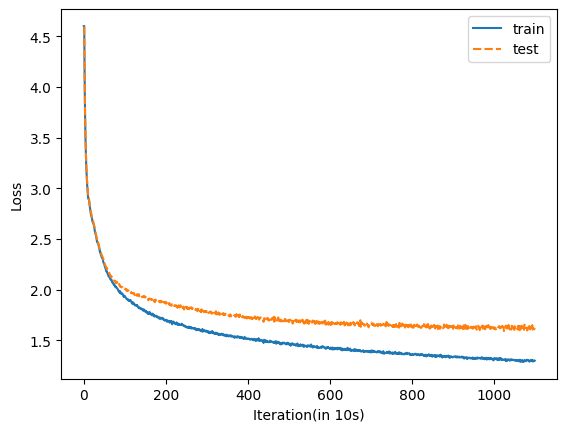

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
losses_df = pd.DataFrame(losses_data)
losses_df = losses_df.applymap(lambda x: float(x))
print(losses_df.head())
# Line graph of loss train and loss test
ax = sns.lineplot(data=losses_df[losses_df['train'] < 10])
ax.set(xlabel='Iteration(in 10s)', ylabel='Loss')
plt.show()